### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
result_filename = 'model-12-build-keras-autoencoder'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False
fix_town_and_city = False
rare_village_threshold = 2
rare_town_threshold = 2
N_feats_rm = 0  # Number of features removed (67)
skew_threshold = 2.2
debugging = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
if N_feats_rm > 0:
    from vars_03 import score_base_per_area, shuffle_results_per_area

    feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
    feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
    feat_imp = feat_imp.sort_values(by='diff', ascending=False)
    print(feat_imp.reset_index().values)

    feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
    feats_rm.remove('none')
else:
    feats_rm = []
print(len(feats_rm))
print(feats_rm)

0
[]


### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

# For Stratified train test split
#cols_stratified = ['town', 'village']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 155 Bin: 49 Cat: 7
Add: 1 0 1 Total (after): 213


### Read data

In [6]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df_test = pd.read_csv('dataset/test.csv', dtype=object)
df.check()
df_test.check()

building_id building_material city txn_dt total_floor  \
0      e3mMIMR3JJqCaXz1                 8   21  18674           4   
1      LgwzgklNvy4QCtq5                 8    7  18800           5   
2      ucIR2NLLsC3T650L                 8    7  19289           4   
3      jre1pJhcQj91Kdky                 8   21  20385          24   
4      rQpYpY9nRG7X5mmr                 1   21  20657           2   
59995  Oh5Hwr9LrWApC2mr                 1    5  19040           2   
59996  PiOgZqfsDVlTq1zs                 8   13  19706          14   
59997  FQmlgGohzzWuKUzu                 8    7  19901          11   
59998  zjzfMwXhDswdEaI2                 8   13  19975           5   
59999  iN4H6wBMtvJpF0SN                 8    7  20385           5   

      building_type building_use building_complete_dt parking_way  \
0                 3            2                 6271           2   
1                 1            2                 7885           2   
2                 1            2                 6028           2   
3                 0            2                18325           0   
4                 4            2                 6880           2   
59995             4            2                 9193           2   
59996             2            5                17168           0   
59997             0            2                13729           0   
59998             1            2                 7063           2   
59999             1            2                 8310           2   

            parking_area  ... XIV_500 XIV_index_500 XIV_1000 XIV_index_1000  \
0                    NaN  ...      58             1      157              1   
1                    NaN  ...      28             1      115              1   
2                    NaN  ...      78             1      212              1   
3                    NaN  ...      20             1      125              1   
4                    NaN  ...      18             1       47              1   
59995                NaN  ...       9             1       53              1   
59996  3.738411744735565  ...      88             1      316              1   
59997                NaN  ...     113             1      348              1   
59998                NaN  ...      23             1      142              1   
59999                NaN  ...      75             1      249              1   

      XIV_5000 XIV_index_5000 XIV_10000 XIV_index_10000             XIV_MIN  \
0         2483              1      6011               1  34.469802848528126   
1        15872              1     32221               1   40.07357348973039   
2        15760              1     32228               1   54.46208108983661   
3         2568              1      7271               1   99.62896580763416   
4         2587              1      7442               1   124.1312362968124   
59995     1435              1      4611               1  145.27967019169262   
59996     5659              1     22826               1   18.81499793345573   
59997    13252              1     32687               1   94.79959334423607   
59998     5317              1     21087               1   33.10458025153816   
59999    15417              1     32826               1   47.50987600102272   

              total_price  
0       647603.7704719775  
1               3321452.0  
2       9570885.316206373  
3      14215011.127100045  
4       762711.9757135696  
59995   987021.4150420949  
59996  15725223.997450478  
59997   11815402.03862225  
59998   18084995.81999832  
59999    8510295.87633061  

[10 rows x 235 columns]

shape = (60000, 235)


building_id building_material city txn_dt total_floor  \
0     X5gsdTWGS3W7JJQB                 1   13  18634           2   
1     BTshNOJyKHnT2YIT                 8    7  20199          10   
2     dhdymr0lV8N5kZOT                 8   12  19769           4   
3     VEwyGGMcD56w5BOc                10    7  20479          19   
4     wmUeMoJZfsqaSX9b                 8    3  18164          13   
9995  UEeCDaAJzPwdKKKA                 8    3  19494           6   
9996  i0fgbPaQsDWs7Q87                 8   13  19166          13   
9997  YunNwAhcqkf6YclI                 8    5  19340           3   
9998  A2NotxtRY9MYoWMl                 8    7  18184           5   
9999  kKvgBXiA50gRmQhP                 8   21  20370           6   

     building_type building_use building_complete_dt parking_way  \
0                4            2                 1857           2   
1                3            2                16011           2   
2                4           10                18294           2   
3                2            0                17837           2   
4                0            2                13272           2   
9995             3            2                12115           2   
9996             0            2                17502           0   
9997             4            2                11324           2   
9998             1            2                 7885           2   
9999             3            2                11142           2   

           parking_area  ... XIV_250 XIV_500 XIV_index_500 XIV_1000  \
0                   NaN  ...       7      21             1      129   
1                   NaN  ...      18      44             1       67   
2                   NaN  ...       0       3             1       35   
3                   NaN  ...      16      60             1      144   
4                   NaN  ...       4      18             1       76   
9995                NaN  ...       0       5             1       35   
9996  8.654350043224781  ...       4      23             1       66   
9997                NaN  ...       3       7             1       42   
9998                NaN  ...      33     182             1      840   
9999                NaN  ...       6      26             1      119   

     XIV_index_1000 XIV_5000 XIV_index_5000 XIV_10000 XIV_index_10000  \
0                 1     3991              1      8409               1   
1                 1     1950              1     10725               1   
2                 1     3707              1     19459               1   
3                 1     6487              1     29400               1   
4                 1     1346              1      3280               1   
9995              1     1118              1      3408               1   
9996              1     3773              1     16164               1   
9997              1     1354              1      5693               1   
9998              1     6469              1     31383               1   
9999              1     3769              1      9529               1   

                 XIV_MIN  
0      105.4622312795739  
1     100.81980868401074  
2      259.8005430183116  
3     22.941906168328487  
4     181.21309507601745  
9995  276.63801953982124  
9996   46.55561753672866  
9997  13.622703036125506  
9998   91.48925980597359  
9999  124.55299965753014  

[10 rows x 234 columns]

shape = (10000, 234)


### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    if fix_town_and_city:
        df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
        df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
df = pre_processing(df, cols_num, cols_cat, cols_bin)
df_test = pre_processing(df_test, cols_num, cols_cat, cols_bin)

/usr/local/lib/python3.5/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', cols_feats)

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', cols_tar_encoded)

# Compute skew columns
cols_right_skew = [c for c in cols_num if df[c].skew() > skew_threshold]
print('\nRight skew columns:', cols_right_skew)

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_

### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df, df_test):
        df = df.copy()   
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        #assert self.col_target in df, 'Target column not found in the dataframe'
        #self.target_scaler.fit(df, cols=[self.col_target])
        #self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [13]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [14]:
from keras_get_best import GetBest
#from keras_SGDRScheduler import SGDRScheduler

#### Model testing

In [28]:
n_cols_num_bin=9; cat_n_classes={'a': 3, 'b': 5}; cat_embed_sizes={'a': 2, 'b': 3}; 
n_neurons=(10, 7); n_encoded=5; learning_rate=0.001; optimizer=Adam; 
loss='mse'; activation='relu'; cat_loss_weights = 1.0

In [29]:
# Encoder
num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
# Using embedding for categorical features when len(cat_n_classes) > 0
cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
encoder_inputs = [num_bin_input]+list(cats_inputs.values())
cats_embedding_layers = [
    Reshape(target_shape=(cat_embed_sizes[c],))(
        Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
    ) 
    for c, c_input_dim in cat_n_classes.items()
]

# combine numerical and embedding features
x_layer = num_bin_input
if len(cats_embedding_layers) > 0:
    x_layer = concatenate([x_layer]+cats_embedding_layers)  # output shape = 258

for i, n in enumerate(n_neurons):
    x_layer = Dense(n)(x_layer)
    x_layer = Activation(activation)(x_layer)

encoder_output = Dense(n_encoded)(x_layer)
encoder = Model(inputs=encoder_inputs, outputs=encoder_output, name='encoder')

W0707 23:56:25.141509 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 23:56:25.182522 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 23:56:25.184638 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [30]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
a (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
b (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         6           a[0][0]                          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 3)         15          b[0][0]                          
__________________________________________________________________________________________________
num_bin (I

In [33]:
# Decoder
decoder_input = encoder_output  # Input(shape=(n_encoded,), dtype='float32')
#decoder_input = Input(shape=(n_encoded,), dtype='float32')(encoder_output)
x_layer = decoder_input
for i, n in enumerate(n_neurons[::-1]):
    x_layer = Dense(n)(x_layer)
    x_layer = Activation(activation)(x_layer)

num_bin_output = Dense(n_cols_num_bin, name='num_bin_out')(x_layer)
cats_outputs = {c:
    Dense(c_input_dim, activation='softmax', name=c+'_out')(x_layer)
    for c, c_input_dim in cat_n_classes.items()
}
decoder_outputs = [num_bin_output]+list(cats_outputs.values())
#decoder = Model(inputs=decoder_input, outputs=decoder_outputs, name='decoder')

In [37]:
loss = 'mse'
cat_loss_weights = 1.
optimizer = Adam
learning_rate = 0.001
# Autoencoder = encoder + decoder
autoencoder = Model(inputs=encoder_inputs,
                    outputs=decoder_outputs, 
                    name='autoencoder')
losses = {'num_bin_out': loss}
loss_weights = {'num_bin_out': 1.}
metrics = {'num_bin_out': [m for m in ['mse', 'mae'] if m != loss]}
for c in cat_n_classes:
    losses[c+'_out'] = 'categorical_crossentropy'
    metrics[c+'_out'] = 'accuracy'
    loss_weights[c+'_out'] = cat_loss_weights
autoencoder.compile(optimizer=optimizer(lr=learning_rate), 
                    loss=losses, metrics=metrics)

W0707 23:57:41.610374 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [38]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
a (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
b (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         6           a[0][0]                          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 3)         15          b[0][0]                          
__________________________________________________________________________________________________
num_bin (I

#### Autoencoder

In [15]:
def build_autoencoder(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(2048, 1024), n_encoded=128, learning_rate=0.001, optimizer=Adam, 
                loss='mse', activation='relu', cat_loss_weights = 1.0,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    # Encoder
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    # Using embedding for categorical features when len(cat_n_classes) > 0
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    encoder_inputs = [num_bin_input]+list(cats_inputs.values())
    cats_embedding_layers = [
        Reshape(target_shape=(cat_embed_sizes[c],))(
            Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
        ) 
        for c, c_input_dim in cat_n_classes.items()
    ]
    
    # combine numerical and embedding features
    x_layer = num_bin_input
    if len(cats_embedding_layers) > 0:
        x_layer = concatenate([x_layer]+cats_embedding_layers)  # output shape = 258
        
    for i, n in enumerate(n_neurons):
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
    
    encoder_output = Dense(n_encoded)(x_layer)
    encoder = Model(inputs=encoder_inputs, outputs=encoder_output, name='encoder')
    
    # Decoder
    decoder_input = encoder_output  # Input(shape=(n_encoded,), dtype='float32')
    x_layer = decoder_input
    for i, n in enumerate(n_neurons[::-1]):
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
        
    num_bin_output = Dense(n_cols_num_bin, name='num_bin_out')(x_layer)
    cats_outputs = {c:
        Dense(c_input_dim, activation='softmax', name=c+'_out')(x_layer)
        for c, c_input_dim in cat_n_classes.items()
    }
    decoder_outputs = [num_bin_output]+list(cats_outputs.values())
    #decoder = Model(inputs=decoder_input, outputs=decoder_outputs, name='decoder')

    # Autoencoder = encoder + decoder
    autoencoder = Model(inputs=encoder_inputs, outputs=decoder_outputs, name='autoencoder')
    losses = {'num_bin_out': loss}
    loss_weights = {'num_bin_out': 1.}
    metrics = {'num_bin_out': [m for m in ['mse', 'mae'] if m != loss]}
    for c in cat_n_classes:
        losses[c+'_out'] = 'categorical_crossentropy'
        metrics[c+'_out'] = 'accuracy'
        loss_weights[c+'_out'] = cat_loss_weights
    autoencoder.compile(optimizer=optimizer(lr=learning_rate), loss=losses, metrics=metrics)
    return autoencoder, encoder #, decoder

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

from keras.utils import to_categorical

def build_targets_matrices(Xs, cat_n_classes):
    ''' Build target matrices for autoencoder '''
    # TODO: to categorical
    Xs_targets = {'num_bin_out': Xs['num_bin']}
    for c in cat_n_classes:
        Xs_targets[c+'_out'] = to_categorical(Xs[c], num_classes=cat_n_classes[c])
    return Xs_targets

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist_mean(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    keys_plot = [c for c in hists[0] for m in metrics_plot if c.endswith(m)]
    
    for c in keys_plot:
        plt.figure(figsize=(14, 4))
        array = np.zeros((len(hists[0][c]), len(hists)))
        for i, hist in enumerate(hists):
            array[:, i] = np.array(hist[c])
        sq_mean = array.mean(axis=1)
        sq_std = np.std(array, axis=1)
        #plt.errorbar(np.arange(1, len(sq_mean)+1), sq_mean, yerr=sq_std, label=c, alpha=0.9, fmt='-o')
        plt.plot(sq_mean, label=c+'_mean')
        plt.plot(sq_mean+sq_std, label=c+'_std+', alpha=0.5)
        plt.plot(sq_mean-sq_std, label=c+'_std-', alpha=0.5)
        if ylim != None: plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(c+'_mean')
        plt.legend(); plt.grid(); plt.show()

### Grid search

In [18]:
# grid search
params_fix = {
    'epochs': 1000,
    'loss': 'mse',
    'n_neurons': (4096, 2048),
    'batch_size': 256,
    'embedding_ratio': 4,
 }
# prvs baseline best estimator
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

params_gsearch = {
    #'learning_rate': [0.0009, 0.001, 0.0012],
    'n_encoded': [50, 100, 500],
}

N_iter = 0
#N_fold = 3
#score_low_bound = 5000 # if score smaller than this, skip the param set

if debugging:
    params_fix = {'epochs': 100,
                  'loss': 'mse',
                  'n_neurons': (20, 10),
                  'batch_size': 512,
                  'embedding_ratio': 4,
                 }
    params_gsearch = {
        'n_encoded': [10, 20],
    }    
    N_iter = 2

#### Round 1

In [19]:
# Round 1
rand_params_set = [{'n_encoded': 500}, {'n_encoded': 100}, {'n_encoded': 50}]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)

In [20]:
rand_params_set

[{'n_encoded': 500}, {'n_encoded': 100}, {'n_encoded': 50}]

In [21]:
t0 = time.time()
gsearch = {}

df['train_set'] = True
df_test['train_set'] = False

df_all = pd.concat([df.loc[:, df_test.columns], df_test]).reset_index(drop=True)    

# feat eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,
                              rare_village_threshold=rare_village_threshold, 
                              rare_town_threshold=rare_town_threshold,)
df_all = feat_eng.fit_transform(df_all, df_test)

# Compute network size
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
else:
    cat_n_classes = {}

# Prepare X y matrices
if is_embedding:
    Xs = build_features_matrices(df_all, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    Xs = build_features_matrices(df_all, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
Xs_targets = build_targets_matrices(Xs, cat_n_classes)

# random sample - grid search
rand_params_next = []
for i_set, params_rand in enumerate(rand_params_set):
    print('---', i_set+1, '/', len(rand_params_set), '---')
    params = params_fix.copy()
    params.update( params_rand )

    # Compute network size
    cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1),
                              cat_n_classes[c]) for c in cat_n_classes}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))
    print()
    Xs_targets = build_targets_matrices(Xs, cat_n_classes)    

    autoencoder, encoder = build_autoencoder(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

    hist = autoencoder.fit(x=Xs, y=Xs_targets, verbose=2, 
                           callbacks=[GetBest(monitor='loss', verbose=0, mode='min')], 
                           batch_size=params['batch_size'], epochs=params['epochs'])
    
    Y_encoded = encoder.predict(Xs, batch_size=1024)
    
    df_all_encoded = pd.DataFrame(Y_encoded)
    df_all_encoded['building_id'] = df_all['building_id']
    #df_all_encoded['train_set'] = df_all['train_set']
    #df_all_encoded.loc[df_all_encoded['train_set']]
    df_all_encoded.to_csv(result_filename+'-'+str(params['n_encoded'])+'.csv', index=False)

    scores = autoencoder.evaluate(x=Xs, y=Xs_targets, batch_size=1024, verbose=0)
    print('params:', params)
    print(scores)
    print()
    #print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

    #rand_params_next.append(params_rand)
    tuple_params = tuple(params.items())
    if tuple_params not in gsearch:
        gsearch[tuple_params] = {}
    gsearch[tuple_params]['hist'] = hist
    gsearch[tuple_params]['loss'] = scores[0]
    gsearch[tuple_params]['scores'] = scores
    #gsearch[tuple_params]['autoencoder'] = autoencoder
    #gsearch[tuple_params]['encoder'] = encoder
    gsearch[tuple_params]['encoded'] = df_all_encoded
    #gsearch[tuple_params][2].append(mse)
    #gsearch[tuple_params][3].append(mae)
    #gsearch[tuple_params][4].append(mape)

#rand_params_set = rand_params_next
# aggregate, sort gsearch results
#gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] 
#                   for key, val in gsearch.items()]
#gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

W0709 08:35:39.451128 140235248756480 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



--- 1 / 3 ---
Numerical input dims: 205
Embeding  input dims: {'parking_way': 4, 'village': 2585, 'building_use': 11, 'town': 205, 'encoded_latlon': 7, 'city': 12, 'building_material': 10, 'building_type': 6}
Embeding output dims: {'parking_way': 4, 'village': 32, 'building_use': 10, 'encoded_latlon': 7, 'building_type': 6, 'town': 22, 'city': 11, 'building_material': 10}
Total embedding output dims: 102



W0709 08:35:39.474948 140235248756480 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 08:35:39.475910 140235248756480 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 08:35:39.809851 140235248756480 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 08:35:39.841370 140235248756480 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0709 08:35:40.649187 140235248756480 deprecation.py:323] From /usr/local/li

Epoch 1/1000
 - 23s - loss: 6.9799 - num_bin_out_loss: 0.4207 - parking_way_out_loss: 0.1397 - village_out_loss: 4.3409 - building_use_out_loss: 0.3685 - encoded_latlon_out_loss: 0.1120 - building_type_out_loss: 0.3513 - town_out_loss: 0.9733 - city_out_loss: 0.1209 - building_material_out_loss: 0.1526 - num_bin_out_mean_absolute_error: 0.4244 - parking_way_out_acc: 0.9516 - village_out_acc: 0.2018 - building_use_out_acc: 0.9022 - encoded_latlon_out_acc: 0.9640 - building_type_out_acc: 0.8754 - town_out_acc: 0.7296 - city_out_acc: 0.9631 - building_material_out_acc: 0.9580
Epoch 2/1000
 - 21s - loss: 1.7248 - num_bin_out_loss: 0.3536 - parking_way_out_loss: 0.0218 - village_out_loss: 1.0205 - building_use_out_loss: 0.0961 - encoded_latlon_out_loss: 0.0128 - building_type_out_loss: 0.0483 - town_out_loss: 0.1077 - city_out_loss: 0.0105 - building_material_out_loss: 0.0535 - num_bin_out_mean_absolute_error: 0.3920 - parking_way_out_acc: 0.9932 - village_out_acc: 0.7349 - building_use_out

Epoch 16/1000
 - 21s - loss: 0.2790 - num_bin_out_loss: 0.1945 - parking_way_out_loss: 0.0056 - village_out_loss: 0.0427 - building_use_out_loss: 0.0063 - encoded_latlon_out_loss: 0.0025 - building_type_out_loss: 0.0055 - town_out_loss: 0.0140 - city_out_loss: 0.0027 - building_material_out_loss: 0.0051 - num_bin_out_mean_absolute_error: 0.2763 - parking_way_out_acc: 0.9988 - village_out_acc: 0.9900 - building_use_out_acc: 0.9980 - encoded_latlon_out_acc: 0.9992 - building_type_out_acc: 0.9986 - town_out_acc: 0.9958 - city_out_acc: 0.9991 - building_material_out_acc: 0.9984
Epoch 17/1000
 - 21s - loss: 0.2762 - num_bin_out_loss: 0.1911 - parking_way_out_loss: 0.0024 - village_out_loss: 0.0463 - building_use_out_loss: 0.0083 - encoded_latlon_out_loss: 0.0031 - building_type_out_loss: 0.0034 - town_out_loss: 0.0150 - city_out_loss: 0.0032 - building_material_out_loss: 0.0033 - num_bin_out_mean_absolute_error: 0.2744 - parking_way_out_acc: 0.9995 - village_out_acc: 0.9888 - building_use_o

Epoch 31/1000
 - 21s - loss: 0.1957 - num_bin_out_loss: 0.1500 - parking_way_out_loss: 5.0692e-04 - village_out_loss: 0.0243 - building_use_out_loss: 0.0029 - encoded_latlon_out_loss: 0.0017 - building_type_out_loss: 0.0047 - town_out_loss: 0.0074 - city_out_loss: 0.0015 - building_material_out_loss: 0.0026 - num_bin_out_mean_absolute_error: 0.2402 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9947 - building_use_out_acc: 0.9991 - encoded_latlon_out_acc: 0.9996 - building_type_out_acc: 0.9991 - town_out_acc: 0.9977 - city_out_acc: 0.9995 - building_material_out_acc: 0.9993
Epoch 32/1000
 - 21s - loss: 0.1685 - num_bin_out_loss: 0.1374 - parking_way_out_loss: 0.0024 - village_out_loss: 0.0160 - building_use_out_loss: 0.0032 - encoded_latlon_out_loss: 5.7104e-04 - building_type_out_loss: 0.0016 - town_out_loss: 0.0045 - city_out_loss: 9.1242e-04 - building_material_out_loss: 0.0018 - num_bin_out_mean_absolute_error: 0.2271 - parking_way_out_acc: 0.9996 - village_out_acc: 0.9973 - bu

Epoch 45/1000
 - 21s - loss: 0.1155 - num_bin_out_loss: 0.1054 - parking_way_out_loss: 8.4995e-04 - village_out_loss: 0.0069 - building_use_out_loss: 0.0011 - encoded_latlon_out_loss: 1.9507e-05 - building_type_out_loss: 4.2777e-04 - town_out_loss: 2.1593e-04 - city_out_loss: 7.8649e-05 - building_material_out_loss: 5.3912e-04 - num_bin_out_mean_absolute_error: 0.1955 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9994 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 46/1000
 - 21s - loss: 0.1122 - num_bin_out_loss: 0.1004 - parking_way_out_loss: 2.4271e-05 - village_out_loss: 0.0080 - building_use_out_loss: 0.0011 - encoded_latlon_out_loss: 6.6104e-05 - building_type_out_loss: 8.8505e-04 - town_out_loss: 3.0658e-04 - city_out_loss: 1.7382e-05 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1907 - parking_way_out_acc: 1.000

Epoch 59/1000
 - 21s - loss: 0.0671 - num_bin_out_loss: 0.0606 - parking_way_out_loss: 9.4109e-06 - village_out_loss: 0.0060 - building_use_out_loss: 4.7553e-05 - encoded_latlon_out_loss: 6.1994e-06 - building_type_out_loss: 3.1099e-05 - town_out_loss: 6.4839e-05 - city_out_loss: 4.5220e-06 - building_material_out_loss: 2.5270e-04 - num_bin_out_mean_absolute_error: 0.1472 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 60/1000
 - 21s - loss: 0.0637 - num_bin_out_loss: 0.0572 - parking_way_out_loss: 9.8958e-06 - village_out_loss: 0.0060 - building_use_out_loss: 4.8900e-05 - encoded_latlon_out_loss: 6.4851e-06 - building_type_out_loss: 3.4585e-05 - town_out_loss: 6.6831e-05 - city_out_loss: 4.6384e-06 - building_material_out_loss: 2.5541e-04 - num_bin_out_mean_absolute_error: 0.1437 - parking_way_ou

Epoch 73/1000
 - 21s - loss: 0.1154 - num_bin_out_loss: 0.0940 - parking_way_out_loss: 0.0017 - village_out_loss: 0.0105 - building_use_out_loss: 0.0016 - encoded_latlon_out_loss: 4.0022e-04 - building_type_out_loss: 0.0029 - town_out_loss: 0.0019 - city_out_loss: 6.1914e-04 - building_material_out_loss: 0.0017 - num_bin_out_mean_absolute_error: 0.1881 - parking_way_out_acc: 0.9996 - village_out_acc: 0.9983 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9994 - town_out_acc: 0.9995 - city_out_acc: 0.9998 - building_material_out_acc: 0.9996
Epoch 74/1000
 - 21s - loss: 0.1769 - num_bin_out_loss: 0.1255 - parking_way_out_loss: 0.0022 - village_out_loss: 0.0290 - building_use_out_loss: 0.0047 - encoded_latlon_out_loss: 0.0013 - building_type_out_loss: 0.0035 - town_out_loss: 0.0084 - city_out_loss: 0.0017 - building_material_out_loss: 7.6831e-04 - num_bin_out_mean_absolute_error: 0.2241 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9933 - bu

Epoch 87/1000
 - 21s - loss: 0.1127 - num_bin_out_loss: 0.0957 - parking_way_out_loss: 7.5681e-05 - village_out_loss: 0.0099 - building_use_out_loss: 0.0011 - encoded_latlon_out_loss: 2.6600e-04 - building_type_out_loss: 2.0149e-04 - town_out_loss: 0.0036 - city_out_loss: 4.9425e-04 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1914 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9981 - building_use_out_acc: 0.9996 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 1.0000 - town_out_acc: 0.9990 - city_out_acc: 0.9998 - building_material_out_acc: 0.9998
Epoch 88/1000
 - 21s - loss: 0.0898 - num_bin_out_loss: 0.0809 - parking_way_out_loss: 7.6415e-06 - village_out_loss: 0.0065 - building_use_out_loss: 4.5048e-04 - encoded_latlon_out_loss: 1.4357e-05 - building_type_out_loss: 2.1288e-05 - town_out_loss: 0.0014 - city_out_loss: 5.3736e-05 - building_material_out_loss: 5.0201e-04 - num_bin_out_mean_absolute_error: 0.1727 - parking_way_out_acc: 1.0000 - 

Epoch 101/1000
 - 21s - loss: 0.1180 - num_bin_out_loss: 0.0918 - parking_way_out_loss: 3.7667e-04 - village_out_loss: 0.0142 - building_use_out_loss: 0.0017 - encoded_latlon_out_loss: 0.0016 - building_type_out_loss: 5.7638e-04 - town_out_loss: 0.0042 - city_out_loss: 0.0015 - building_material_out_loss: 0.0021 - num_bin_out_mean_absolute_error: 0.1900 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9972 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9995 - building_type_out_acc: 0.9999 - town_out_acc: 0.9987 - city_out_acc: 0.9995 - building_material_out_acc: 0.9996
Epoch 102/1000
 - 21s - loss: 0.1682 - num_bin_out_loss: 0.1173 - parking_way_out_loss: 0.0018 - village_out_loss: 0.0260 - building_use_out_loss: 0.0047 - encoded_latlon_out_loss: 0.0021 - building_type_out_loss: 0.0029 - town_out_loss: 0.0092 - city_out_loss: 0.0022 - building_material_out_loss: 0.0021 - num_bin_out_mean_absolute_error: 0.2180 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9937 - buil

Epoch 115/1000
 - 21s - loss: 0.0586 - num_bin_out_loss: 0.0533 - parking_way_out_loss: 4.0353e-06 - village_out_loss: 0.0043 - building_use_out_loss: 7.3345e-04 - encoded_latlon_out_loss: 2.4426e-06 - building_type_out_loss: 1.1416e-05 - town_out_loss: 2.8521e-05 - city_out_loss: 2.2717e-06 - building_material_out_loss: 2.3778e-04 - num_bin_out_mean_absolute_error: 0.1390 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9997 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 116/1000
 - 21s - loss: 0.0675 - num_bin_out_loss: 0.0576 - parking_way_out_loss: 9.9104e-06 - village_out_loss: 0.0061 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 3.9710e-04 - building_type_out_loss: 2.2512e-05 - town_out_loss: 0.0010 - city_out_loss: 4.3750e-04 - building_material_out_loss: 4.9594e-04 - num_bin_out_mean_absolute_error: 0.1447 - parking_way_out_acc:

Epoch 129/1000
 - 21s - loss: 0.0591 - num_bin_out_loss: 0.0538 - parking_way_out_loss: 4.1781e-06 - village_out_loss: 0.0042 - building_use_out_loss: 2.7612e-04 - encoded_latlon_out_loss: 1.6250e-06 - building_type_out_loss: 1.1002e-05 - town_out_loss: 2.2536e-05 - city_out_loss: 2.1966e-06 - building_material_out_loss: 7.4320e-04 - num_bin_out_mean_absolute_error: 0.1394 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9997 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 130/1000
 - 21s - loss: 0.0553 - num_bin_out_loss: 0.0504 - parking_way_out_loss: 2.5592e-06 - village_out_loss: 0.0042 - building_use_out_loss: 5.2164e-05 - encoded_latlon_out_loss: 1.6201e-06 - building_type_out_loss: 8.4694e-06 - town_out_loss: 1.8305e-05 - city_out_loss: 5.0768e-06 - building_material_out_loss: 6.0022e-04 - num_bin_out_mean_absolute_error: 0.1347 - parking_way_

Epoch 143/1000
 - 21s - loss: 0.0332 - num_bin_out_loss: 0.0286 - parking_way_out_loss: 3.7667e-06 - village_out_loss: 0.0043 - building_use_out_loss: 2.2185e-05 - encoded_latlon_out_loss: 3.0572e-06 - building_type_out_loss: 1.5511e-05 - town_out_loss: 3.2833e-05 - city_out_loss: 2.2550e-06 - building_material_out_loss: 2.3918e-04 - num_bin_out_mean_absolute_error: 0.1021 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9997 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 144/1000
 - 21s - loss: 0.0323 - num_bin_out_loss: 0.0278 - parking_way_out_loss: 4.0192e-06 - village_out_loss: 0.0043 - building_use_out_loss: 2.2446e-05 - encoded_latlon_out_loss: 2.9935e-06 - building_type_out_loss: 1.4699e-05 - town_out_loss: 3.4125e-05 - city_out_loss: 2.3752e-06 - building_material_out_loss: 2.3938e-04 - num_bin_out_mean_absolute_error: 0.1008 - parking_way_

Epoch 157/1000
 - 21s - loss: 0.2620 - num_bin_out_loss: 0.1466 - parking_way_out_loss: 0.0026 - village_out_loss: 0.0625 - building_use_out_loss: 0.0098 - encoded_latlon_out_loss: 0.0046 - building_type_out_loss: 0.0040 - town_out_loss: 0.0221 - city_out_loss: 0.0056 - building_material_out_loss: 0.0042 - num_bin_out_mean_absolute_error: 0.2392 - parking_way_out_acc: 0.9995 - village_out_acc: 0.9833 - building_use_out_acc: 0.9977 - encoded_latlon_out_acc: 0.9988 - building_type_out_acc: 0.9990 - town_out_acc: 0.9939 - city_out_acc: 0.9984 - building_material_out_acc: 0.9991
Epoch 158/1000
 - 21s - loss: 0.1079 - num_bin_out_loss: 0.0853 - parking_way_out_loss: 8.3555e-04 - village_out_loss: 0.0106 - building_use_out_loss: 0.0020 - encoded_latlon_out_loss: 0.0013 - building_type_out_loss: 9.3075e-04 - town_out_loss: 0.0037 - city_out_loss: 0.0011 - building_material_out_loss: 0.0021 - num_bin_out_mean_absolute_error: 0.1794 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9977 - buil

Epoch 171/1000
 - 21s - loss: 0.0416 - num_bin_out_loss: 0.0372 - parking_way_out_loss: 2.9958e-06 - village_out_loss: 0.0042 - building_use_out_loss: 1.1441e-05 - encoded_latlon_out_loss: 1.0895e-06 - building_type_out_loss: 5.9502e-06 - town_out_loss: 1.1352e-05 - city_out_loss: 6.1203e-07 - building_material_out_loss: 2.3537e-04 - num_bin_out_mean_absolute_error: 0.1145 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9997 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 172/1000
 - 21s - loss: 0.0392 - num_bin_out_loss: 0.0347 - parking_way_out_loss: 3.0482e-06 - village_out_loss: 0.0042 - building_use_out_loss: 1.1867e-05 - encoded_latlon_out_loss: 8.9628e-07 - building_type_out_loss: 5.5922e-06 - town_out_loss: 1.2314e-05 - city_out_loss: 5.8995e-07 - building_material_out_loss: 2.3624e-04 - num_bin_out_mean_absolute_error: 0.1106 - parking_way_

Epoch 185/1000
 - 21s - loss: 0.0368 - num_bin_out_loss: 0.0315 - parking_way_out_loss: 0.0012 - village_out_loss: 0.0040 - building_use_out_loss: 1.2689e-05 - encoded_latlon_out_loss: 1.0708e-06 - building_type_out_loss: 5.6128e-06 - town_out_loss: 1.3569e-05 - city_out_loss: 8.4081e-07 - building_material_out_loss: 2.3587e-04 - num_bin_out_mean_absolute_error: 0.1056 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 186/1000
 - 21s - loss: 0.0352 - num_bin_out_loss: 0.0299 - parking_way_out_loss: 0.0012 - village_out_loss: 0.0040 - building_use_out_loss: 1.2510e-05 - encoded_latlon_out_loss: 1.0955e-06 - building_type_out_loss: 5.9965e-06 - town_out_loss: 1.3978e-05 - city_out_loss: 8.8644e-07 - building_material_out_loss: 2.3567e-04 - num_bin_out_mean_absolute_error: 0.1030 - parking_way_out_acc:

Epoch 199/1000
 - 21s - loss: 0.0292 - num_bin_out_loss: 0.0255 - parking_way_out_loss: 2.6680e-06 - village_out_loss: 0.0035 - building_use_out_loss: 1.1381e-05 - encoded_latlon_out_loss: 1.1115e-06 - building_type_out_loss: 7.2487e-06 - town_out_loss: 1.4441e-05 - city_out_loss: 8.9273e-07 - building_material_out_loss: 2.3554e-04 - num_bin_out_mean_absolute_error: 0.0955 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 200/1000
 - 21s - loss: 0.0284 - num_bin_out_loss: 0.0246 - parking_way_out_loss: 2.6289e-06 - village_out_loss: 0.0035 - building_use_out_loss: 1.1380e-05 - encoded_latlon_out_loss: 1.1095e-06 - building_type_out_loss: 7.7621e-06 - town_out_loss: 1.4811e-05 - city_out_loss: 1.0573e-06 - building_material_out_loss: 2.3548e-04 - num_bin_out_mean_absolute_error: 0.0940 - parking_way_

Epoch 213/1000
 - 21s - loss: 0.0696 - num_bin_out_loss: 0.0576 - parking_way_out_loss: 2.9598e-05 - village_out_loss: 0.0082 - building_use_out_loss: 2.9050e-04 - encoded_latlon_out_loss: 2.1415e-04 - building_type_out_loss: 5.9146e-04 - town_out_loss: 0.0022 - city_out_loss: 2.7453e-04 - building_material_out_loss: 2.8579e-04 - num_bin_out_mean_absolute_error: 0.1483 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9985 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 0.9999 - town_out_acc: 0.9994 - city_out_acc: 0.9999 - building_material_out_acc: 1.0000
Epoch 214/1000
 - 21s - loss: 0.0528 - num_bin_out_loss: 0.0452 - parking_way_out_loss: 1.4826e-04 - village_out_loss: 0.0045 - building_use_out_loss: 0.0013 - encoded_latlon_out_loss: 1.1972e-04 - building_type_out_loss: 7.5276e-06 - town_out_loss: 9.9467e-04 - city_out_loss: 2.5867e-04 - building_material_out_loss: 3.2018e-04 - num_bin_out_mean_absolute_error: 0.1290 - parking_way_out_acc:

Epoch 227/1000
 - 21s - loss: 0.0300 - num_bin_out_loss: 0.0267 - parking_way_out_loss: 1.7670e-06 - village_out_loss: 0.0030 - building_use_out_loss: 8.0199e-06 - encoded_latlon_out_loss: 7.5262e-07 - building_type_out_loss: 3.3126e-06 - town_out_loss: 8.0605e-06 - city_out_loss: 6.5826e-07 - building_material_out_loss: 2.3414e-04 - num_bin_out_mean_absolute_error: 0.0972 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 228/1000
 - 21s - loss: 0.0289 - num_bin_out_loss: 0.0256 - parking_way_out_loss: 1.7867e-06 - village_out_loss: 0.0030 - building_use_out_loss: 7.9859e-06 - encoded_latlon_out_loss: 8.9211e-07 - building_type_out_loss: 3.7277e-06 - town_out_loss: 9.0924e-06 - city_out_loss: 7.5627e-07 - building_material_out_loss: 2.3460e-04 - num_bin_out_mean_absolute_error: 0.0951 - parking_way_

Epoch 241/1000
 - 21s - loss: 0.0216 - num_bin_out_loss: 0.0183 - parking_way_out_loss: 2.0916e-06 - village_out_loss: 0.0031 - building_use_out_loss: 1.1264e-05 - encoded_latlon_out_loss: 2.4664e-06 - building_type_out_loss: 7.8723e-06 - town_out_loss: 1.9048e-05 - city_out_loss: 1.5883e-06 - building_material_out_loss: 2.3481e-04 - num_bin_out_mean_absolute_error: 0.0812 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 242/1000
 - 21s - loss: 0.0213 - num_bin_out_loss: 0.0180 - parking_way_out_loss: 2.1797e-06 - village_out_loss: 0.0031 - building_use_out_loss: 1.2112e-05 - encoded_latlon_out_loss: 2.3292e-06 - building_type_out_loss: 8.2436e-06 - town_out_loss: 2.0497e-05 - city_out_loss: 1.7141e-06 - building_material_out_loss: 2.3492e-04 - num_bin_out_mean_absolute_error: 0.0805 - parking_way_

Epoch 255/1000
 - 21s - loss: 0.0244 - num_bin_out_loss: 0.0214 - parking_way_out_loss: 1.6216e-06 - village_out_loss: 0.0028 - building_use_out_loss: 9.6782e-06 - encoded_latlon_out_loss: 1.0980e-06 - building_type_out_loss: 4.1071e-06 - town_out_loss: 9.6010e-06 - city_out_loss: 9.2333e-07 - building_material_out_loss: 2.3476e-04 - num_bin_out_mean_absolute_error: 0.0869 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 256/1000
 - 21s - loss: 0.0233 - num_bin_out_loss: 0.0203 - parking_way_out_loss: 1.6525e-06 - village_out_loss: 0.0028 - building_use_out_loss: 9.0707e-06 - encoded_latlon_out_loss: 1.1038e-06 - building_type_out_loss: 4.5921e-06 - town_out_loss: 9.4143e-06 - city_out_loss: 8.9488e-07 - building_material_out_loss: 2.3417e-04 - num_bin_out_mean_absolute_error: 0.0847 - parking_way_

Epoch 269/1000
 - 21s - loss: 0.0184 - num_bin_out_loss: 0.0153 - parking_way_out_loss: 2.0434e-06 - village_out_loss: 0.0028 - building_use_out_loss: 1.2177e-05 - encoded_latlon_out_loss: 2.2938e-06 - building_type_out_loss: 8.8766e-06 - town_out_loss: 1.5965e-05 - city_out_loss: 1.9079e-06 - building_material_out_loss: 2.3457e-04 - num_bin_out_mean_absolute_error: 0.0747 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 270/1000
 - 21s - loss: 0.3102 - num_bin_out_loss: 0.1640 - parking_way_out_loss: 0.0042 - village_out_loss: 0.0815 - building_use_out_loss: 0.0124 - encoded_latlon_out_loss: 0.0051 - building_type_out_loss: 0.0077 - town_out_loss: 0.0238 - city_out_loss: 0.0054 - building_material_out_loss: 0.0061 - num_bin_out_mean_absolute_error: 0.2498 - parking_way_out_acc: 0.9992 - village_ou

Epoch 283/1000
 - 21s - loss: 0.0192 - num_bin_out_loss: 0.0162 - parking_way_out_loss: 9.1579e-07 - village_out_loss: 0.0028 - building_use_out_loss: 8.2951e-06 - encoded_latlon_out_loss: 1.1942e-06 - building_type_out_loss: 5.2151e-06 - town_out_loss: 8.3753e-06 - city_out_loss: 8.6179e-07 - building_material_out_loss: 2.3402e-04 - num_bin_out_mean_absolute_error: 0.0760 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 284/1000
 - 21s - loss: 0.0189 - num_bin_out_loss: 0.0158 - parking_way_out_loss: 9.8038e-07 - village_out_loss: 0.0028 - building_use_out_loss: 8.5116e-06 - encoded_latlon_out_loss: 1.2449e-06 - building_type_out_loss: 5.2262e-06 - town_out_loss: 9.0865e-06 - city_out_loss: 8.9990e-07 - building_material_out_loss: 2.3415e-04 - num_bin_out_mean_absolute_error: 0.0754 - parking_way_

Epoch 297/1000
 - 21s - loss: 0.3050 - num_bin_out_loss: 0.1638 - parking_way_out_loss: 0.0041 - village_out_loss: 0.0741 - building_use_out_loss: 0.0150 - encoded_latlon_out_loss: 0.0042 - building_type_out_loss: 0.0111 - town_out_loss: 0.0219 - city_out_loss: 0.0053 - building_material_out_loss: 0.0054 - num_bin_out_mean_absolute_error: 0.2437 - parking_way_out_acc: 0.9993 - village_out_acc: 0.9795 - building_use_out_acc: 0.9966 - encoded_latlon_out_acc: 0.9988 - building_type_out_acc: 0.9980 - town_out_acc: 0.9944 - city_out_acc: 0.9986 - building_material_out_acc: 0.9989
Epoch 298/1000
 - 21s - loss: 0.0636 - num_bin_out_loss: 0.0578 - parking_way_out_loss: 1.9420e-05 - village_out_loss: 0.0036 - building_use_out_loss: 4.6197e-04 - encoded_latlon_out_loss: 2.3317e-04 - building_type_out_loss: 3.6700e-04 - town_out_loss: 5.7537e-04 - city_out_loss: 9.7940e-05 - building_material_out_loss: 4.6662e-04 - num_bin_out_mean_absolute_error: 0.1414 - parking_way_out_acc: 1.0000 - village_ou

Epoch 311/1000
 - 21s - loss: 0.0259 - num_bin_out_loss: 0.0240 - parking_way_out_loss: 1.3118e-06 - village_out_loss: 0.0016 - building_use_out_loss: 9.7439e-06 - encoded_latlon_out_loss: 1.2649e-06 - building_type_out_loss: 2.9855e-06 - town_out_loss: 4.9311e-06 - city_out_loss: 4.3395e-07 - building_material_out_loss: 2.3485e-04 - num_bin_out_mean_absolute_error: 0.0911 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 312/1000
 - 21s - loss: 0.0238 - num_bin_out_loss: 0.0219 - parking_way_out_loss: 1.2777e-06 - village_out_loss: 0.0016 - building_use_out_loss: 7.2848e-06 - encoded_latlon_out_loss: 5.1716e-07 - building_type_out_loss: 2.7808e-06 - town_out_loss: 4.2454e-06 - city_out_loss: 4.5446e-07 - building_material_out_loss: 2.3396e-04 - num_bin_out_mean_absolute_error: 0.0870 - parking_way_

Epoch 325/1000
 - 21s - loss: 0.0160 - num_bin_out_loss: 0.0141 - parking_way_out_loss: 1.5057e-06 - village_out_loss: 0.0016 - building_use_out_loss: 7.8023e-06 - encoded_latlon_out_loss: 1.1904e-06 - building_type_out_loss: 4.8483e-06 - town_out_loss: 8.0076e-06 - city_out_loss: 9.0951e-07 - building_material_out_loss: 2.3350e-04 - num_bin_out_mean_absolute_error: 0.0712 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 326/1000
 - 21s - loss: 0.0158 - num_bin_out_loss: 0.0139 - parking_way_out_loss: 1.4142e-06 - village_out_loss: 0.0016 - building_use_out_loss: 8.1122e-06 - encoded_latlon_out_loss: 1.3032e-06 - building_type_out_loss: 4.8548e-06 - town_out_loss: 8.6986e-06 - city_out_loss: 1.0242e-06 - building_material_out_loss: 2.3352e-04 - num_bin_out_mean_absolute_error: 0.0706 - parking_way_

Epoch 339/1000
 - 21s - loss: 0.1017 - num_bin_out_loss: 0.0720 - parking_way_out_loss: 6.7404e-04 - village_out_loss: 0.0143 - building_use_out_loss: 0.0021 - encoded_latlon_out_loss: 0.0017 - building_type_out_loss: 0.0014 - town_out_loss: 0.0058 - city_out_loss: 0.0012 - building_material_out_loss: 0.0024 - num_bin_out_mean_absolute_error: 0.1668 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9962 - building_use_out_acc: 0.9994 - encoded_latlon_out_acc: 0.9995 - building_type_out_acc: 0.9997 - town_out_acc: 0.9981 - city_out_acc: 0.9996 - building_material_out_acc: 0.9995
Epoch 340/1000
 - 21s - loss: 0.0422 - num_bin_out_loss: 0.0375 - parking_way_out_loss: 1.4573e-04 - village_out_loss: 0.0028 - building_use_out_loss: 3.4361e-04 - encoded_latlon_out_loss: 1.9937e-04 - building_type_out_loss: 1.3675e-05 - town_out_loss: 5.6852e-04 - city_out_loss: 3.0333e-05 - building_material_out_loss: 5.9897e-04 - num_bin_out_mean_absolute_error: 0.1164 - parking_way_out_acc: 0.9999 - villag

Epoch 353/1000
 - 21s - loss: 0.0272 - num_bin_out_loss: 0.0256 - parking_way_out_loss: 6.1222e-06 - village_out_loss: 0.0012 - building_use_out_loss: 2.2658e-04 - encoded_latlon_out_loss: 3.3288e-07 - building_type_out_loss: 3.8273e-06 - town_out_loss: 6.2741e-06 - city_out_loss: 2.9216e-07 - building_material_out_loss: 2.3360e-04 - num_bin_out_mean_absolute_error: 0.0941 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 354/1000
 - 21s - loss: 0.0252 - num_bin_out_loss: 0.0237 - parking_way_out_loss: 7.4250e-07 - village_out_loss: 0.0012 - building_use_out_loss: 1.5660e-04 - encoded_latlon_out_loss: 3.0356e-07 - building_type_out_loss: 1.8890e-06 - town_out_loss: 3.6665e-06 - city_out_loss: 2.6454e-07 - building_material_out_loss: 2.3335e-04 - num_bin_out_mean_absolute_error: 0.0903 - parking_way_

Epoch 367/1000
 - 21s - loss: 0.0153 - num_bin_out_loss: 0.0139 - parking_way_out_loss: 1.1919e-06 - village_out_loss: 0.0012 - building_use_out_loss: 5.2064e-06 - encoded_latlon_out_loss: 8.9568e-07 - building_type_out_loss: 3.6466e-06 - town_out_loss: 6.3065e-06 - city_out_loss: 6.5024e-07 - building_material_out_loss: 2.3285e-04 - num_bin_out_mean_absolute_error: 0.0706 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 368/1000
 - 21s - loss: 0.0151 - num_bin_out_loss: 0.0137 - parking_way_out_loss: 1.2778e-06 - village_out_loss: 0.0012 - building_use_out_loss: 5.4102e-06 - encoded_latlon_out_loss: 1.0066e-06 - building_type_out_loss: 3.7962e-06 - town_out_loss: 6.7458e-06 - city_out_loss: 6.8141e-07 - building_material_out_loss: 2.3299e-04 - num_bin_out_mean_absolute_error: 0.0701 - parking_way_

Epoch 381/1000
 - 21s - loss: 0.2813 - num_bin_out_loss: 0.1449 - parking_way_out_loss: 0.0054 - village_out_loss: 0.0736 - building_use_out_loss: 0.0113 - encoded_latlon_out_loss: 0.0036 - building_type_out_loss: 0.0112 - town_out_loss: 0.0217 - city_out_loss: 0.0049 - building_material_out_loss: 0.0047 - num_bin_out_mean_absolute_error: 0.2145 - parking_way_out_acc: 0.9989 - village_out_acc: 0.9794 - building_use_out_acc: 0.9974 - encoded_latlon_out_acc: 0.9990 - building_type_out_acc: 0.9982 - town_out_acc: 0.9943 - city_out_acc: 0.9986 - building_material_out_acc: 0.9990
Epoch 382/1000
 - 21s - loss: 0.0762 - num_bin_out_loss: 0.0692 - parking_way_out_loss: 1.5659e-04 - village_out_loss: 0.0032 - building_use_out_loss: 6.6538e-04 - encoded_latlon_out_loss: 9.9361e-05 - building_type_out_loss: 2.7400e-04 - town_out_loss: 0.0016 - city_out_loss: 2.1030e-04 - building_material_out_loss: 7.2941e-04 - num_bin_out_mean_absolute_error: 0.1528 - parking_way_out_acc: 0.9999 - village_out_ac

Epoch 395/1000
 - 21s - loss: 0.0140 - num_bin_out_loss: 0.0126 - parking_way_out_loss: 9.4615e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.9831e-06 - encoded_latlon_out_loss: 6.8941e-07 - building_type_out_loss: 2.3822e-06 - town_out_loss: 4.0012e-06 - city_out_loss: 4.9381e-07 - building_material_out_loss: 2.3214e-04 - num_bin_out_mean_absolute_error: 0.0667 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 396/1000
 - 21s - loss: 0.0137 - num_bin_out_loss: 0.0123 - parking_way_out_loss: 9.3793e-07 - village_out_loss: 0.0012 - building_use_out_loss: 5.0803e-06 - encoded_latlon_out_loss: 7.4864e-07 - building_type_out_loss: 2.4246e-06 - town_out_loss: 4.2531e-06 - city_out_loss: 5.4258e-07 - building_material_out_loss: 2.3211e-04 - num_bin_out_mean_absolute_error: 0.0661 - parking_way_

Epoch 409/1000
 - 21s - loss: 0.0124 - num_bin_out_loss: 0.0110 - parking_way_out_loss: 1.4343e-06 - village_out_loss: 0.0012 - building_use_out_loss: 7.1102e-06 - encoded_latlon_out_loss: 1.2870e-06 - building_type_out_loss: 2.9311e-06 - town_out_loss: 8.6308e-06 - city_out_loss: 1.1873e-06 - building_material_out_loss: 2.3267e-04 - num_bin_out_mean_absolute_error: 0.0628 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 410/1000
 - 21s - loss: 0.0123 - num_bin_out_loss: 0.0109 - parking_way_out_loss: 1.5097e-06 - village_out_loss: 0.0012 - building_use_out_loss: 7.3983e-06 - encoded_latlon_out_loss: 1.3517e-06 - building_type_out_loss: 2.9137e-06 - town_out_loss: 8.9481e-06 - city_out_loss: 1.2335e-06 - building_material_out_loss: 2.3286e-04 - num_bin_out_mean_absolute_error: 0.0626 - parking_way_

Epoch 423/1000
 - 21s - loss: 0.0246 - num_bin_out_loss: 0.0231 - parking_way_out_loss: 5.4551e-07 - village_out_loss: 0.0012 - building_use_out_loss: 8.1484e-06 - encoded_latlon_out_loss: 4.0612e-07 - building_type_out_loss: 8.4328e-06 - town_out_loss: 4.5354e-06 - city_out_loss: 5.0802e-07 - building_material_out_loss: 2.3180e-04 - num_bin_out_mean_absolute_error: 0.0862 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 424/1000
 - 21s - loss: 0.0225 - num_bin_out_loss: 0.0211 - parking_way_out_loss: 6.2520e-07 - village_out_loss: 0.0012 - building_use_out_loss: 6.9201e-06 - encoded_latlon_out_loss: 3.9651e-07 - building_type_out_loss: 7.7209e-06 - town_out_loss: 3.9434e-06 - city_out_loss: 4.4118e-07 - building_material_out_loss: 2.3237e-04 - num_bin_out_mean_absolute_error: 0.0825 - parking_way_

Epoch 437/1000
 - 21s - loss: 0.0140 - num_bin_out_loss: 0.0126 - parking_way_out_loss: 9.5265e-07 - village_out_loss: 0.0012 - building_use_out_loss: 5.7378e-06 - encoded_latlon_out_loss: 7.6368e-07 - building_type_out_loss: 3.0313e-06 - town_out_loss: 4.9993e-06 - city_out_loss: 5.8361e-07 - building_material_out_loss: 2.3232e-04 - num_bin_out_mean_absolute_error: 0.0668 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 438/1000
 - 21s - loss: 0.0138 - num_bin_out_loss: 0.0124 - parking_way_out_loss: 8.7878e-07 - village_out_loss: 0.0012 - building_use_out_loss: 5.7285e-06 - encoded_latlon_out_loss: 7.3399e-07 - building_type_out_loss: 2.9274e-06 - town_out_loss: 5.2734e-06 - city_out_loss: 6.2987e-07 - building_material_out_loss: 2.3226e-04 - num_bin_out_mean_absolute_error: 0.0662 - parking_way_

Epoch 451/1000
 - 21s - loss: 0.0411 - num_bin_out_loss: 0.0369 - parking_way_out_loss: 0.0020 - village_out_loss: 0.0013 - building_use_out_loss: 1.6630e-05 - encoded_latlon_out_loss: 5.3786e-06 - building_type_out_loss: 1.0612e-04 - town_out_loss: 1.1377e-04 - city_out_loss: 8.8690e-07 - building_material_out_loss: 7.1116e-04 - num_bin_out_mean_absolute_error: 0.1067 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 452/1000
 - 21s - loss: 0.0419 - num_bin_out_loss: 0.0383 - parking_way_out_loss: 7.8803e-04 - village_out_loss: 0.0019 - building_use_out_loss: 3.9631e-05 - encoded_latlon_out_loss: 2.1749e-06 - building_type_out_loss: 2.1901e-04 - town_out_loss: 2.7975e-04 - city_out_loss: 1.1614e-06 - building_material_out_loss: 2.8907e-04 - num_bin_out_mean_absolute_error: 0.1108 - parking_way_out_

Epoch 465/1000
 - 21s - loss: 0.0166 - num_bin_out_loss: 0.0151 - parking_way_out_loss: 7.4893e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.8263e-06 - encoded_latlon_out_loss: 7.1686e-07 - building_type_out_loss: 1.5710e-06 - town_out_loss: 4.2019e-06 - city_out_loss: 3.9840e-07 - building_material_out_loss: 2.3230e-04 - num_bin_out_mean_absolute_error: 0.0719 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 466/1000
 - 21s - loss: 0.0162 - num_bin_out_loss: 0.0148 - parking_way_out_loss: 7.6176e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.8666e-06 - encoded_latlon_out_loss: 6.2560e-07 - building_type_out_loss: 1.6065e-06 - town_out_loss: 4.3049e-06 - city_out_loss: 4.3685e-07 - building_material_out_loss: 2.3250e-04 - num_bin_out_mean_absolute_error: 0.0713 - parking_way_

Epoch 479/1000
 - 21s - loss: 0.0875 - num_bin_out_loss: 0.0719 - parking_way_out_loss: 7.3561e-05 - village_out_loss: 0.0062 - building_use_out_loss: 0.0019 - encoded_latlon_out_loss: 8.6484e-04 - building_type_out_loss: 0.0015 - town_out_loss: 0.0029 - city_out_loss: 7.7411e-04 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.1569 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9982 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9997 - town_out_acc: 0.9992 - city_out_acc: 0.9997 - building_material_out_acc: 0.9998
Epoch 480/1000
 - 21s - loss: 0.0582 - num_bin_out_loss: 0.0501 - parking_way_out_loss: 4.1211e-04 - village_out_loss: 0.0027 - building_use_out_loss: 9.1067e-04 - encoded_latlon_out_loss: 1.7500e-04 - building_type_out_loss: 0.0024 - town_out_loss: 3.9970e-04 - city_out_loss: 1.5807e-04 - building_material_out_loss: 9.3720e-04 - num_bin_out_mean_absolute_error: 0.1309 - parking_way_out_acc: 1.0000 - vi

Epoch 493/1000
 - 21s - loss: 0.0149 - num_bin_out_loss: 0.0135 - parking_way_out_loss: 7.7524e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.9850e-06 - encoded_latlon_out_loss: 3.3265e-07 - building_type_out_loss: 1.0987e-06 - town_out_loss: 2.4693e-06 - city_out_loss: 2.3335e-07 - building_material_out_loss: 2.3153e-04 - num_bin_out_mean_absolute_error: 0.0684 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 494/1000
 - 21s - loss: 0.0145 - num_bin_out_loss: 0.0131 - parking_way_out_loss: 8.2308e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.1863e-06 - encoded_latlon_out_loss: 3.5421e-07 - building_type_out_loss: 1.0278e-06 - town_out_loss: 2.6339e-06 - city_out_loss: 2.6123e-07 - building_material_out_loss: 2.3178e-04 - num_bin_out_mean_absolute_error: 0.0676 - parking_way_

Epoch 507/1000
 - 21s - loss: 0.0128 - num_bin_out_loss: 0.0113 - parking_way_out_loss: 9.6647e-07 - village_out_loss: 0.0012 - building_use_out_loss: 5.6986e-06 - encoded_latlon_out_loss: 9.3270e-07 - building_type_out_loss: 1.9868e-06 - town_out_loss: 6.2052e-06 - city_out_loss: 7.1833e-07 - building_material_out_loss: 2.3219e-04 - num_bin_out_mean_absolute_error: 0.0634 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 508/1000
 - 21s - loss: 0.0127 - num_bin_out_loss: 0.0113 - parking_way_out_loss: 1.0699e-06 - village_out_loss: 0.0012 - building_use_out_loss: 7.4355e-06 - encoded_latlon_out_loss: 8.5766e-07 - building_type_out_loss: 2.0414e-06 - town_out_loss: 6.1516e-06 - city_out_loss: 7.5592e-07 - building_material_out_loss: 2.3224e-04 - num_bin_out_mean_absolute_error: 0.0633 - parking_way_

Epoch 521/1000
 - 21s - loss: 0.0187 - num_bin_out_loss: 0.0173 - parking_way_out_loss: 1.3343e-06 - village_out_loss: 0.0012 - building_use_out_loss: 5.7479e-06 - encoded_latlon_out_loss: 3.0074e-07 - building_type_out_loss: 2.4802e-06 - town_out_loss: 2.0836e-06 - city_out_loss: 2.8578e-07 - building_material_out_loss: 2.3293e-04 - num_bin_out_mean_absolute_error: 0.0762 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 522/1000
 - 21s - loss: 0.0172 - num_bin_out_loss: 0.0158 - parking_way_out_loss: 1.0549e-06 - village_out_loss: 0.0012 - building_use_out_loss: 4.4694e-06 - encoded_latlon_out_loss: 2.6920e-07 - building_type_out_loss: 1.6944e-06 - town_out_loss: 1.9263e-06 - city_out_loss: 2.6932e-07 - building_material_out_loss: 2.3204e-04 - num_bin_out_mean_absolute_error: 0.0731 - parking_way_

Epoch 535/1000
 - 21s - loss: 0.0119 - num_bin_out_loss: 0.0105 - parking_way_out_loss: 9.7961e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.9936e-06 - encoded_latlon_out_loss: 5.4004e-07 - building_type_out_loss: 1.7014e-06 - town_out_loss: 3.1401e-06 - city_out_loss: 4.4420e-07 - building_material_out_loss: 2.3177e-04 - num_bin_out_mean_absolute_error: 0.0610 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 536/1000
 - 21s - loss: 0.0118 - num_bin_out_loss: 0.0104 - parking_way_out_loss: 9.9690e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.0029e-06 - encoded_latlon_out_loss: 5.5828e-07 - building_type_out_loss: 1.8197e-06 - town_out_loss: 3.4101e-06 - city_out_loss: 4.5103e-07 - building_material_out_loss: 2.3169e-04 - num_bin_out_mean_absolute_error: 0.0609 - parking_way_

Epoch 549/1000
 - 21s - loss: 0.0164 - num_bin_out_loss: 0.0150 - parking_way_out_loss: 7.8353e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.5158e-06 - encoded_latlon_out_loss: 2.9259e-07 - building_type_out_loss: 1.3315e-06 - town_out_loss: 2.7412e-06 - city_out_loss: 3.1914e-07 - building_material_out_loss: 2.3144e-04 - num_bin_out_mean_absolute_error: 0.0714 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 550/1000
 - 21s - loss: 0.0157 - num_bin_out_loss: 0.0143 - parking_way_out_loss: 8.0697e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.4202e-06 - encoded_latlon_out_loss: 3.0442e-07 - building_type_out_loss: 1.3501e-06 - town_out_loss: 2.6272e-06 - city_out_loss: 2.7201e-07 - building_material_out_loss: 2.3140e-04 - num_bin_out_mean_absolute_error: 0.0698 - parking_way_

Epoch 563/1000
 - 21s - loss: 0.0214 - num_bin_out_loss: 0.0200 - parking_way_out_loss: 8.0714e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.9806e-06 - encoded_latlon_out_loss: 3.0851e-07 - building_type_out_loss: 1.8766e-06 - town_out_loss: 1.7648e-06 - city_out_loss: 3.2936e-07 - building_material_out_loss: 2.3202e-04 - num_bin_out_mean_absolute_error: 0.0818 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 564/1000
 - 21s - loss: 0.0197 - num_bin_out_loss: 0.0183 - parking_way_out_loss: 6.6923e-07 - village_out_loss: 0.0012 - building_use_out_loss: 6.5023e-06 - encoded_latlon_out_loss: 2.6964e-07 - building_type_out_loss: 1.9466e-06 - town_out_loss: 1.4627e-06 - city_out_loss: 2.0381e-07 - building_material_out_loss: 2.3146e-04 - num_bin_out_mean_absolute_error: 0.0784 - parking_way_

Epoch 577/1000
 - 21s - loss: 0.0134 - num_bin_out_loss: 0.0120 - parking_way_out_loss: 5.9688e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.4237e-06 - encoded_latlon_out_loss: 4.1533e-07 - building_type_out_loss: 1.8733e-06 - town_out_loss: 2.7741e-06 - city_out_loss: 2.7878e-07 - building_material_out_loss: 2.3149e-04 - num_bin_out_mean_absolute_error: 0.0653 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 578/1000
 - 21s - loss: 0.0133 - num_bin_out_loss: 0.0119 - parking_way_out_loss: 7.0039e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.5995e-06 - encoded_latlon_out_loss: 4.2541e-07 - building_type_out_loss: 1.6049e-06 - town_out_loss: 2.9818e-06 - city_out_loss: 3.0218e-07 - building_material_out_loss: 2.3155e-04 - num_bin_out_mean_absolute_error: 0.0651 - parking_way_

Epoch 591/1000
 - 21s - loss: 0.0705 - num_bin_out_loss: 0.0530 - parking_way_out_loss: 0.0055 - village_out_loss: 0.0050 - building_use_out_loss: 9.3432e-04 - encoded_latlon_out_loss: 7.7757e-04 - building_type_out_loss: 9.5320e-04 - town_out_loss: 0.0019 - city_out_loss: 9.7432e-04 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.1380 - parking_way_out_acc: 0.9993 - village_out_acc: 0.9988 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9998 - town_out_acc: 0.9995 - city_out_acc: 0.9998 - building_material_out_acc: 0.9998
Epoch 592/1000
 - 21s - loss: 0.0533 - num_bin_out_loss: 0.0440 - parking_way_out_loss: 4.7925e-04 - village_out_loss: 0.0034 - building_use_out_loss: 0.0012 - encoded_latlon_out_loss: 1.9166e-04 - building_type_out_loss: 1.6099e-04 - town_out_loss: 0.0024 - city_out_loss: 6.3142e-04 - building_material_out_loss: 9.2043e-04 - num_bin_out_mean_absolute_error: 0.1251 - parking_way_out_acc: 0.9999 - vi

Epoch 605/1000
 - 21s - loss: 0.0560 - num_bin_out_loss: 0.0462 - parking_way_out_loss: 1.2657e-04 - village_out_loss: 0.0049 - building_use_out_loss: 8.2171e-04 - encoded_latlon_out_loss: 4.5176e-04 - building_type_out_loss: 6.7931e-05 - town_out_loss: 0.0017 - city_out_loss: 6.9607e-04 - building_material_out_loss: 0.0011 - num_bin_out_mean_absolute_error: 0.1295 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9988 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 1.0000 - town_out_acc: 0.9996 - city_out_acc: 0.9998 - building_material_out_acc: 0.9999
Epoch 606/1000
 - 21s - loss: 0.0400 - num_bin_out_loss: 0.0364 - parking_way_out_loss: 3.6616e-07 - village_out_loss: 0.0017 - building_use_out_loss: 3.0650e-04 - encoded_latlon_out_loss: 3.5788e-04 - building_type_out_loss: 7.7763e-06 - town_out_loss: 6.4048e-04 - city_out_loss: 9.5515e-05 - building_material_out_loss: 4.9706e-04 - num_bin_out_mean_absolute_error: 0.1134 - parking_way_out_acc:

Epoch 619/1000
 - 21s - loss: 0.0382 - num_bin_out_loss: 0.0346 - parking_way_out_loss: 8.3125e-04 - village_out_loss: 0.0017 - building_use_out_loss: 9.1737e-04 - encoded_latlon_out_loss: 2.7791e-06 - building_type_out_loss: 2.8509e-06 - town_out_loss: 2.3360e-05 - city_out_loss: 1.8546e-07 - building_material_out_loss: 2.3094e-04 - num_bin_out_mean_absolute_error: 0.1101 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9998 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 620/1000
 - 21s - loss: 0.0312 - num_bin_out_loss: 0.0295 - parking_way_out_loss: 2.8625e-06 - village_out_loss: 0.0012 - building_use_out_loss: 2.9196e-04 - encoded_latlon_out_loss: 6.3304e-07 - building_type_out_loss: 1.0679e-06 - town_out_loss: 2.0908e-06 - city_out_loss: 1.4887e-07 - building_material_out_loss: 2.3186e-04 - num_bin_out_mean_absolute_error: 0.1008 - parking_way_

Epoch 633/1000
 - 21s - loss: 0.0212 - num_bin_out_loss: 0.0198 - parking_way_out_loss: 2.5031e-07 - village_out_loss: 0.0012 - building_use_out_loss: 2.8629e-06 - encoded_latlon_out_loss: 1.7902e-07 - building_type_out_loss: 7.7062e-07 - town_out_loss: 1.1884e-06 - city_out_loss: 1.5033e-07 - building_material_out_loss: 2.3129e-04 - num_bin_out_mean_absolute_error: 0.0824 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 634/1000
 - 21s - loss: 0.0204 - num_bin_out_loss: 0.0190 - parking_way_out_loss: 3.1758e-07 - village_out_loss: 0.0012 - building_use_out_loss: 2.5550e-06 - encoded_latlon_out_loss: 1.6164e-07 - building_type_out_loss: 7.6432e-07 - town_out_loss: 1.1630e-06 - city_out_loss: 1.6015e-07 - building_material_out_loss: 2.3093e-04 - num_bin_out_mean_absolute_error: 0.0807 - parking_way_

Epoch 647/1000
 - 21s - loss: 0.1024 - num_bin_out_loss: 0.0746 - parking_way_out_loss: 2.1208e-04 - village_out_loss: 0.0116 - building_use_out_loss: 7.7739e-04 - encoded_latlon_out_loss: 3.8723e-04 - building_type_out_loss: 0.0067 - town_out_loss: 0.0055 - city_out_loss: 4.9845e-04 - building_material_out_loss: 0.0022 - num_bin_out_mean_absolute_error: 0.1659 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9970 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9991 - town_out_acc: 0.9989 - city_out_acc: 0.9999 - building_material_out_acc: 0.9997
Epoch 648/1000
 - 21s - loss: 0.0477 - num_bin_out_loss: 0.0427 - parking_way_out_loss: 5.4492e-04 - village_out_loss: 0.0022 - building_use_out_loss: 5.6045e-04 - encoded_latlon_out_loss: 7.8254e-06 - building_type_out_loss: 1.9820e-04 - town_out_loss: 4.8038e-04 - city_out_loss: 2.7591e-05 - building_material_out_loss: 0.0010 - num_bin_out_mean_absolute_error: 0.1230 - parking_way_out_acc: 0.9999 

Epoch 661/1000
 - 21s - loss: 0.0598 - num_bin_out_loss: 0.0495 - parking_way_out_loss: 2.9291e-06 - village_out_loss: 0.0046 - building_use_out_loss: 8.2802e-04 - encoded_latlon_out_loss: 5.1168e-04 - building_type_out_loss: 2.8492e-05 - town_out_loss: 0.0022 - city_out_loss: 0.0012 - building_material_out_loss: 9.7675e-04 - num_bin_out_mean_absolute_error: 0.1355 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9990 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 1.0000 - town_out_acc: 0.9995 - city_out_acc: 0.9998 - building_material_out_acc: 0.9998
Epoch 662/1000
 - 21s - loss: 0.0848 - num_bin_out_loss: 0.0622 - parking_way_out_loss: 0.0041 - village_out_loss: 0.0081 - building_use_out_loss: 0.0018 - encoded_latlon_out_loss: 0.0015 - building_type_out_loss: 0.0010 - town_out_loss: 0.0038 - city_out_loss: 0.0017 - building_material_out_loss: 6.1090e-04 - num_bin_out_mean_absolute_error: 0.1533 - parking_way_out_acc: 0.9995 - village_out_ac

Epoch 675/1000
 - 21s - loss: 0.0637 - num_bin_out_loss: 0.0516 - parking_way_out_loss: 4.2716e-04 - village_out_loss: 0.0065 - building_use_out_loss: 6.2809e-04 - encoded_latlon_out_loss: 5.7008e-05 - building_type_out_loss: 3.4261e-04 - town_out_loss: 0.0020 - city_out_loss: 9.0198e-04 - building_material_out_loss: 0.0012 - num_bin_out_mean_absolute_error: 0.1392 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9987 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 0.9999 - town_out_acc: 0.9997 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 676/1000
 - 21s - loss: 0.0744 - num_bin_out_loss: 0.0576 - parking_way_out_loss: 4.4138e-04 - village_out_loss: 0.0087 - building_use_out_loss: 1.9044e-04 - encoded_latlon_out_loss: 0.0011 - building_type_out_loss: 5.4329e-04 - town_out_loss: 0.0047 - city_out_loss: 6.9058e-04 - building_material_out_loss: 4.0732e-04 - num_bin_out_mean_absolute_error: 0.1481 - parking_way_out_acc: 0.9999 

Epoch 689/1000
 - 21s - loss: 0.1028 - num_bin_out_loss: 0.0750 - parking_way_out_loss: 5.8037e-04 - village_out_loss: 0.0158 - building_use_out_loss: 0.0025 - encoded_latlon_out_loss: 8.5659e-04 - building_type_out_loss: 3.5232e-04 - town_out_loss: 0.0048 - city_out_loss: 6.2434e-04 - building_material_out_loss: 0.0023 - num_bin_out_mean_absolute_error: 0.1702 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9967 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9992 - city_out_acc: 0.9999 - building_material_out_acc: 0.9997
Epoch 690/1000
 - 21s - loss: 0.0904 - num_bin_out_loss: 0.0676 - parking_way_out_loss: 9.3608e-04 - village_out_loss: 0.0129 - building_use_out_loss: 8.8404e-04 - encoded_latlon_out_loss: 9.6103e-04 - building_type_out_loss: 8.4847e-04 - town_out_loss: 0.0050 - city_out_loss: 7.7769e-04 - building_material_out_loss: 5.9552e-04 - num_bin_out_mean_absolute_error: 0.1616 - parking_way_out_acc: 0.9998 

Epoch 703/1000
 - 21s - loss: 0.0843 - num_bin_out_loss: 0.0633 - parking_way_out_loss: 0.0010 - village_out_loss: 0.0115 - building_use_out_loss: 0.0017 - encoded_latlon_out_loss: 5.0484e-04 - building_type_out_loss: 1.6342e-04 - town_out_loss: 0.0043 - city_out_loss: 4.7120e-04 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.1566 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9977 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9993 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 704/1000
 - 21s - loss: 0.1342 - num_bin_out_loss: 0.0868 - parking_way_out_loss: 0.0042 - village_out_loss: 0.0228 - building_use_out_loss: 0.0033 - encoded_latlon_out_loss: 8.7521e-04 - building_type_out_loss: 0.0029 - town_out_loss: 0.0089 - city_out_loss: 0.0019 - building_material_out_loss: 0.0025 - num_bin_out_mean_absolute_error: 0.1840 - parking_way_out_acc: 0.9996 - village_out_acc: 0.995

Epoch 717/1000
 - 21s - loss: 0.0921 - num_bin_out_loss: 0.0638 - parking_way_out_loss: 1.0272e-05 - village_out_loss: 0.0104 - building_use_out_loss: 0.0033 - encoded_latlon_out_loss: 0.0015 - building_type_out_loss: 0.0067 - town_out_loss: 0.0034 - city_out_loss: 0.0016 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1569 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9982 - building_use_out_acc: 0.9996 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9994 - town_out_acc: 0.9994 - city_out_acc: 0.9998 - building_material_out_acc: 0.9999
Epoch 718/1000
 - 21s - loss: 0.0980 - num_bin_out_loss: 0.0684 - parking_way_out_loss: 2.1795e-04 - village_out_loss: 0.0152 - building_use_out_loss: 0.0017 - encoded_latlon_out_loss: 0.0016 - building_type_out_loss: 2.7010e-04 - town_out_loss: 0.0066 - city_out_loss: 0.0019 - building_material_out_loss: 0.0021 - num_bin_out_mean_absolute_error: 0.1635 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9975 - 

Epoch 731/1000
 - 21s - loss: 0.0906 - num_bin_out_loss: 0.0661 - parking_way_out_loss: 7.5191e-05 - village_out_loss: 0.0143 - building_use_out_loss: 0.0016 - encoded_latlon_out_loss: 6.2467e-04 - building_type_out_loss: 4.2554e-04 - town_out_loss: 0.0037 - city_out_loss: 0.0014 - building_material_out_loss: 0.0024 - num_bin_out_mean_absolute_error: 0.1609 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9978 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9993 - city_out_acc: 0.9997 - building_material_out_acc: 0.9998
Epoch 732/1000
 - 21s - loss: 0.0737 - num_bin_out_loss: 0.0586 - parking_way_out_loss: 7.2938e-07 - village_out_loss: 0.0090 - building_use_out_loss: 0.0012 - encoded_latlon_out_loss: 5.4668e-04 - building_type_out_loss: 1.2793e-04 - town_out_loss: 0.0019 - city_out_loss: 4.5467e-04 - building_material_out_loss: 0.0020 - num_bin_out_mean_absolute_error: 0.1507 - parking_way_out_acc: 1.0000 - village_ou

Epoch 745/1000
 - 21s - loss: 0.0794 - num_bin_out_loss: 0.0602 - parking_way_out_loss: 4.8549e-04 - village_out_loss: 0.0109 - building_use_out_loss: 4.9782e-04 - encoded_latlon_out_loss: 9.1703e-04 - building_type_out_loss: 5.3132e-04 - town_out_loss: 0.0036 - city_out_loss: 0.0010 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1529 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9983 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9995 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 746/1000
 - 21s - loss: 0.1047 - num_bin_out_loss: 0.0745 - parking_way_out_loss: 8.9022e-04 - village_out_loss: 0.0140 - building_use_out_loss: 0.0041 - encoded_latlon_out_loss: 0.0011 - building_type_out_loss: 0.0043 - town_out_loss: 0.0032 - city_out_loss: 8.4162e-04 - building_material_out_loss: 0.0017 - num_bin_out_mean_absolute_error: 0.1715 - parking_way_out_acc: 0.9999 - village_out_ac

Epoch 759/1000
 - 21s - loss: 0.1086 - num_bin_out_loss: 0.0777 - parking_way_out_loss: 0.0020 - village_out_loss: 0.0161 - building_use_out_loss: 0.0016 - encoded_latlon_out_loss: 0.0011 - building_type_out_loss: 3.1411e-04 - town_out_loss: 0.0052 - city_out_loss: 9.7710e-04 - building_material_out_loss: 0.0037 - num_bin_out_mean_absolute_error: 0.1764 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9973 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9999 - town_out_acc: 0.9992 - city_out_acc: 0.9998 - building_material_out_acc: 0.9997
Epoch 760/1000
 - 21s - loss: 0.1310 - num_bin_out_loss: 0.0875 - parking_way_out_loss: 8.6085e-04 - village_out_loss: 0.0226 - building_use_out_loss: 0.0028 - encoded_latlon_out_loss: 0.0020 - building_type_out_loss: 0.0031 - town_out_loss: 0.0086 - city_out_loss: 0.0024 - building_material_out_loss: 0.0010 - num_bin_out_mean_absolute_error: 0.1868 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9966 - 

Epoch 773/1000
 - 21s - loss: 0.1161 - num_bin_out_loss: 0.0785 - parking_way_out_loss: 0.0075 - village_out_loss: 0.0173 - building_use_out_loss: 0.0026 - encoded_latlon_out_loss: 5.6344e-04 - building_type_out_loss: 0.0015 - town_out_loss: 0.0038 - city_out_loss: 9.8980e-04 - building_material_out_loss: 0.0034 - num_bin_out_mean_absolute_error: 0.1756 - parking_way_out_acc: 0.9994 - village_out_acc: 0.9976 - building_use_out_acc: 0.9996 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9998 - town_out_acc: 0.9994 - city_out_acc: 0.9999 - building_material_out_acc: 0.9997
Epoch 774/1000
 - 21s - loss: 0.1235 - num_bin_out_loss: 0.0851 - parking_way_out_loss: 8.3158e-04 - village_out_loss: 0.0209 - building_use_out_loss: 0.0029 - encoded_latlon_out_loss: 4.3318e-04 - building_type_out_loss: 0.0016 - town_out_loss: 0.0082 - city_out_loss: 9.4772e-04 - building_material_out_loss: 0.0026 - num_bin_out_mean_absolute_error: 0.1834 - parking_way_out_acc: 0.9999 - village_out_acc: 0

Epoch 787/1000
 - 21s - loss: 0.1085 - num_bin_out_loss: 0.0746 - parking_way_out_loss: 8.6096e-04 - village_out_loss: 0.0164 - building_use_out_loss: 0.0018 - encoded_latlon_out_loss: 0.0021 - building_type_out_loss: 0.0018 - town_out_loss: 0.0064 - city_out_loss: 0.0039 - building_material_out_loss: 6.9812e-04 - num_bin_out_mean_absolute_error: 0.1734 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9977 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9998 - town_out_acc: 0.9992 - city_out_acc: 0.9996 - building_material_out_acc: 1.0000
Epoch 788/1000
 - 21s - loss: 0.1293 - num_bin_out_loss: 0.0854 - parking_way_out_loss: 6.8104e-04 - village_out_loss: 0.0259 - building_use_out_loss: 0.0042 - encoded_latlon_out_loss: 0.0014 - building_type_out_loss: 0.0025 - town_out_loss: 0.0061 - city_out_loss: 0.0018 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1854 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9966 - 

Epoch 801/1000
 - 21s - loss: 0.1272 - num_bin_out_loss: 0.0825 - parking_way_out_loss: 8.3402e-04 - village_out_loss: 0.0219 - building_use_out_loss: 0.0043 - encoded_latlon_out_loss: 0.0021 - building_type_out_loss: 0.0029 - town_out_loss: 0.0084 - city_out_loss: 0.0024 - building_material_out_loss: 0.0020 - num_bin_out_mean_absolute_error: 0.1822 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9973 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9997 - town_out_acc: 0.9990 - city_out_acc: 0.9998 - building_material_out_acc: 0.9998
Epoch 802/1000
 - 21s - loss: 0.1564 - num_bin_out_loss: 0.0965 - parking_way_out_loss: 0.0040 - village_out_loss: 0.0314 - building_use_out_loss: 0.0011 - encoded_latlon_out_loss: 0.0010 - building_type_out_loss: 0.0106 - town_out_loss: 0.0090 - city_out_loss: 6.7341e-04 - building_material_out_loss: 0.0020 - num_bin_out_mean_absolute_error: 0.1976 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9960 - buil

Epoch 815/1000
 - 21s - loss: 0.1077 - num_bin_out_loss: 0.0751 - parking_way_out_loss: 0.0048 - village_out_loss: 0.0136 - building_use_out_loss: 0.0023 - encoded_latlon_out_loss: 5.3815e-04 - building_type_out_loss: 0.0018 - town_out_loss: 0.0067 - city_out_loss: 0.0010 - building_material_out_loss: 0.0017 - num_bin_out_mean_absolute_error: 0.1740 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9982 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9993 - city_out_acc: 0.9999 - building_material_out_acc: 0.9998
Epoch 816/1000
 - 21s - loss: 0.1356 - num_bin_out_loss: 0.0914 - parking_way_out_loss: 0.0015 - village_out_loss: 0.0258 - building_use_out_loss: 0.0026 - encoded_latlon_out_loss: 4.5382e-04 - building_type_out_loss: 4.1430e-04 - town_out_loss: 0.0072 - city_out_loss: 0.0016 - building_material_out_loss: 0.0045 - num_bin_out_mean_absolute_error: 0.1921 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9968 - 

Epoch 829/1000
 - 21s - loss: 0.1168 - num_bin_out_loss: 0.0855 - parking_way_out_loss: 0.0020 - village_out_loss: 0.0157 - building_use_out_loss: 0.0023 - encoded_latlon_out_loss: 7.0628e-04 - building_type_out_loss: 4.8576e-04 - town_out_loss: 0.0074 - city_out_loss: 0.0012 - building_material_out_loss: 0.0015 - num_bin_out_mean_absolute_error: 0.1868 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9980 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 1.0000 - town_out_acc: 0.9992 - city_out_acc: 0.9998 - building_material_out_acc: 0.9999
Epoch 830/1000
 - 21s - loss: 0.1015 - num_bin_out_loss: 0.0756 - parking_way_out_loss: 8.3890e-04 - village_out_loss: 0.0163 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 4.9609e-04 - building_type_out_loss: 4.4982e-04 - town_out_loss: 0.0042 - city_out_loss: 0.0014 - building_material_out_loss: 8.5148e-04 - num_bin_out_mean_absolute_error: 0.1762 - parking_way_out_acc: 0.9999 - village_out_ac

Epoch 843/1000
 - 21s - loss: 0.1299 - num_bin_out_loss: 0.0839 - parking_way_out_loss: 0.0043 - village_out_loss: 0.0212 - building_use_out_loss: 0.0036 - encoded_latlon_out_loss: 0.0019 - building_type_out_loss: 5.1457e-04 - town_out_loss: 0.0066 - city_out_loss: 0.0029 - building_material_out_loss: 0.0050 - num_bin_out_mean_absolute_error: 0.1844 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9974 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 1.0000 - town_out_acc: 0.9993 - city_out_acc: 0.9997 - building_material_out_acc: 0.9996
Epoch 844/1000
 - 21s - loss: 0.1126 - num_bin_out_loss: 0.0832 - parking_way_out_loss: 8.0488e-04 - village_out_loss: 0.0154 - building_use_out_loss: 0.0025 - encoded_latlon_out_loss: 5.5650e-04 - building_type_out_loss: 0.0024 - town_out_loss: 0.0053 - city_out_loss: 0.0010 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.1844 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9980 - 

Epoch 857/1000
 - 21s - loss: 0.1186 - num_bin_out_loss: 0.0824 - parking_way_out_loss: 6.8918e-04 - village_out_loss: 0.0200 - building_use_out_loss: 0.0029 - encoded_latlon_out_loss: 0.0010 - building_type_out_loss: 0.0020 - town_out_loss: 0.0069 - city_out_loss: 0.0021 - building_material_out_loss: 5.2200e-04 - num_bin_out_mean_absolute_error: 0.1841 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9978 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9998 - town_out_acc: 0.9993 - city_out_acc: 0.9997 - building_material_out_acc: 1.0000
Epoch 858/1000
 - 21s - loss: 0.1261 - num_bin_out_loss: 0.0876 - parking_way_out_loss: 0.0018 - village_out_loss: 0.0199 - building_use_out_loss: 0.0033 - encoded_latlon_out_loss: 5.1514e-04 - building_type_out_loss: 4.6850e-04 - town_out_loss: 0.0091 - city_out_loss: 0.0018 - building_material_out_loss: 0.0015 - num_bin_out_mean_absolute_error: 0.1905 - parking_way_out_acc: 0.9999 - village_out_acc: 0.998

Epoch 871/1000
 - 21s - loss: 0.1390 - num_bin_out_loss: 0.0896 - parking_way_out_loss: 1.6728e-04 - village_out_loss: 0.0288 - building_use_out_loss: 0.0040 - encoded_latlon_out_loss: 0.0014 - building_type_out_loss: 0.0022 - town_out_loss: 0.0091 - city_out_loss: 0.0023 - building_material_out_loss: 0.0016 - num_bin_out_mean_absolute_error: 0.1931 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9969 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9998 - town_out_acc: 0.9990 - city_out_acc: 0.9998 - building_material_out_acc: 0.9999
Epoch 872/1000
 - 21s - loss: 0.1187 - num_bin_out_loss: 0.0863 - parking_way_out_loss: 4.6102e-04 - village_out_loss: 0.0206 - building_use_out_loss: 6.9066e-04 - encoded_latlon_out_loss: 8.8017e-04 - building_type_out_loss: 0.0016 - town_out_loss: 0.0051 - city_out_loss: 0.0011 - building_material_out_loss: 0.0019 - num_bin_out_mean_absolute_error: 0.1895 - parking_way_out_acc: 1.0000 - village_out_acc: 0.997

Epoch 885/1000
 - 21s - loss: 0.1291 - num_bin_out_loss: 0.0873 - parking_way_out_loss: 2.3038e-04 - village_out_loss: 0.0205 - building_use_out_loss: 0.0042 - encoded_latlon_out_loss: 0.0013 - building_type_out_loss: 0.0051 - town_out_loss: 0.0060 - city_out_loss: 0.0019 - building_material_out_loss: 0.0025 - num_bin_out_mean_absolute_error: 0.1901 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9977 - building_use_out_acc: 0.9996 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9996 - town_out_acc: 0.9994 - city_out_acc: 0.9998 - building_material_out_acc: 0.9998
Epoch 886/1000
 - 21s - loss: 0.1503 - num_bin_out_loss: 0.0980 - parking_way_out_loss: 6.1891e-04 - village_out_loss: 0.0293 - building_use_out_loss: 0.0058 - encoded_latlon_out_loss: 0.0023 - building_type_out_loss: 0.0042 - town_out_loss: 0.0077 - city_out_loss: 0.0013 - building_material_out_loss: 0.0011 - num_bin_out_mean_absolute_error: 0.2025 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9969 - buil

Epoch 899/1000
 - 21s - loss: 0.1339 - num_bin_out_loss: 0.0945 - parking_way_out_loss: 0.0012 - village_out_loss: 0.0247 - building_use_out_loss: 0.0019 - encoded_latlon_out_loss: 0.0013 - building_type_out_loss: 6.9111e-04 - town_out_loss: 0.0079 - city_out_loss: 0.0012 - building_material_out_loss: 7.0964e-04 - num_bin_out_mean_absolute_error: 0.1995 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9976 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9992 - city_out_acc: 0.9999 - building_material_out_acc: 1.0000
Epoch 900/1000
 - 21s - loss: 0.1188 - num_bin_out_loss: 0.0866 - parking_way_out_loss: 8.0729e-04 - village_out_loss: 0.0173 - building_use_out_loss: 0.0024 - encoded_latlon_out_loss: 0.0013 - building_type_out_loss: 0.0035 - town_out_loss: 0.0051 - city_out_loss: 0.0014 - building_material_out_loss: 5.3577e-04 - num_bin_out_mean_absolute_error: 0.1894 - parking_way_out_acc: 0.9999 - village_out_acc: 0.998

Epoch 913/1000
 - 21s - loss: 0.1506 - num_bin_out_loss: 0.1011 - parking_way_out_loss: 4.6064e-04 - village_out_loss: 0.0231 - building_use_out_loss: 0.0057 - encoded_latlon_out_loss: 7.5654e-04 - building_type_out_loss: 0.0075 - town_out_loss: 0.0093 - city_out_loss: 0.0011 - building_material_out_loss: 0.0016 - num_bin_out_mean_absolute_error: 0.2040 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9976 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9994 - town_out_acc: 0.9990 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 914/1000
 - 21s - loss: 0.1472 - num_bin_out_loss: 0.0975 - parking_way_out_loss: 0.0018 - village_out_loss: 0.0259 - building_use_out_loss: 0.0029 - encoded_latlon_out_loss: 0.0024 - building_type_out_loss: 0.0014 - town_out_loss: 0.0081 - city_out_loss: 0.0029 - building_material_out_loss: 0.0044 - num_bin_out_mean_absolute_error: 0.2019 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9972 - buil

Epoch 927/1000
 - 21s - loss: 0.1272 - num_bin_out_loss: 0.0905 - parking_way_out_loss: 0.0027 - village_out_loss: 0.0197 - building_use_out_loss: 0.0061 - encoded_latlon_out_loss: 0.0012 - building_type_out_loss: 0.0014 - town_out_loss: 0.0041 - city_out_loss: 7.2223e-04 - building_material_out_loss: 7.8432e-04 - num_bin_out_mean_absolute_error: 0.1941 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9981 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9996 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 928/1000
 - 21s - loss: 0.1532 - num_bin_out_loss: 0.1025 - parking_way_out_loss: 9.4095e-04 - village_out_loss: 0.0264 - building_use_out_loss: 0.0020 - encoded_latlon_out_loss: 0.0011 - building_type_out_loss: 0.0074 - town_out_loss: 0.0078 - city_out_loss: 0.0020 - building_material_out_loss: 0.0031 - num_bin_out_mean_absolute_error: 0.2074 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9972 - 

Epoch 941/1000
 - 21s - loss: 0.1736 - num_bin_out_loss: 0.1130 - parking_way_out_loss: 8.0964e-04 - village_out_loss: 0.0283 - building_use_out_loss: 0.0065 - encoded_latlon_out_loss: 0.0017 - building_type_out_loss: 0.0035 - town_out_loss: 0.0096 - city_out_loss: 0.0015 - building_material_out_loss: 0.0087 - num_bin_out_mean_absolute_error: 0.2184 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9971 - building_use_out_acc: 0.9994 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9998 - town_out_acc: 0.9992 - city_out_acc: 0.9998 - building_material_out_acc: 0.9994
Epoch 942/1000
 - 21s - loss: 0.1466 - num_bin_out_loss: 0.1002 - parking_way_out_loss: 0.0013 - village_out_loss: 0.0262 - building_use_out_loss: 0.0034 - encoded_latlon_out_loss: 4.5381e-04 - building_type_out_loss: 0.0035 - town_out_loss: 0.0088 - city_out_loss: 9.8250e-04 - building_material_out_loss: 0.0018 - num_bin_out_mean_absolute_error: 0.2040 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9975 - 

Epoch 955/1000
 - 21s - loss: 0.1457 - num_bin_out_loss: 0.1018 - parking_way_out_loss: 0.0011 - village_out_loss: 0.0277 - building_use_out_loss: 0.0027 - encoded_latlon_out_loss: 6.5310e-04 - building_type_out_loss: 0.0014 - town_out_loss: 0.0085 - city_out_loss: 7.2745e-04 - building_material_out_loss: 0.0010 - num_bin_out_mean_absolute_error: 0.2071 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9974 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9992 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 956/1000
 - 21s - loss: 0.1495 - num_bin_out_loss: 0.1051 - parking_way_out_loss: 0.0041 - village_out_loss: 0.0277 - building_use_out_loss: 2.9176e-04 - encoded_latlon_out_loss: 3.3174e-04 - building_type_out_loss: 0.0034 - town_out_loss: 0.0069 - city_out_loss: 3.3433e-04 - building_material_out_loss: 0.0012 - num_bin_out_mean_absolute_error: 0.2118 - parking_way_out_acc: 0.9997 - village_out_acc: 0

Epoch 969/1000
 - 21s - loss: 0.1567 - num_bin_out_loss: 0.1063 - parking_way_out_loss: 0.0029 - village_out_loss: 0.0232 - building_use_out_loss: 0.0032 - encoded_latlon_out_loss: 0.0043 - building_type_out_loss: 0.0031 - town_out_loss: 0.0085 - city_out_loss: 0.0029 - building_material_out_loss: 0.0024 - num_bin_out_mean_absolute_error: 0.2135 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9977 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9997 - building_type_out_acc: 0.9998 - town_out_acc: 0.9993 - city_out_acc: 0.9997 - building_material_out_acc: 0.9998
Epoch 970/1000
 - 21s - loss: 0.1593 - num_bin_out_loss: 0.1037 - parking_way_out_loss: 0.0019 - village_out_loss: 0.0282 - building_use_out_loss: 0.0034 - encoded_latlon_out_loss: 0.0018 - building_type_out_loss: 0.0069 - town_out_loss: 0.0070 - city_out_loss: 0.0036 - building_material_out_loss: 0.0028 - num_bin_out_mean_absolute_error: 0.2089 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9974 - building_use

 - 21s - loss: 0.1857 - num_bin_out_loss: 0.1169 - parking_way_out_loss: 5.8817e-04 - village_out_loss: 0.0306 - building_use_out_loss: 0.0068 - encoded_latlon_out_loss: 0.0045 - building_type_out_loss: 0.0059 - town_out_loss: 0.0126 - city_out_loss: 0.0037 - building_material_out_loss: 0.0041 - num_bin_out_mean_absolute_error: 0.2237 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9971 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9996 - building_type_out_acc: 0.9996 - town_out_acc: 0.9989 - city_out_acc: 0.9997 - building_material_out_acc: 0.9997
Epoch 984/1000
 - 21s - loss: 0.1824 - num_bin_out_loss: 0.1150 - parking_way_out_loss: 2.3271e-04 - village_out_loss: 0.0303 - building_use_out_loss: 0.0072 - encoded_latlon_out_loss: 0.0023 - building_type_out_loss: 0.0088 - town_out_loss: 0.0129 - city_out_loss: 0.0031 - building_material_out_loss: 0.0025 - num_bin_out_mean_absolute_error: 0.2220 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9972 - building_use_out_ac

Epoch 997/1000
 - 21s - loss: 0.1956 - num_bin_out_loss: 0.1181 - parking_way_out_loss: 3.4712e-04 - village_out_loss: 0.0472 - building_use_out_loss: 0.0072 - encoded_latlon_out_loss: 0.0046 - building_type_out_loss: 0.0014 - town_out_loss: 0.0119 - city_out_loss: 0.0039 - building_material_out_loss: 9.3660e-04 - num_bin_out_mean_absolute_error: 0.2261 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9958 - building_use_out_acc: 0.9994 - encoded_latlon_out_acc: 0.9996 - building_type_out_acc: 0.9999 - town_out_acc: 0.9989 - city_out_acc: 0.9997 - building_material_out_acc: 0.9999
Epoch 998/1000
 - 21s - loss: 0.1709 - num_bin_out_loss: 0.1163 - parking_way_out_loss: 4.6216e-04 - village_out_loss: 0.0314 - building_use_out_loss: 0.0028 - encoded_latlon_out_loss: 0.0029 - building_type_out_loss: 0.0022 - town_out_loss: 0.0107 - city_out_loss: 0.0028 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.2253 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9971 - 

Epoch 10/1000
 - 21s - loss: 0.3249 - num_bin_out_loss: 0.1881 - parking_way_out_loss: 0.0035 - village_out_loss: 0.0779 - building_use_out_loss: 0.0124 - encoded_latlon_out_loss: 0.0046 - building_type_out_loss: 0.0056 - town_out_loss: 0.0212 - city_out_loss: 0.0038 - building_material_out_loss: 0.0078 - num_bin_out_mean_absolute_error: 0.2807 - parking_way_out_acc: 0.9990 - village_out_acc: 0.9810 - building_use_out_acc: 0.9959 - encoded_latlon_out_acc: 0.9987 - building_type_out_acc: 0.9984 - town_out_acc: 0.9932 - city_out_acc: 0.9988 - building_material_out_acc: 0.9976
Epoch 11/1000
 - 21s - loss: 0.2942 - num_bin_out_loss: 0.1764 - parking_way_out_loss: 0.0041 - village_out_loss: 0.0670 - building_use_out_loss: 0.0105 - encoded_latlon_out_loss: 0.0034 - building_type_out_loss: 0.0064 - town_out_loss: 0.0161 - city_out_loss: 0.0038 - building_material_out_loss: 0.0065 - num_bin_out_mean_absolute_error: 0.2716 - parking_way_out_acc: 0.9990 - village_out_acc: 0.9850 - building_use_o

Epoch 25/1000
 - 21s - loss: 0.1531 - num_bin_out_loss: 0.1176 - parking_way_out_loss: 1.4018e-04 - village_out_loss: 0.0219 - building_use_out_loss: 0.0021 - encoded_latlon_out_loss: 0.0013 - building_type_out_loss: 3.7524e-04 - town_out_loss: 0.0060 - city_out_loss: 0.0012 - building_material_out_loss: 0.0026 - num_bin_out_mean_absolute_error: 0.2144 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9963 - building_use_out_acc: 0.9994 - encoded_latlon_out_acc: 0.9997 - building_type_out_acc: 0.9999 - town_out_acc: 0.9984 - city_out_acc: 0.9997 - building_material_out_acc: 0.9995
Epoch 26/1000
 - 21s - loss: 0.1361 - num_bin_out_loss: 0.1083 - parking_way_out_loss: 0.0020 - village_out_loss: 0.0158 - building_use_out_loss: 0.0013 - encoded_latlon_out_loss: 5.6214e-04 - building_type_out_loss: 1.9162e-04 - town_out_loss: 0.0042 - city_out_loss: 0.0011 - building_material_out_loss: 0.0026 - num_bin_out_mean_absolute_error: 0.2045 - parking_way_out_acc: 0.9996 - village_out_acc: 0.9978 

Epoch 39/1000
 - 21s - loss: 0.1334 - num_bin_out_loss: 0.1060 - parking_way_out_loss: 5.5835e-04 - village_out_loss: 0.0174 - building_use_out_loss: 0.0017 - encoded_latlon_out_loss: 9.3766e-04 - building_type_out_loss: 0.0011 - town_out_loss: 0.0030 - city_out_loss: 6.4961e-04 - building_material_out_loss: 0.0021 - num_bin_out_mean_absolute_error: 0.2029 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9975 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9997 - building_type_out_acc: 0.9998 - town_out_acc: 0.9992 - city_out_acc: 0.9999 - building_material_out_acc: 0.9995
Epoch 40/1000
 - 21s - loss: 0.1102 - num_bin_out_loss: 0.0927 - parking_way_out_loss: 2.9463e-05 - village_out_loss: 0.0111 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 2.4207e-04 - building_type_out_loss: 0.0014 - town_out_loss: 0.0017 - city_out_loss: 1.2063e-04 - building_material_out_loss: 0.0015 - num_bin_out_mean_absolute_error: 0.1871 - parking_way_out_acc: 1.0000 - village_out_acc:

Epoch 53/1000
 - 21s - loss: 0.1242 - num_bin_out_loss: 0.1034 - parking_way_out_loss: 2.7476e-04 - village_out_loss: 0.0133 - building_use_out_loss: 0.0017 - encoded_latlon_out_loss: 5.2567e-04 - building_type_out_loss: 7.8783e-04 - town_out_loss: 0.0023 - city_out_loss: 4.5823e-04 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.2012 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9978 - building_use_out_acc: 0.9995 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9998 - town_out_acc: 0.9992 - city_out_acc: 0.9998 - building_material_out_acc: 0.9996
Epoch 54/1000
 - 21s - loss: 0.1012 - num_bin_out_loss: 0.0874 - parking_way_out_loss: 1.7683e-05 - village_out_loss: 0.0086 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 1.8495e-04 - building_type_out_loss: 3.2362e-05 - town_out_loss: 0.0018 - city_out_loss: 2.3821e-04 - building_material_out_loss: 0.0016 - num_bin_out_mean_absolute_error: 0.1821 - parking_way_out_acc: 1.0000 - village_

Epoch 67/1000
 - 21s - loss: 0.1121 - num_bin_out_loss: 0.0917 - parking_way_out_loss: 5.9848e-04 - village_out_loss: 0.0117 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 7.9236e-04 - building_type_out_loss: 9.4576e-04 - town_out_loss: 0.0025 - city_out_loss: 0.0012 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.1896 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9980 - building_use_out_acc: 0.9996 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9997 - town_out_acc: 0.9992 - city_out_acc: 0.9996 - building_material_out_acc: 0.9997
Epoch 68/1000
 - 21s - loss: 0.0915 - num_bin_out_loss: 0.0800 - parking_way_out_loss: 1.3277e-04 - village_out_loss: 0.0067 - building_use_out_loss: 0.0020 - encoded_latlon_out_loss: 4.9600e-05 - building_type_out_loss: 5.2994e-04 - town_out_loss: 0.0011 - city_out_loss: 8.6691e-05 - building_material_out_loss: 9.2063e-04 - num_bin_out_mean_absolute_error: 0.1742 - parking_way_out_acc: 0.9999 - village_

Epoch 81/1000
 - 21s - loss: 0.1113 - num_bin_out_loss: 0.0857 - parking_way_out_loss: 7.8942e-05 - village_out_loss: 0.0154 - building_use_out_loss: 0.0020 - encoded_latlon_out_loss: 2.3461e-04 - building_type_out_loss: 4.7354e-04 - town_out_loss: 0.0052 - city_out_loss: 5.4654e-04 - building_material_out_loss: 0.0017 - num_bin_out_mean_absolute_error: 0.1864 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9965 - building_use_out_acc: 0.9993 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9985 - city_out_acc: 0.9999 - building_material_out_acc: 0.9996
Epoch 82/1000
 - 21s - loss: 0.2023 - num_bin_out_loss: 0.1271 - parking_way_out_loss: 0.0022 - village_out_loss: 0.0360 - building_use_out_loss: 0.0067 - encoded_latlon_out_loss: 0.0034 - building_type_out_loss: 0.0070 - town_out_loss: 0.0122 - city_out_loss: 0.0032 - building_material_out_loss: 0.0046 - num_bin_out_mean_absolute_error: 0.2304 - parking_way_out_acc: 0.9995 - village_out_acc: 0.9906 

Epoch 95/1000
 - 21s - loss: 0.0381 - num_bin_out_loss: 0.0334 - parking_way_out_loss: 4.3757e-06 - village_out_loss: 0.0043 - building_use_out_loss: 2.8085e-05 - encoded_latlon_out_loss: 3.7715e-06 - building_type_out_loss: 1.5124e-05 - town_out_loss: 3.4269e-05 - city_out_loss: 2.0169e-06 - building_material_out_loss: 2.4831e-04 - num_bin_out_mean_absolute_error: 0.1122 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9997 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 96/1000
 - 21s - loss: 0.0366 - num_bin_out_loss: 0.0319 - parking_way_out_loss: 4.6523e-06 - village_out_loss: 0.0043 - building_use_out_loss: 2.8711e-05 - encoded_latlon_out_loss: 3.9478e-06 - building_type_out_loss: 1.5611e-05 - town_out_loss: 3.5882e-05 - city_out_loss: 2.2139e-06 - building_material_out_loss: 2.4852e-04 - num_bin_out_mean_absolute_error: 0.1098 - parking_way_ou

Epoch 109/1000
 - 21s - loss: 0.0665 - num_bin_out_loss: 0.0585 - parking_way_out_loss: 1.3651e-05 - village_out_loss: 0.0052 - building_use_out_loss: 9.4855e-04 - encoded_latlon_out_loss: 2.3753e-04 - building_type_out_loss: 2.9809e-05 - town_out_loss: 8.6268e-04 - city_out_loss: 2.6755e-04 - building_material_out_loss: 4.0665e-04 - num_bin_out_mean_absolute_error: 0.1488 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9994 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 1.0000 - town_out_acc: 0.9998 - city_out_acc: 0.9999 - building_material_out_acc: 0.9999
Epoch 110/1000
 - 21s - loss: 0.0536 - num_bin_out_loss: 0.0487 - parking_way_out_loss: 1.0047e-05 - village_out_loss: 0.0039 - building_use_out_loss: 1.7891e-04 - encoded_latlon_out_loss: 1.4551e-05 - building_type_out_loss: 1.3130e-05 - town_out_loss: 4.6726e-05 - city_out_loss: 8.9735e-05 - building_material_out_loss: 5.5591e-04 - num_bin_out_mean_absolute_error: 0.1347 - parking_way_

Epoch 123/1000
 - 21s - loss: 0.0371 - num_bin_out_loss: 0.0333 - parking_way_out_loss: 1.8076e-06 - village_out_loss: 0.0037 - building_use_out_loss: 1.5520e-05 - encoded_latlon_out_loss: 1.3931e-06 - building_type_out_loss: 7.8761e-06 - town_out_loss: 1.8347e-05 - city_out_loss: 8.2972e-07 - building_material_out_loss: 8.1639e-06 - num_bin_out_mean_absolute_error: 0.1109 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 124/1000
 - 21s - loss: 0.0354 - num_bin_out_loss: 0.0316 - parking_way_out_loss: 1.9041e-06 - village_out_loss: 0.0037 - building_use_out_loss: 1.5442e-05 - encoded_latlon_out_loss: 1.5963e-06 - building_type_out_loss: 1.3361e-05 - town_out_loss: 1.9035e-05 - city_out_loss: 8.9069e-07 - building_material_out_loss: 8.3121e-06 - num_bin_out_mean_absolute_error: 0.1081 - parking_way_

Epoch 137/1000
 - 21s - loss: 0.0833 - num_bin_out_loss: 0.0704 - parking_way_out_loss: 5.8917e-05 - village_out_loss: 0.0072 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 5.0110e-04 - building_type_out_loss: 7.4043e-04 - town_out_loss: 0.0016 - city_out_loss: 3.5425e-04 - building_material_out_loss: 0.0011 - num_bin_out_mean_absolute_error: 0.1640 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9986 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9998 - town_out_acc: 0.9995 - city_out_acc: 1.0000 - building_material_out_acc: 0.9996
Epoch 138/1000
 - 21s - loss: 0.0619 - num_bin_out_loss: 0.0541 - parking_way_out_loss: 9.5525e-05 - village_out_loss: 0.0040 - building_use_out_loss: 5.5661e-04 - encoded_latlon_out_loss: 2.8742e-04 - building_type_out_loss: 0.0017 - town_out_loss: 6.1424e-04 - city_out_loss: 1.2864e-04 - building_material_out_loss: 3.4479e-04 - num_bin_out_mean_absolute_error: 0.1421 - parking_way_out_acc: 1.0000 

Epoch 151/1000
 - 21s - loss: 0.0326 - num_bin_out_loss: 0.0298 - parking_way_out_loss: 2.0625e-06 - village_out_loss: 0.0028 - building_use_out_loss: 1.4540e-05 - encoded_latlon_out_loss: 9.0500e-07 - building_type_out_loss: 5.8609e-06 - town_out_loss: 8.7103e-06 - city_out_loss: 5.7060e-07 - building_material_out_loss: 7.3672e-06 - num_bin_out_mean_absolute_error: 0.1046 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 152/1000
 - 21s - loss: 0.0305 - num_bin_out_loss: 0.0276 - parking_way_out_loss: 1.7638e-06 - village_out_loss: 0.0028 - building_use_out_loss: 1.3198e-05 - encoded_latlon_out_loss: 1.0329e-06 - building_type_out_loss: 6.3012e-06 - town_out_loss: 9.0770e-06 - city_out_loss: 5.3879e-07 - building_material_out_loss: 7.1199e-06 - num_bin_out_mean_absolute_error: 0.1008 - parking_way_

Epoch 165/1000
 - 21s - loss: 0.0198 - num_bin_out_loss: 0.0169 - parking_way_out_loss: 2.2145e-06 - village_out_loss: 0.0028 - building_use_out_loss: 1.5166e-05 - encoded_latlon_out_loss: 2.5658e-06 - building_type_out_loss: 1.0030e-05 - town_out_loss: 2.0643e-05 - city_out_loss: 1.3496e-06 - building_material_out_loss: 9.6177e-06 - num_bin_out_mean_absolute_error: 0.0802 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 166/1000
 - 21s - loss: 0.0194 - num_bin_out_loss: 0.0165 - parking_way_out_loss: 2.4205e-06 - village_out_loss: 0.0028 - building_use_out_loss: 1.5889e-05 - encoded_latlon_out_loss: 2.5877e-06 - building_type_out_loss: 9.7205e-06 - town_out_loss: 2.1386e-05 - city_out_loss: 1.4188e-06 - building_material_out_loss: 9.7690e-06 - num_bin_out_mean_absolute_error: 0.0795 - parking_way_

Epoch 179/1000
 - 21s - loss: 0.0208 - num_bin_out_loss: 0.0186 - parking_way_out_loss: 1.6741e-06 - village_out_loss: 0.0021 - building_use_out_loss: 1.2482e-05 - encoded_latlon_out_loss: 1.3879e-06 - building_type_out_loss: 6.8929e-06 - town_out_loss: 1.1223e-05 - city_out_loss: 8.2157e-07 - building_material_out_loss: 7.3456e-06 - num_bin_out_mean_absolute_error: 0.0833 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 180/1000
 - 21s - loss: 0.0198 - num_bin_out_loss: 0.0177 - parking_way_out_loss: 1.6505e-06 - village_out_loss: 0.0021 - building_use_out_loss: 1.2588e-05 - encoded_latlon_out_loss: 1.4937e-06 - building_type_out_loss: 6.6728e-06 - town_out_loss: 1.1586e-05 - city_out_loss: 8.7392e-07 - building_material_out_loss: 7.3012e-06 - num_bin_out_mean_absolute_error: 0.0814 - parking_way_

Epoch 193/1000
 - 21s - loss: 0.0479 - num_bin_out_loss: 0.0427 - parking_way_out_loss: 7.1299e-06 - village_out_loss: 0.0026 - building_use_out_loss: 3.0455e-04 - encoded_latlon_out_loss: 3.3734e-05 - building_type_out_loss: 5.4293e-04 - town_out_loss: 5.9313e-04 - city_out_loss: 7.6085e-05 - building_material_out_loss: 0.0010 - num_bin_out_mean_absolute_error: 0.1257 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 0.9999 - town_out_acc: 0.9998 - city_out_acc: 1.0000 - building_material_out_acc: 0.9997
Epoch 194/1000
 - 21s - loss: 0.0417 - num_bin_out_loss: 0.0369 - parking_way_out_loss: 7.4062e-06 - village_out_loss: 0.0027 - building_use_out_loss: 2.4595e-04 - encoded_latlon_out_loss: 1.1132e-04 - building_type_out_loss: 2.3211e-05 - town_out_loss: 9.3403e-04 - city_out_loss: 1.7627e-04 - building_material_out_loss: 6.4299e-04 - num_bin_out_mean_absolute_error: 0.1170 - parking_way_out_

Epoch 207/1000
 - 21s - loss: 0.0154 - num_bin_out_loss: 0.0132 - parking_way_out_loss: 1.9282e-06 - village_out_loss: 0.0021 - building_use_out_loss: 1.1929e-05 - encoded_latlon_out_loss: 1.4983e-06 - building_type_out_loss: 6.3779e-06 - town_out_loss: 1.1391e-05 - city_out_loss: 8.9188e-07 - building_material_out_loss: 6.4017e-06 - num_bin_out_mean_absolute_error: 0.0711 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 208/1000
 - 21s - loss: 0.0151 - num_bin_out_loss: 0.0129 - parking_way_out_loss: 1.9061e-06 - village_out_loss: 0.0021 - building_use_out_loss: 1.2355e-05 - encoded_latlon_out_loss: 1.6710e-06 - building_type_out_loss: 6.3871e-06 - town_out_loss: 1.2041e-05 - city_out_loss: 1.0012e-06 - building_material_out_loss: 6.3272e-06 - num_bin_out_mean_absolute_error: 0.0704 - parking_way_

Epoch 221/1000
 - 21s - loss: 0.0528 - num_bin_out_loss: 0.0447 - parking_way_out_loss: 1.7197e-05 - village_out_loss: 0.0039 - building_use_out_loss: 6.7429e-04 - encoded_latlon_out_loss: 6.3983e-04 - building_type_out_loss: 1.8876e-04 - town_out_loss: 0.0018 - city_out_loss: 3.6260e-04 - building_material_out_loss: 5.7448e-04 - num_bin_out_mean_absolute_error: 0.1293 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 1.0000 - town_out_acc: 0.9995 - city_out_acc: 0.9999 - building_material_out_acc: 0.9998
Epoch 222/1000
 - 21s - loss: 0.0359 - num_bin_out_loss: 0.0328 - parking_way_out_loss: 3.2746e-06 - village_out_loss: 0.0028 - building_use_out_loss: 1.5473e-04 - encoded_latlon_out_loss: 7.3797e-06 - building_type_out_loss: 2.5863e-05 - town_out_loss: 6.6835e-05 - city_out_loss: 4.8743e-06 - building_material_out_loss: 1.1286e-04 - num_bin_out_mean_absolute_error: 0.1091 - parking_way_out_

Epoch 235/1000
 - 21s - loss: 0.0134 - num_bin_out_loss: 0.0113 - parking_way_out_loss: 1.1544e-06 - village_out_loss: 0.0021 - building_use_out_loss: 7.9046e-06 - encoded_latlon_out_loss: 1.2676e-06 - building_type_out_loss: 6.1716e-06 - town_out_loss: 8.2206e-06 - city_out_loss: 6.9915e-07 - building_material_out_loss: 4.9693e-06 - num_bin_out_mean_absolute_error: 0.0655 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 236/1000
 - 21s - loss: 0.0131 - num_bin_out_loss: 0.0110 - parking_way_out_loss: 1.2183e-06 - village_out_loss: 0.0021 - building_use_out_loss: 7.7912e-06 - encoded_latlon_out_loss: 1.3528e-06 - building_type_out_loss: 6.2881e-06 - town_out_loss: 8.5032e-06 - city_out_loss: 7.2216e-07 - building_material_out_loss: 5.0745e-06 - num_bin_out_mean_absolute_error: 0.0649 - parking_way_

Epoch 249/1000
 - 21s - loss: 0.0379 - num_bin_out_loss: 0.0344 - parking_way_out_loss: 4.0997e-05 - village_out_loss: 0.0023 - building_use_out_loss: 8.3373e-04 - encoded_latlon_out_loss: 9.7175e-06 - building_type_out_loss: 2.8107e-05 - town_out_loss: 9.9805e-05 - city_out_loss: 3.0969e-06 - building_material_out_loss: 1.7690e-04 - num_bin_out_mean_absolute_error: 0.1111 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 250/1000
 - 21s - loss: 0.0332 - num_bin_out_loss: 0.0299 - parking_way_out_loss: 3.8544e-06 - village_out_loss: 0.0025 - building_use_out_loss: 4.2775e-04 - encoded_latlon_out_loss: 2.3716e-06 - building_type_out_loss: 1.5030e-05 - town_out_loss: 1.9162e-04 - city_out_loss: 1.4602e-06 - building_material_out_loss: 1.7813e-04 - num_bin_out_mean_absolute_error: 0.1039 - parking_way_

Epoch 263/1000
 - 21s - loss: 0.0124 - num_bin_out_loss: 0.0103 - parking_way_out_loss: 1.2507e-06 - village_out_loss: 0.0021 - building_use_out_loss: 6.3841e-06 - encoded_latlon_out_loss: 1.2557e-06 - building_type_out_loss: 5.6140e-06 - town_out_loss: 6.1459e-06 - city_out_loss: 6.3192e-07 - building_material_out_loss: 4.3514e-06 - num_bin_out_mean_absolute_error: 0.0626 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 264/1000
 - 21s - loss: 0.0122 - num_bin_out_loss: 0.0101 - parking_way_out_loss: 1.2950e-06 - village_out_loss: 0.0021 - building_use_out_loss: 6.4337e-06 - encoded_latlon_out_loss: 1.3491e-06 - building_type_out_loss: 5.7644e-06 - town_out_loss: 6.5458e-06 - city_out_loss: 6.6782e-07 - building_material_out_loss: 4.4181e-06 - num_bin_out_mean_absolute_error: 0.0621 - parking_way_

Epoch 277/1000
 - 21s - loss: 0.0323 - num_bin_out_loss: 0.0308 - parking_way_out_loss: 1.4740e-06 - village_out_loss: 0.0014 - building_use_out_loss: 1.0593e-05 - encoded_latlon_out_loss: 8.6264e-07 - building_type_out_loss: 1.7165e-06 - town_out_loss: 6.3810e-06 - city_out_loss: 7.8688e-07 - building_material_out_loss: 1.6487e-05 - num_bin_out_mean_absolute_error: 0.1007 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 278/1000
 - 21s - loss: 0.0292 - num_bin_out_loss: 0.0278 - parking_way_out_loss: 1.4915e-06 - village_out_loss: 0.0014 - building_use_out_loss: 1.0591e-05 - encoded_latlon_out_loss: 8.2728e-07 - building_type_out_loss: 2.4970e-06 - town_out_loss: 5.9232e-06 - city_out_loss: 7.5021e-07 - building_material_out_loss: 1.3671e-05 - num_bin_out_mean_absolute_error: 0.0961 - parking_way_

Epoch 291/1000
 - 21s - loss: 0.0127 - num_bin_out_loss: 0.0113 - parking_way_out_loss: 1.4976e-06 - village_out_loss: 0.0014 - building_use_out_loss: 7.6753e-06 - encoded_latlon_out_loss: 1.1693e-06 - building_type_out_loss: 4.5628e-06 - town_out_loss: 7.0432e-06 - city_out_loss: 6.8605e-07 - building_material_out_loss: 5.5313e-06 - num_bin_out_mean_absolute_error: 0.0650 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 292/1000
 - 21s - loss: 0.0124 - num_bin_out_loss: 0.0109 - parking_way_out_loss: 1.5754e-06 - village_out_loss: 0.0014 - building_use_out_loss: 8.0602e-06 - encoded_latlon_out_loss: 1.2068e-06 - building_type_out_loss: 4.5153e-06 - town_out_loss: 7.2281e-06 - city_out_loss: 7.3170e-07 - building_material_out_loss: 5.2147e-06 - num_bin_out_mean_absolute_error: 0.0641 - parking_way_

Epoch 305/1000
 - 21s - loss: 0.0157 - num_bin_out_loss: 0.0143 - parking_way_out_loss: 6.5406e-07 - village_out_loss: 0.0014 - building_use_out_loss: 5.9831e-06 - encoded_latlon_out_loss: 6.7341e-07 - building_type_out_loss: 5.1688e-06 - town_out_loss: 4.9124e-06 - city_out_loss: 5.5501e-07 - building_material_out_loss: 3.7163e-06 - num_bin_out_mean_absolute_error: 0.0721 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 306/1000
 - 21s - loss: 0.0148 - num_bin_out_loss: 0.0134 - parking_way_out_loss: 6.6942e-07 - village_out_loss: 0.0014 - building_use_out_loss: 5.4025e-06 - encoded_latlon_out_loss: 6.7063e-07 - building_type_out_loss: 5.1746e-06 - town_out_loss: 4.6896e-06 - city_out_loss: 5.3876e-07 - building_material_out_loss: 3.6432e-06 - num_bin_out_mean_absolute_error: 0.0700 - parking_way_

Epoch 319/1000
 - 21s - loss: 0.0105 - num_bin_out_loss: 0.0091 - parking_way_out_loss: 1.2493e-06 - village_out_loss: 0.0014 - building_use_out_loss: 6.7636e-06 - encoded_latlon_out_loss: 1.2324e-06 - building_type_out_loss: 4.8305e-06 - town_out_loss: 7.3087e-06 - city_out_loss: 8.8441e-07 - building_material_out_loss: 4.1462e-06 - num_bin_out_mean_absolute_error: 0.0588 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 320/1000
 - 21s - loss: 0.0104 - num_bin_out_loss: 0.0090 - parking_way_out_loss: 1.3357e-06 - village_out_loss: 0.0014 - building_use_out_loss: 6.9448e-06 - encoded_latlon_out_loss: 1.2888e-06 - building_type_out_loss: 4.9254e-06 - town_out_loss: 7.6225e-06 - city_out_loss: 8.9944e-07 - building_material_out_loss: 4.2212e-06 - num_bin_out_mean_absolute_error: 0.0584 - parking_way_

Epoch 333/1000
 - 21s - loss: 0.0151 - num_bin_out_loss: 0.0137 - parking_way_out_loss: 8.8934e-07 - village_out_loss: 0.0014 - building_use_out_loss: 5.4875e-06 - encoded_latlon_out_loss: 8.0635e-07 - building_type_out_loss: 5.6353e-06 - town_out_loss: 3.2898e-06 - city_out_loss: 3.3179e-07 - building_material_out_loss: 3.3754e-06 - num_bin_out_mean_absolute_error: 0.0703 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 334/1000
 - 21s - loss: 0.0140 - num_bin_out_loss: 0.0126 - parking_way_out_loss: 8.4861e-07 - village_out_loss: 0.0014 - building_use_out_loss: 4.8600e-06 - encoded_latlon_out_loss: 7.8822e-07 - building_type_out_loss: 5.0319e-06 - town_out_loss: 3.0523e-06 - city_out_loss: 3.2406e-07 - building_material_out_loss: 3.1846e-06 - num_bin_out_mean_absolute_error: 0.0675 - parking_way_

Epoch 347/1000
 - 21s - loss: 0.0096 - num_bin_out_loss: 0.0081 - parking_way_out_loss: 1.3464e-06 - village_out_loss: 0.0014 - building_use_out_loss: 5.3108e-06 - encoded_latlon_out_loss: 1.0954e-06 - building_type_out_loss: 4.5725e-06 - town_out_loss: 5.8812e-06 - city_out_loss: 6.2130e-07 - building_material_out_loss: 3.0042e-06 - num_bin_out_mean_absolute_error: 0.0556 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 348/1000
 - 21s - loss: 0.0094 - num_bin_out_loss: 0.0080 - parking_way_out_loss: 1.3833e-06 - village_out_loss: 0.0014 - building_use_out_loss: 5.5333e-06 - encoded_latlon_out_loss: 1.1222e-06 - building_type_out_loss: 4.6145e-06 - town_out_loss: 6.0233e-06 - city_out_loss: 6.5095e-07 - building_material_out_loss: 2.9585e-06 - num_bin_out_mean_absolute_error: 0.0550 - parking_way_

Epoch 361/1000
 - 21s - loss: 0.0165 - num_bin_out_loss: 0.0153 - parking_way_out_loss: 1.1786e-06 - village_out_loss: 0.0012 - building_use_out_loss: 5.3820e-06 - encoded_latlon_out_loss: 5.9213e-07 - building_type_out_loss: 6.1062e-06 - town_out_loss: 3.6388e-06 - city_out_loss: 1.0091e-06 - building_material_out_loss: 5.1539e-06 - num_bin_out_mean_absolute_error: 0.0738 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 362/1000
 - 21s - loss: 0.0149 - num_bin_out_loss: 0.0137 - parking_way_out_loss: 1.0436e-06 - village_out_loss: 0.0012 - building_use_out_loss: 5.0593e-06 - encoded_latlon_out_loss: 5.0579e-07 - building_type_out_loss: 5.7353e-06 - town_out_loss: 3.3214e-06 - city_out_loss: 2.7866e-07 - building_material_out_loss: 3.9264e-06 - num_bin_out_mean_absolute_error: 0.0701 - parking_way_

Epoch 375/1000
 - 21s - loss: 0.0088 - num_bin_out_loss: 0.0076 - parking_way_out_loss: 1.0484e-06 - village_out_loss: 0.0012 - building_use_out_loss: 4.2384e-06 - encoded_latlon_out_loss: 7.0489e-07 - building_type_out_loss: 3.9977e-06 - town_out_loss: 4.1160e-06 - city_out_loss: 4.2724e-07 - building_material_out_loss: 2.8115e-06 - num_bin_out_mean_absolute_error: 0.0539 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 376/1000
 - 21s - loss: 0.0088 - num_bin_out_loss: 0.0076 - parking_way_out_loss: 1.1679e-06 - village_out_loss: 0.0012 - building_use_out_loss: 4.4514e-06 - encoded_latlon_out_loss: 7.2875e-07 - building_type_out_loss: 4.0021e-06 - town_out_loss: 4.4251e-06 - city_out_loss: 4.5628e-07 - building_material_out_loss: 2.9746e-06 - num_bin_out_mean_absolute_error: 0.0536 - parking_way_

Epoch 389/1000
 - 21s - loss: 0.0704 - num_bin_out_loss: 0.0600 - parking_way_out_loss: 3.3071e-04 - village_out_loss: 0.0042 - building_use_out_loss: 0.0018 - encoded_latlon_out_loss: 4.3440e-04 - building_type_out_loss: 4.7072e-04 - town_out_loss: 0.0014 - city_out_loss: 2.7657e-04 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1453 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9990 - building_use_out_acc: 0.9994 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 0.9999 - town_out_acc: 0.9995 - city_out_acc: 0.9999 - building_material_out_acc: 0.9996
Epoch 390/1000
 - 21s - loss: 0.0359 - num_bin_out_loss: 0.0331 - parking_way_out_loss: 4.6346e-06 - village_out_loss: 0.0015 - building_use_out_loss: 6.5405e-04 - encoded_latlon_out_loss: 1.3871e-05 - building_type_out_loss: 6.2626e-05 - town_out_loss: 1.2073e-04 - city_out_loss: 4.3806e-05 - building_material_out_loss: 4.8189e-04 - num_bin_out_mean_absolute_error: 0.1087 - parking_way_out_acc: 1.0

Epoch 403/1000
 - 21s - loss: 0.0164 - num_bin_out_loss: 0.0152 - parking_way_out_loss: 6.9670e-07 - village_out_loss: 0.0012 - building_use_out_loss: 4.0214e-06 - encoded_latlon_out_loss: 3.0562e-07 - building_type_out_loss: 6.8679e-06 - town_out_loss: 1.4102e-06 - city_out_loss: 1.8618e-07 - building_material_out_loss: 2.5197e-06 - num_bin_out_mean_absolute_error: 0.0734 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 404/1000
 - 21s - loss: 0.0152 - num_bin_out_loss: 0.0140 - parking_way_out_loss: 6.9140e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.7820e-06 - encoded_latlon_out_loss: 3.9719e-07 - building_type_out_loss: 6.4404e-06 - town_out_loss: 1.4453e-06 - city_out_loss: 1.8345e-07 - building_material_out_loss: 2.3844e-06 - num_bin_out_mean_absolute_error: 0.0705 - parking_way_

Epoch 417/1000
 - 21s - loss: 0.0087 - num_bin_out_loss: 0.0076 - parking_way_out_loss: 9.4638e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.2218e-06 - encoded_latlon_out_loss: 4.3480e-07 - building_type_out_loss: 4.1594e-06 - town_out_loss: 2.5851e-06 - city_out_loss: 2.5246e-07 - building_material_out_loss: 1.6132e-06 - num_bin_out_mean_absolute_error: 0.0534 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 418/1000
 - 21s - loss: 0.0086 - num_bin_out_loss: 0.0074 - parking_way_out_loss: 9.3675e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.2449e-06 - encoded_latlon_out_loss: 4.7666e-07 - building_type_out_loss: 4.1091e-06 - town_out_loss: 2.7111e-06 - city_out_loss: 2.6399e-07 - building_material_out_loss: 1.6513e-06 - num_bin_out_mean_absolute_error: 0.0529 - parking_way_

Epoch 431/1000
 - 21s - loss: 0.0077 - num_bin_out_loss: 0.0065 - parking_way_out_loss: 1.1311e-06 - village_out_loss: 0.0012 - building_use_out_loss: 4.4973e-06 - encoded_latlon_out_loss: 8.9789e-07 - building_type_out_loss: 3.8885e-06 - town_out_loss: 5.2334e-06 - city_out_loss: 6.1235e-07 - building_material_out_loss: 2.5412e-06 - num_bin_out_mean_absolute_error: 0.0498 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 432/1000
 - 21s - loss: 0.0077 - num_bin_out_loss: 0.0065 - parking_way_out_loss: 1.1358e-06 - village_out_loss: 0.0012 - building_use_out_loss: 4.3974e-06 - encoded_latlon_out_loss: 9.0313e-07 - building_type_out_loss: 3.7570e-06 - town_out_loss: 5.3853e-06 - city_out_loss: 6.0552e-07 - building_material_out_loss: 2.6752e-06 - num_bin_out_mean_absolute_error: 0.0497 - parking_way_

Epoch 445/1000
 - 21s - loss: 0.0097 - num_bin_out_loss: 0.0085 - parking_way_out_loss: 7.1308e-07 - village_out_loss: 0.0012 - building_use_out_loss: 2.1834e-06 - encoded_latlon_out_loss: 3.8955e-07 - building_type_out_loss: 4.1807e-06 - town_out_loss: 1.8593e-06 - city_out_loss: 2.3777e-07 - building_material_out_loss: 2.0508e-06 - num_bin_out_mean_absolute_error: 0.0557 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 446/1000
 - 21s - loss: 0.0091 - num_bin_out_loss: 0.0080 - parking_way_out_loss: 6.8669e-07 - village_out_loss: 0.0012 - building_use_out_loss: 2.0495e-06 - encoded_latlon_out_loss: 3.8037e-07 - building_type_out_loss: 3.7861e-06 - town_out_loss: 1.8690e-06 - city_out_loss: 2.3625e-07 - building_material_out_loss: 1.7540e-06 - num_bin_out_mean_absolute_error: 0.0541 - parking_way_

Epoch 459/1000
 - 21s - loss: 0.0069 - num_bin_out_loss: 0.0058 - parking_way_out_loss: 9.3334e-07 - village_out_loss: 0.0012 - building_use_out_loss: 2.9525e-06 - encoded_latlon_out_loss: 5.8022e-07 - building_type_out_loss: 3.3396e-06 - town_out_loss: 3.3309e-06 - city_out_loss: 3.8756e-07 - building_material_out_loss: 1.8892e-06 - num_bin_out_mean_absolute_error: 0.0470 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 460/1000
 - 21s - loss: 0.0070 - num_bin_out_loss: 0.0058 - parking_way_out_loss: 9.8528e-07 - village_out_loss: 0.0012 - building_use_out_loss: 3.2233e-06 - encoded_latlon_out_loss: 6.3993e-07 - building_type_out_loss: 3.4275e-06 - town_out_loss: 3.5959e-06 - city_out_loss: 4.0629e-07 - building_material_out_loss: 1.9659e-06 - num_bin_out_mean_absolute_error: 0.0472 - parking_way_

Epoch 473/1000
 - 21s - loss: 0.0068 - num_bin_out_loss: 0.0056 - parking_way_out_loss: 9.9902e-07 - village_out_loss: 0.0012 - building_use_out_loss: 5.5734e-06 - encoded_latlon_out_loss: 6.9176e-07 - building_type_out_loss: 3.0621e-06 - town_out_loss: 4.7674e-06 - city_out_loss: 5.0259e-07 - building_material_out_loss: 2.5482e-06 - num_bin_out_mean_absolute_error: 0.0465 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 474/1000
 - 21s - loss: 0.2243 - num_bin_out_loss: 0.1066 - parking_way_out_loss: 0.0032 - village_out_loss: 0.0532 - building_use_out_loss: 0.0104 - encoded_latlon_out_loss: 0.0035 - building_type_out_loss: 0.0216 - town_out_loss: 0.0165 - city_out_loss: 0.0024 - building_material_out_loss: 0.0071 - num_bin_out_mean_absolute_error: 0.1783 - parking_way_out_acc: 0.9994 - village_ou

Epoch 487/1000
 - 21s - loss: 0.0100 - num_bin_out_loss: 0.0091 - parking_way_out_loss: 4.2074e-07 - village_out_loss: 9.3197e-04 - building_use_out_loss: 3.7806e-06 - encoded_latlon_out_loss: 2.9675e-07 - building_type_out_loss: 3.9094e-06 - town_out_loss: 2.2449e-06 - city_out_loss: 2.1201e-07 - building_material_out_loss: 1.5099e-06 - num_bin_out_mean_absolute_error: 0.0567 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 488/1000
 - 21s - loss: 0.0095 - num_bin_out_loss: 0.0086 - parking_way_out_loss: 4.3713e-07 - village_out_loss: 9.3182e-04 - building_use_out_loss: 3.4524e-06 - encoded_latlon_out_loss: 2.9370e-07 - building_type_out_loss: 3.7290e-06 - town_out_loss: 2.2740e-06 - city_out_loss: 2.1308e-07 - building_material_out_loss: 1.5336e-06 - num_bin_out_mean_absolute_error: 0.0554 - park

Epoch 501/1000
 - 21s - loss: 0.0070 - num_bin_out_loss: 0.0061 - parking_way_out_loss: 9.0265e-07 - village_out_loss: 9.3755e-04 - building_use_out_loss: 3.9610e-06 - encoded_latlon_out_loss: 5.5599e-07 - building_type_out_loss: 3.2359e-06 - town_out_loss: 3.6836e-06 - city_out_loss: 3.7113e-07 - building_material_out_loss: 1.9121e-06 - num_bin_out_mean_absolute_error: 0.0479 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 502/1000
 - 21s - loss: 0.0070 - num_bin_out_loss: 0.0060 - parking_way_out_loss: 9.0552e-07 - village_out_loss: 9.3831e-04 - building_use_out_loss: 3.8289e-06 - encoded_latlon_out_loss: 5.9674e-07 - building_type_out_loss: 3.3773e-06 - town_out_loss: 3.8568e-06 - city_out_loss: 3.8546e-07 - building_material_out_loss: 2.0834e-06 - num_bin_out_mean_absolute_error: 0.0478 - park

Epoch 515/1000
 - 21s - loss: 0.0166 - num_bin_out_loss: 0.0156 - parking_way_out_loss: 7.2724e-07 - village_out_loss: 9.4004e-04 - building_use_out_loss: 8.7472e-05 - encoded_latlon_out_loss: 7.3281e-07 - building_type_out_loss: 5.9442e-06 - town_out_loss: 3.6264e-06 - city_out_loss: 2.7394e-07 - building_material_out_loss: 3.3412e-06 - num_bin_out_mean_absolute_error: 0.0731 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 516/1000
 - 21s - loss: 0.0144 - num_bin_out_loss: 0.0134 - parking_way_out_loss: 5.6993e-07 - village_out_loss: 9.3600e-04 - building_use_out_loss: 6.6323e-05 - encoded_latlon_out_loss: 4.2374e-07 - building_type_out_loss: 5.1262e-06 - town_out_loss: 3.1808e-06 - city_out_loss: 2.5518e-07 - building_material_out_loss: 3.2533e-06 - num_bin_out_mean_absolute_error: 0.0682 - park

Epoch 529/1000
 - 21s - loss: 0.0064 - num_bin_out_loss: 0.0055 - parking_way_out_loss: 5.0249e-07 - village_out_loss: 9.2900e-04 - building_use_out_loss: 2.0030e-06 - encoded_latlon_out_loss: 2.9296e-07 - building_type_out_loss: 2.6344e-06 - town_out_loss: 1.7460e-06 - city_out_loss: 2.1842e-07 - building_material_out_loss: 1.2182e-06 - num_bin_out_mean_absolute_error: 0.0455 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 530/1000
 - 21s - loss: 0.0063 - num_bin_out_loss: 0.0054 - parking_way_out_loss: 5.3219e-07 - village_out_loss: 9.2930e-04 - building_use_out_loss: 2.1606e-06 - encoded_latlon_out_loss: 2.9088e-07 - building_type_out_loss: 2.6446e-06 - town_out_loss: 1.8329e-06 - city_out_loss: 2.2226e-07 - building_material_out_loss: 1.2342e-06 - num_bin_out_mean_absolute_error: 0.0451 - park

Epoch 543/1000
 - 21s - loss: 0.0061 - num_bin_out_loss: 0.0051 - parking_way_out_loss: 8.8725e-07 - village_out_loss: 9.3734e-04 - building_use_out_loss: 3.3430e-06 - encoded_latlon_out_loss: 5.3759e-07 - building_type_out_loss: 2.8795e-06 - town_out_loss: 3.5516e-06 - city_out_loss: 3.7727e-07 - building_material_out_loss: 2.0208e-06 - num_bin_out_mean_absolute_error: 0.0443 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 544/1000
 - 21s - loss: 0.0060 - num_bin_out_loss: 0.0050 - parking_way_out_loss: 8.5722e-07 - village_out_loss: 9.3750e-04 - building_use_out_loss: 3.3391e-06 - encoded_latlon_out_loss: 5.5695e-07 - building_type_out_loss: 2.7478e-06 - town_out_loss: 3.5660e-06 - city_out_loss: 3.7347e-07 - building_material_out_loss: 1.9195e-06 - num_bin_out_mean_absolute_error: 0.0438 - park

Epoch 557/1000
 - 21s - loss: 0.0209 - num_bin_out_loss: 0.0196 - parking_way_out_loss: 9.9593e-07 - village_out_loss: 9.4634e-04 - building_use_out_loss: 3.4788e-04 - encoded_latlon_out_loss: 2.6861e-07 - building_type_out_loss: 2.6330e-05 - town_out_loss: 5.5460e-06 - city_out_loss: 3.0315e-07 - building_material_out_loss: 1.6503e-05 - num_bin_out_mean_absolute_error: 0.0820 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 558/1000
 - 21s - loss: 0.0179 - num_bin_out_loss: 0.0168 - parking_way_out_loss: 8.0050e-07 - village_out_loss: 9.3199e-04 - building_use_out_loss: 6.9070e-05 - encoded_latlon_out_loss: 3.2840e-07 - building_type_out_loss: 6.0079e-06 - town_out_loss: 4.1045e-06 - city_out_loss: 3.0234e-07 - building_material_out_loss: 8.6592e-06 - num_bin_out_mean_absolute_error: 0.0757 - park

Epoch 571/1000
 - 21s - loss: 0.0211 - num_bin_out_loss: 0.0197 - parking_way_out_loss: 1.4332e-06 - village_out_loss: 9.5664e-04 - building_use_out_loss: 3.6506e-05 - encoded_latlon_out_loss: 2.8727e-07 - building_type_out_loss: 2.3203e-04 - town_out_loss: 1.1361e-05 - city_out_loss: 2.4920e-07 - building_material_out_loss: 1.4212e-04 - num_bin_out_mean_absolute_error: 0.0824 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 572/1000
 - 21s - loss: 0.0199 - num_bin_out_loss: 0.0182 - parking_way_out_loss: 6.9430e-07 - village_out_loss: 0.0011 - building_use_out_loss: 4.0465e-06 - encoded_latlon_out_loss: 1.3557e-05 - building_type_out_loss: 2.3150e-04 - town_out_loss: 1.6795e-05 - city_out_loss: 1.2035e-06 - building_material_out_loss: 2.6390e-04 - num_bin_out_mean_absolute_error: 0.0796 - parking_

Epoch 585/1000
 - 21s - loss: 0.0126 - num_bin_out_loss: 0.0117 - parking_way_out_loss: 2.5356e-07 - village_out_loss: 9.2405e-04 - building_use_out_loss: 1.5832e-06 - encoded_latlon_out_loss: 1.8584e-07 - building_type_out_loss: 2.4542e-06 - town_out_loss: 6.5947e-07 - city_out_loss: 1.2184e-07 - building_material_out_loss: 1.1414e-06 - num_bin_out_mean_absolute_error: 0.0643 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 586/1000
 - 21s - loss: 0.0120 - num_bin_out_loss: 0.0111 - parking_way_out_loss: 2.5242e-07 - village_out_loss: 9.2420e-04 - building_use_out_loss: 1.4844e-06 - encoded_latlon_out_loss: 1.9354e-07 - building_type_out_loss: 2.4111e-06 - town_out_loss: 6.5936e-07 - city_out_loss: 1.2220e-07 - building_material_out_loss: 1.0389e-06 - num_bin_out_mean_absolute_error: 0.0628 - park

Epoch 599/1000
 - 21s - loss: 0.0080 - num_bin_out_loss: 0.0071 - parking_way_out_loss: 4.4788e-07 - village_out_loss: 9.2634e-04 - building_use_out_loss: 2.0709e-06 - encoded_latlon_out_loss: 2.6394e-07 - building_type_out_loss: 2.4634e-06 - town_out_loss: 1.1773e-06 - city_out_loss: 1.3739e-07 - building_material_out_loss: 9.5732e-07 - num_bin_out_mean_absolute_error: 0.0514 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 600/1000
 - 21s - loss: 0.0078 - num_bin_out_loss: 0.0069 - parking_way_out_loss: 4.6607e-07 - village_out_loss: 9.2646e-04 - building_use_out_loss: 2.0489e-06 - encoded_latlon_out_loss: 2.6565e-07 - building_type_out_loss: 2.4367e-06 - town_out_loss: 1.2157e-06 - city_out_loss: 1.4081e-07 - building_material_out_loss: 9.6257e-07 - num_bin_out_mean_absolute_error: 0.0507 - park

Epoch 613/1000
 - 21s - loss: 0.0142 - num_bin_out_loss: 0.0133 - parking_way_out_loss: 8.8159e-07 - village_out_loss: 9.2770e-04 - building_use_out_loss: 1.7522e-05 - encoded_latlon_out_loss: 2.5775e-07 - building_type_out_loss: 1.8690e-06 - town_out_loss: 1.3553e-06 - city_out_loss: 1.5907e-07 - building_material_out_loss: 1.9040e-06 - num_bin_out_mean_absolute_error: 0.0681 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 614/1000
 - 21s - loss: 0.0126 - num_bin_out_loss: 0.0117 - parking_way_out_loss: 3.3000e-07 - village_out_loss: 9.2627e-04 - building_use_out_loss: 3.4135e-06 - encoded_latlon_out_loss: 2.3843e-07 - building_type_out_loss: 2.0645e-06 - town_out_loss: 1.2691e-06 - city_out_loss: 1.7225e-07 - building_material_out_loss: 1.7865e-06 - num_bin_out_mean_absolute_error: 0.0640 - park

Epoch 627/1000
 - 21s - loss: 0.0068 - num_bin_out_loss: 0.0059 - parking_way_out_loss: 5.0961e-07 - village_out_loss: 9.2598e-04 - building_use_out_loss: 1.3894e-06 - encoded_latlon_out_loss: 2.4102e-07 - building_type_out_loss: 2.2326e-06 - town_out_loss: 1.0547e-06 - city_out_loss: 1.5044e-07 - building_material_out_loss: 9.0473e-07 - num_bin_out_mean_absolute_error: 0.0470 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 628/1000
 - 21s - loss: 0.0067 - num_bin_out_loss: 0.0058 - parking_way_out_loss: 5.3558e-07 - village_out_loss: 9.2629e-04 - building_use_out_loss: 1.4788e-06 - encoded_latlon_out_loss: 2.5235e-07 - building_type_out_loss: 2.2270e-06 - town_out_loss: 1.1476e-06 - city_out_loss: 1.5480e-07 - building_material_out_loss: 8.9442e-07 - num_bin_out_mean_absolute_error: 0.0469 - park

Epoch 641/1000
 - 21s - loss: 0.0062 - num_bin_out_loss: 0.0052 - parking_way_out_loss: 7.5725e-07 - village_out_loss: 9.3250e-04 - building_use_out_loss: 2.5896e-06 - encoded_latlon_out_loss: 4.0681e-07 - building_type_out_loss: 2.3722e-06 - town_out_loss: 2.3553e-06 - city_out_loss: 2.3081e-07 - building_material_out_loss: 1.4119e-06 - num_bin_out_mean_absolute_error: 0.0447 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 642/1000
 - 21s - loss: 0.0062 - num_bin_out_loss: 0.0052 - parking_way_out_loss: 7.4714e-07 - village_out_loss: 9.3291e-04 - building_use_out_loss: 2.7213e-06 - encoded_latlon_out_loss: 4.1345e-07 - building_type_out_loss: 2.4218e-06 - town_out_loss: 2.4349e-06 - city_out_loss: 2.3664e-07 - building_material_out_loss: 1.5268e-06 - num_bin_out_mean_absolute_error: 0.0447 - park

Epoch 655/1000
 - 21s - loss: 0.0159 - num_bin_out_loss: 0.0146 - parking_way_out_loss: 1.3324e-06 - village_out_loss: 9.3113e-04 - building_use_out_loss: 2.7310e-04 - encoded_latlon_out_loss: 2.1723e-07 - building_type_out_loss: 6.0918e-06 - town_out_loss: 1.7734e-06 - city_out_loss: 1.9343e-07 - building_material_out_loss: 2.8716e-06 - num_bin_out_mean_absolute_error: 0.0709 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 656/1000
 - 21s - loss: 0.0145 - num_bin_out_loss: 0.0131 - parking_way_out_loss: 1.6978e-06 - village_out_loss: 9.6252e-04 - building_use_out_loss: 4.4734e-04 - encoded_latlon_out_loss: 4.6761e-07 - building_type_out_loss: 8.7324e-06 - town_out_loss: 4.9240e-06 - city_out_loss: 2.3999e-07 - building_material_out_loss: 2.9250e-06 - num_bin_out_mean_absolute_error: 0.0674 - park

Epoch 669/1000
 - 21s - loss: 0.0235 - num_bin_out_loss: 0.0219 - parking_way_out_loss: 1.7396e-06 - village_out_loss: 0.0011 - building_use_out_loss: 4.4846e-05 - encoded_latlon_out_loss: 1.6149e-05 - building_type_out_loss: 4.4421e-04 - town_out_loss: 1.6202e-05 - city_out_loss: 2.7971e-07 - building_material_out_loss: 1.1479e-05 - num_bin_out_mean_absolute_error: 0.0873 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 0.9999 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 670/1000
 - 21s - loss: 0.0183 - num_bin_out_loss: 0.0174 - parking_way_out_loss: 2.6835e-07 - village_out_loss: 9.2818e-04 - building_use_out_loss: 3.1810e-06 - encoded_latlon_out_loss: 2.5359e-07 - building_type_out_loss: 1.0547e-06 - town_out_loss: 1.5933e-06 - city_out_loss: 1.9252e-07 - building_material_out_loss: 3.9229e-06 - num_bin_out_mean_absolute_error: 0.0777 - parking_

Epoch 683/1000
 - 21s - loss: 0.0079 - num_bin_out_loss: 0.0069 - parking_way_out_loss: 2.0496e-07 - village_out_loss: 9.2361e-04 - building_use_out_loss: 1.0857e-06 - encoded_latlon_out_loss: 1.9512e-07 - building_type_out_loss: 8.3866e-07 - town_out_loss: 6.0878e-07 - city_out_loss: 1.4089e-07 - building_material_out_loss: 7.3056e-07 - num_bin_out_mean_absolute_error: 0.0508 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 684/1000
 - 21s - loss: 0.0076 - num_bin_out_loss: 0.0067 - parking_way_out_loss: 2.1744e-07 - village_out_loss: 9.2372e-04 - building_use_out_loss: 1.0889e-06 - encoded_latlon_out_loss: 1.9233e-07 - building_type_out_loss: 9.3537e-07 - town_out_loss: 6.2199e-07 - city_out_loss: 1.4062e-07 - building_material_out_loss: 6.8178e-07 - num_bin_out_mean_absolute_error: 0.0500 - park

Epoch 697/1000
 - 21s - loss: 0.0061 - num_bin_out_loss: 0.0052 - parking_way_out_loss: 4.7288e-07 - village_out_loss: 9.2734e-04 - building_use_out_loss: 1.8962e-06 - encoded_latlon_out_loss: 2.8208e-07 - building_type_out_loss: 1.4490e-06 - town_out_loss: 1.3072e-06 - city_out_loss: 1.7835e-07 - building_material_out_loss: 8.9058e-07 - num_bin_out_mean_absolute_error: 0.0444 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 698/1000
 - 21s - loss: 0.0060 - num_bin_out_loss: 0.0051 - parking_way_out_loss: 4.9542e-07 - village_out_loss: 9.2774e-04 - building_use_out_loss: 1.9382e-06 - encoded_latlon_out_loss: 2.8377e-07 - building_type_out_loss: 1.4518e-06 - town_out_loss: 1.3816e-06 - city_out_loss: 1.8285e-07 - building_material_out_loss: 9.6177e-07 - num_bin_out_mean_absolute_error: 0.0441 - park

Epoch 711/1000
 - 21s - loss: 0.0123 - num_bin_out_loss: 0.0114 - parking_way_out_loss: 2.4229e-07 - village_out_loss: 9.2782e-04 - building_use_out_loss: 2.6419e-06 - encoded_latlon_out_loss: 2.6306e-07 - building_type_out_loss: 3.0793e-06 - town_out_loss: 1.1093e-06 - city_out_loss: 1.4739e-07 - building_material_out_loss: 1.8304e-06 - num_bin_out_mean_absolute_error: 0.0618 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 712/1000
 - 21s - loss: 0.0114 - num_bin_out_loss: 0.0104 - parking_way_out_loss: 2.7852e-07 - village_out_loss: 9.2728e-04 - building_use_out_loss: 2.6676e-06 - encoded_latlon_out_loss: 2.6331e-07 - building_type_out_loss: 5.9713e-06 - town_out_loss: 9.6869e-07 - city_out_loss: 1.4537e-07 - building_material_out_loss: 1.7186e-06 - num_bin_out_mean_absolute_error: 0.0595 - park

Epoch 725/1000
 - 21s - loss: 0.0067 - num_bin_out_loss: 0.0058 - parking_way_out_loss: 5.1168e-07 - village_out_loss: 9.2811e-04 - building_use_out_loss: 2.8057e-06 - encoded_latlon_out_loss: 2.7809e-07 - building_type_out_loss: 1.5181e-06 - town_out_loss: 1.2302e-06 - city_out_loss: 1.6625e-07 - building_material_out_loss: 9.9495e-07 - num_bin_out_mean_absolute_error: 0.0464 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 726/1000
 - 21s - loss: 0.0066 - num_bin_out_loss: 0.0057 - parking_way_out_loss: 5.3848e-07 - village_out_loss: 9.2838e-04 - building_use_out_loss: 2.9015e-06 - encoded_latlon_out_loss: 2.8493e-07 - building_type_out_loss: 1.5817e-06 - town_out_loss: 1.2926e-06 - city_out_loss: 1.7552e-07 - building_material_out_loss: 1.0095e-06 - num_bin_out_mean_absolute_error: 0.0461 - park

Epoch 739/1000
 - 21s - loss: 0.0577 - num_bin_out_loss: 0.0484 - parking_way_out_loss: 2.5506e-04 - village_out_loss: 0.0031 - building_use_out_loss: 0.0014 - encoded_latlon_out_loss: 6.7899e-04 - building_type_out_loss: 3.7391e-04 - town_out_loss: 0.0026 - city_out_loss: 3.7549e-04 - building_material_out_loss: 5.5319e-04 - num_bin_out_mean_absolute_error: 0.1310 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9992 - building_use_out_acc: 0.9996 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9999 - town_out_acc: 0.9994 - city_out_acc: 0.9999 - building_material_out_acc: 0.9998
Epoch 740/1000
 - 21s - loss: 0.0344 - num_bin_out_loss: 0.0317 - parking_way_out_loss: 1.7182e-04 - village_out_loss: 0.0012 - building_use_out_loss: 5.9352e-04 - encoded_latlon_out_loss: 4.3032e-06 - building_type_out_loss: 1.7938e-05 - town_out_loss: 1.6287e-04 - city_out_loss: 9.9566e-06 - building_material_out_loss: 5.8737e-04 - num_bin_out_mean_absolute_error: 0.1044 - parking_way_out_acc:

Epoch 753/1000
 - 21s - loss: 0.0070 - num_bin_out_loss: 0.0061 - parking_way_out_loss: 3.0481e-07 - village_out_loss: 9.2441e-04 - building_use_out_loss: 1.2302e-06 - encoded_latlon_out_loss: 2.2045e-07 - building_type_out_loss: 1.1240e-06 - town_out_loss: 7.1439e-07 - city_out_loss: 1.6450e-07 - building_material_out_loss: 9.0932e-07 - num_bin_out_mean_absolute_error: 0.0474 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 754/1000
 - 21s - loss: 0.0068 - num_bin_out_loss: 0.0059 - parking_way_out_loss: 2.9533e-07 - village_out_loss: 9.2449e-04 - building_use_out_loss: 1.2730e-06 - encoded_latlon_out_loss: 2.1633e-07 - building_type_out_loss: 1.0896e-06 - town_out_loss: 7.5242e-07 - city_out_loss: 1.6138e-07 - building_material_out_loss: 8.5905e-07 - num_bin_out_mean_absolute_error: 0.0465 - park

Epoch 767/1000
 - 21s - loss: 0.0057 - num_bin_out_loss: 0.0048 - parking_way_out_loss: 6.6680e-07 - village_out_loss: 9.2855e-04 - building_use_out_loss: 1.9864e-06 - encoded_latlon_out_loss: 3.3797e-07 - building_type_out_loss: 1.3197e-06 - town_out_loss: 1.4401e-06 - city_out_loss: 2.0540e-07 - building_material_out_loss: 1.2527e-06 - num_bin_out_mean_absolute_error: 0.0426 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 768/1000
 - 21s - loss: 0.0057 - num_bin_out_loss: 0.0047 - parking_way_out_loss: 7.4518e-07 - village_out_loss: 9.2919e-04 - building_use_out_loss: 2.1152e-06 - encoded_latlon_out_loss: 3.4489e-07 - building_type_out_loss: 1.4090e-06 - town_out_loss: 1.5650e-06 - city_out_loss: 2.1591e-07 - building_material_out_loss: 1.1098e-06 - num_bin_out_mean_absolute_error: 0.0425 - park

Epoch 781/1000
 - 21s - loss: 0.0294 - num_bin_out_loss: 0.0276 - parking_way_out_loss: 2.0418e-05 - village_out_loss: 9.8563e-04 - building_use_out_loss: 6.7951e-04 - encoded_latlon_out_loss: 1.3514e-05 - building_type_out_loss: 5.1723e-05 - town_out_loss: 1.3815e-05 - city_out_loss: 6.5122e-06 - building_material_out_loss: 2.6583e-05 - num_bin_out_mean_absolute_error: 0.0945 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 782/1000
 - 21s - loss: 0.0232 - num_bin_out_loss: 0.0219 - parking_way_out_loss: 1.3505e-06 - village_out_loss: 9.4637e-04 - building_use_out_loss: 2.6265e-04 - encoded_latlon_out_loss: 1.3404e-06 - building_type_out_loss: 2.8174e-06 - town_out_loss: 4.2050e-06 - city_out_loss: 4.3101e-07 - building_material_out_loss: 6.9365e-06 - num_bin_out_mean_absolute_error: 0.0839 - park

Epoch 795/1000
 - 21s - loss: 0.0058 - num_bin_out_loss: 0.0048 - parking_way_out_loss: 2.4836e-07 - village_out_loss: 9.2490e-04 - building_use_out_loss: 1.2495e-06 - encoded_latlon_out_loss: 2.2441e-07 - building_type_out_loss: 8.5253e-07 - town_out_loss: 8.8341e-07 - city_out_loss: 1.6760e-07 - building_material_out_loss: 9.1654e-07 - num_bin_out_mean_absolute_error: 0.0425 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 796/1000
 - 21s - loss: 0.0056 - num_bin_out_loss: 0.0047 - parking_way_out_loss: 2.5441e-07 - village_out_loss: 9.2500e-04 - building_use_out_loss: 1.2918e-06 - encoded_latlon_out_loss: 2.3109e-07 - building_type_out_loss: 8.3740e-07 - town_out_loss: 9.0634e-07 - city_out_loss: 1.7706e-07 - building_material_out_loss: 8.9436e-07 - num_bin_out_mean_absolute_error: 0.0420 - park

Epoch 809/1000
 - 21s - loss: 0.0339 - num_bin_out_loss: 0.0319 - parking_way_out_loss: 7.7732e-06 - village_out_loss: 7.6806e-04 - building_use_out_loss: 5.6679e-04 - encoded_latlon_out_loss: 2.6505e-06 - building_type_out_loss: 9.7723e-05 - town_out_loss: 1.6923e-05 - city_out_loss: 6.2693e-05 - building_material_out_loss: 4.9112e-04 - num_bin_out_mean_absolute_error: 0.0998 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 810/1000
 - 21s - loss: 0.0276 - num_bin_out_loss: 0.0263 - parking_way_out_loss: 6.9811e-06 - village_out_loss: 7.2924e-04 - building_use_out_loss: 4.1165e-04 - encoded_latlon_out_loss: 3.7950e-07 - building_type_out_loss: 1.0121e-05 - town_out_loss: 5.3083e-05 - city_out_loss: 2.1920e-05 - building_material_out_loss: 6.0545e-05 - num_bin_out_mean_absolute_error: 0.0914 - park

Epoch 823/1000
 - 21s - loss: 0.0073 - num_bin_out_loss: 0.0066 - parking_way_out_loss: 9.9437e-07 - village_out_loss: 6.9457e-04 - building_use_out_loss: 1.1571e-06 - encoded_latlon_out_loss: 2.0807e-07 - building_type_out_loss: 2.0183e-06 - town_out_loss: 7.6293e-07 - city_out_loss: 1.4111e-07 - building_material_out_loss: 7.5726e-07 - num_bin_out_mean_absolute_error: 0.0480 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 824/1000
 - 21s - loss: 0.0070 - num_bin_out_loss: 0.0063 - parking_way_out_loss: 9.0269e-07 - village_out_loss: 6.9471e-04 - building_use_out_loss: 1.1684e-06 - encoded_latlon_out_loss: 2.0993e-07 - building_type_out_loss: 1.8862e-06 - town_out_loss: 7.9267e-07 - city_out_loss: 1.4565e-07 - building_material_out_loss: 6.9090e-07 - num_bin_out_mean_absolute_error: 0.0471 - park

Epoch 837/1000
 - 21s - loss: 0.0057 - num_bin_out_loss: 0.0050 - parking_way_out_loss: 5.9510e-07 - village_out_loss: 6.9876e-04 - building_use_out_loss: 2.3452e-06 - encoded_latlon_out_loss: 3.2550e-07 - building_type_out_loss: 1.4226e-06 - town_out_loss: 1.4945e-06 - city_out_loss: 1.9501e-07 - building_material_out_loss: 8.8452e-07 - num_bin_out_mean_absolute_error: 0.0435 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 838/1000
 - 21s - loss: 0.0056 - num_bin_out_loss: 0.0049 - parking_way_out_loss: 5.7660e-07 - village_out_loss: 6.9904e-04 - building_use_out_loss: 2.2239e-06 - encoded_latlon_out_loss: 3.4782e-07 - building_type_out_loss: 1.4462e-06 - town_out_loss: 1.5807e-06 - city_out_loss: 2.1175e-07 - building_material_out_loss: 8.7384e-07 - num_bin_out_mean_absolute_error: 0.0432 - park

Epoch 851/1000
 - 21s - loss: 0.0121 - num_bin_out_loss: 0.0114 - parking_way_out_loss: 4.3509e-07 - village_out_loss: 6.9865e-04 - building_use_out_loss: 2.6973e-06 - encoded_latlon_out_loss: 2.8015e-07 - building_type_out_loss: 1.6149e-06 - town_out_loss: 1.3924e-06 - city_out_loss: 1.7530e-07 - building_material_out_loss: 2.3988e-06 - num_bin_out_mean_absolute_error: 0.0625 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 852/1000
 - 21s - loss: 0.0106 - num_bin_out_loss: 0.0099 - parking_way_out_loss: 3.7676e-07 - village_out_loss: 6.9674e-04 - building_use_out_loss: 2.3907e-06 - encoded_latlon_out_loss: 2.3961e-07 - building_type_out_loss: 1.5217e-06 - town_out_loss: 1.1178e-06 - city_out_loss: 1.6656e-07 - building_material_out_loss: 1.6597e-06 - num_bin_out_mean_absolute_error: 0.0585 - park

Epoch 865/1000
 - 21s - loss: 0.0054 - num_bin_out_loss: 0.0047 - parking_way_out_loss: 3.3675e-07 - village_out_loss: 6.9484e-04 - building_use_out_loss: 1.2689e-06 - encoded_latlon_out_loss: 2.0541e-07 - building_type_out_loss: 8.8161e-07 - town_out_loss: 8.2011e-07 - city_out_loss: 1.6180e-07 - building_material_out_loss: 7.3489e-07 - num_bin_out_mean_absolute_error: 0.0424 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 866/1000
 - 21s - loss: 0.0053 - num_bin_out_loss: 0.0046 - parking_way_out_loss: 3.4447e-07 - village_out_loss: 6.9508e-04 - building_use_out_loss: 1.3056e-06 - encoded_latlon_out_loss: 2.1125e-07 - building_type_out_loss: 8.9411e-07 - town_out_loss: 8.7390e-07 - city_out_loss: 1.7202e-07 - building_material_out_loss: 7.5317e-07 - num_bin_out_mean_absolute_error: 0.0421 - park

Epoch 879/1000
 - 21s - loss: 0.0051 - num_bin_out_loss: 0.0044 - parking_way_out_loss: 5.3018e-07 - village_out_loss: 7.0001e-04 - building_use_out_loss: 2.2487e-06 - encoded_latlon_out_loss: 3.8699e-07 - building_type_out_loss: 1.1637e-06 - town_out_loss: 1.7894e-06 - city_out_loss: 2.4561e-07 - building_material_out_loss: 1.2700e-06 - num_bin_out_mean_absolute_error: 0.0413 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 880/1000
 - 21s - loss: 0.0051 - num_bin_out_loss: 0.0044 - parking_way_out_loss: 5.4626e-07 - village_out_loss: 7.0019e-04 - building_use_out_loss: 2.3324e-06 - encoded_latlon_out_loss: 3.6866e-07 - building_type_out_loss: 1.1345e-06 - town_out_loss: 1.8097e-06 - city_out_loss: 2.7239e-07 - building_material_out_loss: 1.1823e-06 - num_bin_out_mean_absolute_error: 0.0413 - park

Epoch 893/1000
 - 21s - loss: 0.0222 - num_bin_out_loss: 0.0209 - parking_way_out_loss: 4.2793e-07 - village_out_loss: 6.6565e-04 - building_use_out_loss: 4.7879e-04 - encoded_latlon_out_loss: 3.1885e-07 - building_type_out_loss: 3.6777e-06 - town_out_loss: 3.6608e-05 - city_out_loss: 1.7901e-05 - building_material_out_loss: 7.0587e-05 - num_bin_out_mean_absolute_error: 0.0832 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 894/1000
 - 21s - loss: 0.0180 - num_bin_out_loss: 0.0175 - parking_way_out_loss: 2.6015e-07 - village_out_loss: 4.7654e-04 - building_use_out_loss: 6.4347e-05 - encoded_latlon_out_loss: 2.5353e-07 - building_type_out_loss: 8.3528e-06 - town_out_loss: 1.3598e-06 - city_out_loss: 1.6507e-07 - building_material_out_loss: 1.0161e-06 - num_bin_out_mean_absolute_error: 0.0754 - park

Epoch 907/1000
 - 21s - loss: 0.0213 - num_bin_out_loss: 0.0208 - parking_way_out_loss: 2.4152e-07 - village_out_loss: 4.7797e-04 - building_use_out_loss: 3.6521e-06 - encoded_latlon_out_loss: 2.1175e-07 - building_type_out_loss: 1.0597e-06 - town_out_loss: 1.8936e-06 - city_out_loss: 1.4256e-07 - building_material_out_loss: 2.2324e-06 - num_bin_out_mean_absolute_error: 0.0831 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 908/1000
 - 21s - loss: 0.0190 - num_bin_out_loss: 0.0185 - parking_way_out_loss: 2.3848e-07 - village_out_loss: 4.6310e-04 - building_use_out_loss: 2.1083e-06 - encoded_latlon_out_loss: 1.4513e-07 - building_type_out_loss: 4.1918e-06 - town_out_loss: 5.1046e-07 - city_out_loss: 1.3551e-07 - building_material_out_loss: 1.7270e-06 - num_bin_out_mean_absolute_error: 0.0782 - park

Epoch 921/1000
 - 21s - loss: 0.0163 - num_bin_out_loss: 0.0158 - parking_way_out_loss: 3.9094e-07 - village_out_loss: 4.6558e-04 - building_use_out_loss: 2.0235e-05 - encoded_latlon_out_loss: 1.4702e-07 - building_type_out_loss: 8.5499e-07 - town_out_loss: 4.3763e-07 - city_out_loss: 1.3640e-07 - building_material_out_loss: 1.9577e-05 - num_bin_out_mean_absolute_error: 0.0731 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 922/1000
 - 21s - loss: 0.1767 - num_bin_out_loss: 0.1012 - parking_way_out_loss: 0.0031 - village_out_loss: 0.0398 - building_use_out_loss: 0.0050 - encoded_latlon_out_loss: 0.0036 - building_type_out_loss: 0.0038 - town_out_loss: 0.0142 - city_out_loss: 0.0034 - building_material_out_loss: 0.0026 - num_bin_out_mean_absolute_error: 0.1832 - parking_way_out_acc: 0.9996 - villag

Epoch 935/1000
 - 21s - loss: 0.0171 - num_bin_out_loss: 0.0166 - parking_way_out_loss: 4.5574e-07 - village_out_loss: 4.6283e-04 - building_use_out_loss: 1.4943e-06 - encoded_latlon_out_loss: 1.5114e-07 - building_type_out_loss: 2.1984e-06 - town_out_loss: 4.1457e-07 - city_out_loss: 1.2448e-07 - building_material_out_loss: 1.1058e-06 - num_bin_out_mean_absolute_error: 0.0751 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 936/1000
 - 21s - loss: 0.0161 - num_bin_out_loss: 0.0156 - parking_way_out_loss: 2.2759e-07 - village_out_loss: 4.6288e-04 - building_use_out_loss: 2.2037e-06 - encoded_latlon_out_loss: 1.4890e-07 - building_type_out_loss: 6.7668e-07 - town_out_loss: 3.7744e-07 - city_out_loss: 1.2574e-07 - building_material_out_loss: 6.1991e-07 - num_bin_out_mean_absolute_error: 0.0729 - park

Epoch 949/1000
 - 21s - loss: 0.0172 - num_bin_out_loss: 0.0168 - parking_way_out_loss: 2.0469e-07 - village_out_loss: 4.6259e-04 - building_use_out_loss: 2.8705e-06 - encoded_latlon_out_loss: 2.2932e-07 - building_type_out_loss: 1.2857e-06 - town_out_loss: 5.3722e-07 - city_out_loss: 1.2067e-07 - building_material_out_loss: 1.0894e-06 - num_bin_out_mean_absolute_error: 0.0759 - parking_way_out_acc: 1.0000 - village_out_acc: 1.0000 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 950/1000
 - 21s - loss: 0.0161 - num_bin_out_loss: 0.0156 - parking_way_out_loss: 1.5616e-07 - village_out_loss: 4.6286e-04 - building_use_out_loss: 1.1780e-05 - encoded_latlon_out_loss: 2.1680e-07 - building_type_out_loss: 1.8004e-06 - town_out_loss: 4.5652e-07 - city_out_loss: 1.2043e-07 - building_material_out_loss: 1.0294e-06 - num_bin_out_mean_absolute_error: 0.0734 - park

Epoch 963/1000
 - 21s - loss: 0.0292 - num_bin_out_loss: 0.0280 - parking_way_out_loss: 1.4795e-07 - village_out_loss: 7.5703e-04 - building_use_out_loss: 2.7667e-04 - encoded_latlon_out_loss: 4.5629e-07 - building_type_out_loss: 1.0333e-04 - town_out_loss: 5.5284e-05 - city_out_loss: 1.3766e-07 - building_material_out_loss: 8.5243e-06 - num_bin_out_mean_absolute_error: 0.0990 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 964/1000
 - 21s - loss: 0.0260 - num_bin_out_loss: 0.0245 - parking_way_out_loss: 2.0329e-07 - village_out_loss: 4.7205e-04 - building_use_out_loss: 9.8228e-04 - encoded_latlon_out_loss: 1.6150e-07 - building_type_out_loss: 1.2582e-06 - town_out_loss: 6.7383e-06 - city_out_loss: 7.8223e-07 - building_material_out_loss: 3.5031e-07 - num_bin_out_mean_absolute_error: 0.0924 - park

Epoch 977/1000
 - 21s - loss: 0.0400 - num_bin_out_loss: 0.0346 - parking_way_out_loss: 6.3883e-07 - village_out_loss: 0.0011 - building_use_out_loss: 0.0021 - encoded_latlon_out_loss: 2.1371e-06 - building_type_out_loss: 4.7580e-05 - town_out_loss: 0.0012 - city_out_loss: 1.4584e-04 - building_material_out_loss: 8.5343e-04 - num_bin_out_mean_absolute_error: 0.1109 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9998 - building_use_out_acc: 0.9997 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 0.9998 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 978/1000
 - 21s - loss: 0.0397 - num_bin_out_loss: 0.0352 - parking_way_out_loss: 8.3531e-06 - village_out_loss: 0.0014 - building_use_out_loss: 0.0020 - encoded_latlon_out_loss: 9.8002e-07 - building_type_out_loss: 6.5653e-06 - town_out_loss: 6.3742e-04 - city_out_loss: 1.0432e-05 - building_material_out_loss: 3.3913e-04 - num_bin_out_mean_absolute_error: 0.1129 - parking_way_out_acc: 1.0

Epoch 991/1000
 - 21s - loss: 0.0474 - num_bin_out_loss: 0.0428 - parking_way_out_loss: 1.8974e-05 - village_out_loss: 0.0024 - building_use_out_loss: 0.0013 - encoded_latlon_out_loss: 6.8604e-05 - building_type_out_loss: 3.1065e-05 - town_out_loss: 5.7284e-04 - city_out_loss: 1.1834e-05 - building_material_out_loss: 1.7032e-04 - num_bin_out_mean_absolute_error: 0.1253 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9994 - building_use_out_acc: 0.9998 - encoded_latlon_out_acc: 0.9999 - building_type_out_acc: 1.0000 - town_out_acc: 0.9998 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 992/1000
 - 21s - loss: 0.0319 - num_bin_out_loss: 0.0306 - parking_way_out_loss: 2.9861e-07 - village_out_loss: 0.0010 - building_use_out_loss: 3.7648e-05 - encoded_latlon_out_loss: 4.6146e-07 - building_type_out_loss: 1.6229e-07 - town_out_loss: 1.6412e-04 - city_out_loss: 5.0906e-07 - building_material_out_loss: 9.5486e-06 - num_bin_out_mean_absolute_error: 0.1049 - parking_way_out_

Epoch 4/1000
 - 21s - loss: 0.5237 - num_bin_out_loss: 0.2578 - parking_way_out_loss: 0.0046 - village_out_loss: 0.1592 - building_use_out_loss: 0.0292 - encoded_latlon_out_loss: 0.0050 - building_type_out_loss: 0.0106 - town_out_loss: 0.0327 - city_out_loss: 0.0042 - building_material_out_loss: 0.0203 - num_bin_out_mean_absolute_error: 0.3239 - parking_way_out_acc: 0.9986 - village_out_acc: 0.9631 - building_use_out_acc: 0.9902 - encoded_latlon_out_acc: 0.9985 - building_type_out_acc: 0.9971 - town_out_acc: 0.9902 - city_out_acc: 0.9986 - building_material_out_acc: 0.9946
Epoch 5/1000
 - 21s - loss: 0.4700 - num_bin_out_loss: 0.2425 - parking_way_out_loss: 0.0049 - village_out_loss: 0.1348 - building_use_out_loss: 0.0232 - encoded_latlon_out_loss: 0.0044 - building_type_out_loss: 0.0116 - town_out_loss: 0.0283 - city_out_loss: 0.0044 - building_material_out_loss: 0.0160 - num_bin_out_mean_absolute_error: 0.3153 - parking_way_out_acc: 0.9985 - village_out_acc: 0.9679 - building_use_out

Epoch 19/1000
 - 21s - loss: 0.2395 - num_bin_out_loss: 0.1438 - parking_way_out_loss: 0.0024 - village_out_loss: 0.0562 - building_use_out_loss: 0.0049 - encoded_latlon_out_loss: 0.0020 - building_type_out_loss: 0.0048 - town_out_loss: 0.0136 - city_out_loss: 0.0029 - building_material_out_loss: 0.0090 - num_bin_out_mean_absolute_error: 0.2452 - parking_way_out_acc: 0.9993 - village_out_acc: 0.9891 - building_use_out_acc: 0.9984 - encoded_latlon_out_acc: 0.9994 - building_type_out_acc: 0.9986 - town_out_acc: 0.9957 - city_out_acc: 0.9992 - building_material_out_acc: 0.9985
Epoch 20/1000
 - 21s - loss: 0.2066 - num_bin_out_loss: 0.1323 - parking_way_out_loss: 0.0024 - village_out_loss: 0.0445 - building_use_out_loss: 0.0047 - encoded_latlon_out_loss: 0.0017 - building_type_out_loss: 0.0053 - town_out_loss: 0.0096 - city_out_loss: 0.0011 - building_material_out_loss: 0.0051 - num_bin_out_mean_absolute_error: 0.2327 - parking_way_out_acc: 0.9994 - village_out_acc: 0.9926 - building_use_o

Epoch 34/1000
 - 21s - loss: 0.1485 - num_bin_out_loss: 0.1042 - parking_way_out_loss: 0.0013 - village_out_loss: 0.0309 - building_use_out_loss: 0.0028 - encoded_latlon_out_loss: 9.8566e-04 - building_type_out_loss: 0.0014 - town_out_loss: 0.0041 - city_out_loss: 0.0014 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.2030 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9962 - building_use_out_acc: 0.9994 - encoded_latlon_out_acc: 0.9997 - building_type_out_acc: 0.9997 - town_out_acc: 0.9986 - city_out_acc: 0.9997 - building_material_out_acc: 0.9995
Epoch 35/1000
 - 21s - loss: 0.1663 - num_bin_out_loss: 0.1078 - parking_way_out_loss: 0.0014 - village_out_loss: 0.0373 - building_use_out_loss: 0.0051 - encoded_latlon_out_loss: 0.0016 - building_type_out_loss: 0.0014 - town_out_loss: 0.0077 - city_out_loss: 0.0022 - building_material_out_loss: 0.0018 - num_bin_out_mean_absolute_error: 0.2088 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9944 - building_u

Epoch 48/1000
 - 21s - loss: 0.1522 - num_bin_out_loss: 0.1026 - parking_way_out_loss: 8.6288e-04 - village_out_loss: 0.0335 - building_use_out_loss: 0.0034 - encoded_latlon_out_loss: 0.0011 - building_type_out_loss: 0.0013 - town_out_loss: 0.0075 - city_out_loss: 8.5413e-04 - building_material_out_loss: 0.0011 - num_bin_out_mean_absolute_error: 0.2051 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9946 - building_use_out_acc: 0.9992 - encoded_latlon_out_acc: 0.9997 - building_type_out_acc: 0.9997 - town_out_acc: 0.9978 - city_out_acc: 0.9997 - building_material_out_acc: 0.9997
Epoch 49/1000
 - 21s - loss: 0.2438 - num_bin_out_loss: 0.1318 - parking_way_out_loss: 0.0023 - village_out_loss: 0.0595 - building_use_out_loss: 0.0094 - encoded_latlon_out_loss: 0.0058 - building_type_out_loss: 0.0059 - town_out_loss: 0.0177 - city_out_loss: 0.0068 - building_material_out_loss: 0.0046 - num_bin_out_mean_absolute_error: 0.2355 - parking_way_out_acc: 0.9995 - village_out_acc: 0.9869 - buildi

Epoch 62/1000
 - 21s - loss: 0.0646 - num_bin_out_loss: 0.0506 - parking_way_out_loss: 6.1099e-06 - village_out_loss: 0.0137 - building_use_out_loss: 2.9380e-05 - encoded_latlon_out_loss: 3.7128e-06 - building_type_out_loss: 1.6468e-05 - town_out_loss: 3.7120e-05 - city_out_loss: 2.7391e-06 - building_material_out_loss: 2.4479e-04 - num_bin_out_mean_absolute_error: 0.1373 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9992 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 63/1000
 - 21s - loss: 0.0618 - num_bin_out_loss: 0.0477 - parking_way_out_loss: 5.8254e-06 - village_out_loss: 0.0137 - building_use_out_loss: 3.0450e-05 - encoded_latlon_out_loss: 3.8134e-06 - building_type_out_loss: 4.3398e-05 - town_out_loss: 3.9500e-05 - city_out_loss: 2.7307e-06 - building_material_out_loss: 2.4199e-04 - num_bin_out_mean_absolute_error: 0.1337 - parking_way_ou

Epoch 76/1000
 - 21s - loss: 0.1461 - num_bin_out_loss: 0.1055 - parking_way_out_loss: 1.4885e-04 - village_out_loss: 0.0266 - building_use_out_loss: 0.0039 - encoded_latlon_out_loss: 0.0012 - building_type_out_loss: 0.0016 - town_out_loss: 0.0048 - city_out_loss: 9.8594e-04 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.2033 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9953 - building_use_out_acc: 0.9989 - encoded_latlon_out_acc: 0.9996 - building_type_out_acc: 0.9997 - town_out_acc: 0.9985 - city_out_acc: 0.9997 - building_material_out_acc: 0.9996
Epoch 77/1000
 - 21s - loss: 0.0908 - num_bin_out_loss: 0.0718 - parking_way_out_loss: 2.6567e-05 - village_out_loss: 0.0151 - building_use_out_loss: 0.0011 - encoded_latlon_out_loss: 6.2314e-04 - building_type_out_loss: 6.1946e-04 - town_out_loss: 7.3752e-04 - city_out_loss: 3.1473e-04 - building_material_out_loss: 5.1453e-04 - num_bin_out_mean_absolute_error: 0.1658 - parking_way_out_acc: 1.0000 - village_

Epoch 90/1000
 - 21s - loss: 0.0472 - num_bin_out_loss: 0.0344 - parking_way_out_loss: 4.1393e-06 - village_out_loss: 0.0123 - building_use_out_loss: 1.6937e-05 - encoded_latlon_out_loss: 2.1054e-06 - building_type_out_loss: 1.4006e-05 - town_out_loss: 2.0270e-05 - city_out_loss: 2.0323e-06 - building_material_out_loss: 4.8161e-04 - num_bin_out_mean_absolute_error: 0.1139 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9992 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 91/1000
 - 21s - loss: 0.0445 - num_bin_out_loss: 0.0319 - parking_way_out_loss: 2.5600e-06 - village_out_loss: 0.0123 - building_use_out_loss: 1.6199e-05 - encoded_latlon_out_loss: 2.2824e-06 - building_type_out_loss: 1.4564e-05 - town_out_loss: 1.9232e-05 - city_out_loss: 2.0085e-06 - building_material_out_loss: 2.3764e-04 - num_bin_out_mean_absolute_error: 0.1096 - parking_way_ou

Epoch 104/1000
 - 21s - loss: 0.0305 - num_bin_out_loss: 0.0179 - parking_way_out_loss: 4.0712e-06 - village_out_loss: 0.0123 - building_use_out_loss: 2.1212e-05 - encoded_latlon_out_loss: 4.4367e-06 - building_type_out_loss: 1.7824e-05 - town_out_loss: 3.4819e-05 - city_out_loss: 3.2467e-06 - building_material_out_loss: 2.3734e-04 - num_bin_out_mean_absolute_error: 0.0840 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9992 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 105/1000
 - 21s - loss: 0.0299 - num_bin_out_loss: 0.0173 - parking_way_out_loss: 4.3522e-06 - village_out_loss: 0.0123 - building_use_out_loss: 2.1688e-05 - encoded_latlon_out_loss: 4.4078e-06 - building_type_out_loss: 1.5400e-05 - town_out_loss: 3.5145e-05 - city_out_loss: 3.3349e-06 - building_material_out_loss: 2.3743e-04 - num_bin_out_mean_absolute_error: 0.0826 - parking_way_

Epoch 118/1000
 - 21s - loss: 0.1907 - num_bin_out_loss: 0.1104 - parking_way_out_loss: 0.0014 - village_out_loss: 0.0433 - building_use_out_loss: 0.0069 - encoded_latlon_out_loss: 0.0031 - building_type_out_loss: 0.0068 - town_out_loss: 0.0140 - city_out_loss: 0.0035 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.2115 - parking_way_out_acc: 0.9996 - village_out_acc: 0.9891 - building_use_out_acc: 0.9980 - encoded_latlon_out_acc: 0.9991 - building_type_out_acc: 0.9982 - town_out_acc: 0.9955 - city_out_acc: 0.9990 - building_material_out_acc: 0.9997
Epoch 119/1000
 - 21s - loss: 0.0778 - num_bin_out_loss: 0.0573 - parking_way_out_loss: 1.4975e-04 - village_out_loss: 0.0116 - building_use_out_loss: 0.0038 - encoded_latlon_out_loss: 2.6970e-04 - building_type_out_loss: 0.0019 - town_out_loss: 0.0020 - city_out_loss: 2.2351e-04 - building_material_out_loss: 3.9971e-04 - num_bin_out_mean_absolute_error: 0.1486 - parking_way_out_acc: 0.9999 - village_out_acc: 0.998

Epoch 132/1000
 - 21s - loss: 0.0334 - num_bin_out_loss: 0.0241 - parking_way_out_loss: 1.9425e-06 - village_out_loss: 0.0088 - building_use_out_loss: 2.3919e-04 - encoded_latlon_out_loss: 1.1663e-06 - building_type_out_loss: 4.9381e-06 - town_out_loss: 9.3220e-06 - city_out_loss: 9.9478e-07 - building_material_out_loss: 2.3484e-04 - num_bin_out_mean_absolute_error: 0.0954 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 133/1000
 - 21s - loss: 0.0320 - num_bin_out_loss: 0.0227 - parking_way_out_loss: 2.0548e-06 - village_out_loss: 0.0088 - building_use_out_loss: 2.3898e-04 - encoded_latlon_out_loss: 1.2567e-06 - building_type_out_loss: 5.3336e-06 - town_out_loss: 1.0065e-05 - city_out_loss: 8.2827e-07 - building_material_out_loss: 2.3443e-04 - num_bin_out_mean_absolute_error: 0.0926 - parking_way_

Epoch 146/1000
 - 21s - loss: 0.1251 - num_bin_out_loss: 0.0693 - parking_way_out_loss: 8.5560e-04 - village_out_loss: 0.0327 - building_use_out_loss: 0.0023 - encoded_latlon_out_loss: 0.0027 - building_type_out_loss: 0.0024 - town_out_loss: 0.0111 - city_out_loss: 0.0025 - building_material_out_loss: 0.0013 - num_bin_out_mean_absolute_error: 0.1620 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9929 - building_use_out_acc: 0.9993 - encoded_latlon_out_acc: 0.9994 - building_type_out_acc: 0.9994 - town_out_acc: 0.9970 - city_out_acc: 0.9993 - building_material_out_acc: 0.9998
Epoch 147/1000
 - 21s - loss: 0.1336 - num_bin_out_loss: 0.0857 - parking_way_out_loss: 0.0011 - village_out_loss: 0.0284 - building_use_out_loss: 0.0037 - encoded_latlon_out_loss: 0.0016 - building_type_out_loss: 0.0017 - town_out_loss: 0.0075 - city_out_loss: 0.0026 - building_material_out_loss: 0.0011 - num_bin_out_mean_absolute_error: 0.1833 - parking_way_out_acc: 0.9997 - village_out_acc: 0.9939 - building

Epoch 160/1000
 - 21s - loss: 0.0382 - num_bin_out_loss: 0.0290 - parking_way_out_loss: 1.7083e-06 - village_out_loss: 0.0088 - building_use_out_loss: 9.3383e-05 - encoded_latlon_out_loss: 7.6994e-07 - building_type_out_loss: 5.3256e-06 - town_out_loss: 7.2294e-06 - city_out_loss: 7.4033e-07 - building_material_out_loss: 2.3279e-04 - num_bin_out_mean_absolute_error: 0.1038 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 161/1000
 - 21s - loss: 0.0378 - num_bin_out_loss: 0.0284 - parking_way_out_loss: 1.6437e-06 - village_out_loss: 0.0088 - building_use_out_loss: 3.0516e-04 - encoded_latlon_out_loss: 1.3132e-06 - building_type_out_loss: 7.7120e-06 - town_out_loss: 1.2311e-05 - city_out_loss: 2.7750e-06 - building_material_out_loss: 2.3461e-04 - num_bin_out_mean_absolute_error: 0.1024 - parking_way_

Epoch 174/1000
 - 21s - loss: 0.2019 - num_bin_out_loss: 0.0862 - parking_way_out_loss: 0.0025 - village_out_loss: 0.0654 - building_use_out_loss: 0.0084 - encoded_latlon_out_loss: 0.0045 - building_type_out_loss: 0.0073 - town_out_loss: 0.0177 - city_out_loss: 0.0040 - building_material_out_loss: 0.0059 - num_bin_out_mean_absolute_error: 0.1587 - parking_way_out_acc: 0.9993 - village_out_acc: 0.9837 - building_use_out_acc: 0.9981 - encoded_latlon_out_acc: 0.9989 - building_type_out_acc: 0.9983 - town_out_acc: 0.9950 - city_out_acc: 0.9990 - building_material_out_acc: 0.9989
Epoch 175/1000
 - 21s - loss: 0.1254 - num_bin_out_loss: 0.0872 - parking_way_out_loss: 4.5998e-04 - village_out_loss: 0.0233 - building_use_out_loss: 0.0031 - encoded_latlon_out_loss: 0.0014 - building_type_out_loss: 0.0013 - town_out_loss: 0.0050 - city_out_loss: 0.0019 - building_material_out_loss: 0.0017 - num_bin_out_mean_absolute_error: 0.1841 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9950 - building

Epoch 188/1000
 - 21s - loss: 0.0351 - num_bin_out_loss: 0.0270 - parking_way_out_loss: 1.2162e-06 - village_out_loss: 0.0079 - building_use_out_loss: 1.9963e-05 - encoded_latlon_out_loss: 1.3659e-06 - building_type_out_loss: 3.1413e-06 - town_out_loss: 8.2160e-06 - city_out_loss: 8.9988e-07 - building_material_out_loss: 2.3766e-04 - num_bin_out_mean_absolute_error: 0.0998 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 189/1000
 - 21s - loss: 0.0320 - num_bin_out_loss: 0.0239 - parking_way_out_loss: 9.2586e-07 - village_out_loss: 0.0079 - building_use_out_loss: 1.0401e-05 - encoded_latlon_out_loss: 1.1230e-06 - building_type_out_loss: 3.3624e-06 - town_out_loss: 6.7727e-06 - city_out_loss: 7.1625e-07 - building_material_out_loss: 2.3643e-04 - num_bin_out_mean_absolute_error: 0.0940 - parking_way_

Epoch 202/1000
 - 21s - loss: 0.0217 - num_bin_out_loss: 0.0136 - parking_way_out_loss: 1.2658e-06 - village_out_loss: 0.0079 - building_use_out_loss: 1.0322e-05 - encoded_latlon_out_loss: 1.7171e-06 - building_type_out_loss: 5.4651e-06 - town_out_loss: 1.3054e-05 - city_out_loss: 9.5638e-07 - building_material_out_loss: 2.3387e-04 - num_bin_out_mean_absolute_error: 0.0718 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 203/1000
 - 21s - loss: 0.0213 - num_bin_out_loss: 0.0132 - parking_way_out_loss: 1.2921e-06 - village_out_loss: 0.0079 - building_use_out_loss: 1.0436e-05 - encoded_latlon_out_loss: 1.8234e-06 - building_type_out_loss: 5.4906e-06 - town_out_loss: 1.3536e-05 - city_out_loss: 1.0333e-06 - building_material_out_loss: 2.3370e-04 - num_bin_out_mean_absolute_error: 0.0707 - parking_way_

Epoch 216/1000
 - 21s - loss: 0.0306 - num_bin_out_loss: 0.0225 - parking_way_out_loss: 1.7984e-06 - village_out_loss: 0.0079 - building_use_out_loss: 1.6491e-05 - encoded_latlon_out_loss: 1.7837e-06 - building_type_out_loss: 7.4726e-06 - town_out_loss: 8.2872e-06 - city_out_loss: 1.3399e-06 - building_material_out_loss: 2.3997e-04 - num_bin_out_mean_absolute_error: 0.0906 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 217/1000
 - 21s - loss: 0.0280 - num_bin_out_loss: 0.0199 - parking_way_out_loss: 1.6572e-06 - village_out_loss: 0.0079 - building_use_out_loss: 9.1630e-06 - encoded_latlon_out_loss: 1.4789e-06 - building_type_out_loss: 5.7941e-06 - town_out_loss: 7.1629e-06 - city_out_loss: 1.0568e-06 - building_material_out_loss: 2.3717e-04 - num_bin_out_mean_absolute_error: 0.0852 - parking_way_

Epoch 230/1000
 - 21s - loss: 0.0188 - num_bin_out_loss: 0.0107 - parking_way_out_loss: 1.7509e-06 - village_out_loss: 0.0079 - building_use_out_loss: 8.9526e-06 - encoded_latlon_out_loss: 1.7494e-06 - building_type_out_loss: 6.0838e-06 - town_out_loss: 1.0710e-05 - city_out_loss: 1.1038e-06 - building_material_out_loss: 2.3365e-04 - num_bin_out_mean_absolute_error: 0.0638 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 231/1000
 - 21s - loss: 0.0186 - num_bin_out_loss: 0.0104 - parking_way_out_loss: 1.8064e-06 - village_out_loss: 0.0079 - building_use_out_loss: 9.1804e-06 - encoded_latlon_out_loss: 1.8351e-06 - building_type_out_loss: 6.0881e-06 - town_out_loss: 1.1022e-05 - city_out_loss: 1.1670e-06 - building_material_out_loss: 2.3363e-04 - num_bin_out_mean_absolute_error: 0.0630 - parking_way_

Epoch 244/1000
 - 21s - loss: 0.0340 - num_bin_out_loss: 0.0255 - parking_way_out_loss: 2.3426e-06 - village_out_loss: 0.0082 - building_use_out_loss: 8.8939e-05 - encoded_latlon_out_loss: 1.9961e-06 - building_type_out_loss: 2.6629e-05 - town_out_loss: 2.4649e-05 - city_out_loss: 1.9208e-06 - building_material_out_loss: 2.8611e-04 - num_bin_out_mean_absolute_error: 0.0956 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 245/1000
 - 21s - loss: 0.0299 - num_bin_out_loss: 0.0215 - parking_way_out_loss: 1.7025e-06 - village_out_loss: 0.0081 - building_use_out_loss: 1.4556e-05 - encoded_latlon_out_loss: 9.7994e-07 - building_type_out_loss: 8.4755e-06 - town_out_loss: 9.7153e-06 - city_out_loss: 1.0660e-06 - building_material_out_loss: 2.5762e-04 - num_bin_out_mean_absolute_error: 0.0879 - parking_way_

Epoch 258/1000
 - 21s - loss: 0.0173 - num_bin_out_loss: 0.0092 - parking_way_out_loss: 1.4702e-06 - village_out_loss: 0.0079 - building_use_out_loss: 6.3257e-06 - encoded_latlon_out_loss: 1.0247e-06 - building_type_out_loss: 5.3897e-06 - town_out_loss: 6.6755e-06 - city_out_loss: 7.3373e-07 - building_material_out_loss: 2.3280e-04 - num_bin_out_mean_absolute_error: 0.0589 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 259/1000
 - 21s - loss: 0.0171 - num_bin_out_loss: 0.0090 - parking_way_out_loss: 1.5403e-06 - village_out_loss: 0.0079 - building_use_out_loss: 6.4529e-06 - encoded_latlon_out_loss: 1.1498e-06 - building_type_out_loss: 5.6414e-06 - town_out_loss: 7.1004e-06 - city_out_loss: 7.7991e-07 - building_material_out_loss: 2.3276e-04 - num_bin_out_mean_absolute_error: 0.0582 - parking_way_

Epoch 272/1000
 - 21s - loss: 0.0190 - num_bin_out_loss: 0.0111 - parking_way_out_loss: 1.0046e-06 - village_out_loss: 0.0076 - building_use_out_loss: 5.9046e-06 - encoded_latlon_out_loss: 8.1504e-07 - building_type_out_loss: 4.1576e-06 - town_out_loss: 4.1244e-06 - city_out_loss: 5.6122e-07 - building_material_out_loss: 2.3291e-04 - num_bin_out_mean_absolute_error: 0.0643 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 273/1000
 - 21s - loss: 0.0184 - num_bin_out_loss: 0.0106 - parking_way_out_loss: 1.0869e-06 - village_out_loss: 0.0076 - building_use_out_loss: 5.7668e-06 - encoded_latlon_out_loss: 8.1672e-07 - building_type_out_loss: 4.1911e-06 - town_out_loss: 4.2649e-06 - city_out_loss: 5.6948e-07 - building_material_out_loss: 2.3278e-04 - num_bin_out_mean_absolute_error: 0.0627 - parking_way_

Epoch 286/1000
 - 21s - loss: 0.0158 - num_bin_out_loss: 0.0079 - parking_way_out_loss: 1.6817e-06 - village_out_loss: 0.0076 - building_use_out_loss: 7.4403e-06 - encoded_latlon_out_loss: 1.3726e-06 - building_type_out_loss: 4.7005e-06 - town_out_loss: 8.4219e-06 - city_out_loss: 1.1095e-06 - building_material_out_loss: 2.3236e-04 - num_bin_out_mean_absolute_error: 0.0552 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 287/1000
 - 21s - loss: 0.0157 - num_bin_out_loss: 0.0078 - parking_way_out_loss: 1.6896e-06 - village_out_loss: 0.0076 - building_use_out_loss: 7.3545e-06 - encoded_latlon_out_loss: 1.4446e-06 - building_type_out_loss: 4.8140e-06 - town_out_loss: 8.4890e-06 - city_out_loss: 1.1410e-06 - building_material_out_loss: 2.3241e-04 - num_bin_out_mean_absolute_error: 0.0548 - parking_way_

Epoch 300/1000
 - 21s - loss: 0.0416 - num_bin_out_loss: 0.0334 - parking_way_out_loss: 5.1898e-06 - village_out_loss: 0.0077 - building_use_out_loss: 9.5812e-05 - encoded_latlon_out_loss: 1.5750e-06 - building_type_out_loss: 4.2581e-05 - town_out_loss: 2.0432e-05 - city_out_loss: 1.1854e-06 - building_material_out_loss: 3.4823e-04 - num_bin_out_mean_absolute_error: 0.1049 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 301/1000
 - 21s - loss: 0.0353 - num_bin_out_loss: 0.0274 - parking_way_out_loss: 2.5117e-06 - village_out_loss: 0.0076 - building_use_out_loss: 2.3921e-05 - encoded_latlon_out_loss: 9.6001e-07 - building_type_out_loss: 2.7956e-05 - town_out_loss: 6.0794e-06 - city_out_loss: 8.7519e-07 - building_material_out_loss: 2.3286e-04 - num_bin_out_mean_absolute_error: 0.0943 - parking_way_

Epoch 314/1000
 - 21s - loss: 0.0411 - num_bin_out_loss: 0.0319 - parking_way_out_loss: 2.9496e-06 - village_out_loss: 0.0079 - building_use_out_loss: 6.1702e-04 - encoded_latlon_out_loss: 9.2733e-06 - building_type_out_loss: 1.4661e-05 - town_out_loss: 1.9727e-04 - city_out_loss: 1.0922e-05 - building_material_out_loss: 4.6410e-04 - num_bin_out_mean_absolute_error: 0.1065 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 0.9999 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 0.9999
Epoch 315/1000
 - 21s - loss: 0.0332 - num_bin_out_loss: 0.0253 - parking_way_out_loss: 1.3263e-06 - village_out_loss: 0.0076 - building_use_out_loss: 2.3783e-05 - encoded_latlon_out_loss: 7.3184e-07 - building_type_out_loss: 5.9371e-06 - town_out_loss: 6.6998e-06 - city_out_loss: 4.8056e-07 - building_material_out_loss: 2.4369e-04 - num_bin_out_mean_absolute_error: 0.0941 - parking_way_

Epoch 328/1000
 - 21s - loss: 0.0170 - num_bin_out_loss: 0.0091 - parking_way_out_loss: 7.5494e-07 - village_out_loss: 0.0076 - building_use_out_loss: 4.0663e-06 - encoded_latlon_out_loss: 5.4586e-07 - building_type_out_loss: 3.4418e-06 - town_out_loss: 3.3127e-06 - city_out_loss: 3.0069e-07 - building_material_out_loss: 2.3401e-04 - num_bin_out_mean_absolute_error: 0.0581 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 329/1000
 - 21s - loss: 0.0166 - num_bin_out_loss: 0.0088 - parking_way_out_loss: 7.3931e-07 - village_out_loss: 0.0076 - building_use_out_loss: 4.4011e-06 - encoded_latlon_out_loss: 5.5263e-07 - building_type_out_loss: 3.5422e-06 - town_out_loss: 3.5311e-06 - city_out_loss: 3.2806e-07 - building_material_out_loss: 2.3370e-04 - num_bin_out_mean_absolute_error: 0.0572 - parking_way_

Epoch 342/1000
 - 21s - loss: 0.2507 - num_bin_out_loss: 0.0884 - parking_way_out_loss: 0.0030 - village_out_loss: 0.0597 - building_use_out_loss: 0.0639 - encoded_latlon_out_loss: 0.0042 - building_type_out_loss: 0.0085 - town_out_loss: 0.0159 - city_out_loss: 0.0040 - building_material_out_loss: 0.0030 - num_bin_out_mean_absolute_error: 0.1516 - parking_way_out_acc: 0.9992 - village_out_acc: 0.9840 - building_use_out_acc: 0.9925 - encoded_latlon_out_acc: 0.9990 - building_type_out_acc: 0.9979 - town_out_acc: 0.9951 - city_out_acc: 0.9989 - building_material_out_acc: 0.9993
Epoch 343/1000
 - 21s - loss: 0.0803 - num_bin_out_loss: 0.0605 - parking_way_out_loss: 5.1731e-04 - village_out_loss: 0.0132 - building_use_out_loss: 0.0020 - encoded_latlon_out_loss: 2.4807e-04 - building_type_out_loss: 2.4505e-04 - town_out_loss: 0.0023 - city_out_loss: 4.7342e-04 - building_material_out_loss: 7.7055e-04 - num_bin_out_mean_absolute_error: 0.1489 - parking_way_out_acc: 0.9998 - village_out_acc: 0

Epoch 356/1000
 - 21s - loss: 0.0163 - num_bin_out_loss: 0.0084 - parking_way_out_loss: 5.1267e-07 - village_out_loss: 0.0076 - building_use_out_loss: 4.2574e-06 - encoded_latlon_out_loss: 4.9369e-07 - building_type_out_loss: 3.4162e-06 - town_out_loss: 2.5368e-06 - city_out_loss: 3.0537e-07 - building_material_out_loss: 2.3183e-04 - num_bin_out_mean_absolute_error: 0.0558 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 357/1000
 - 21s - loss: 0.0159 - num_bin_out_loss: 0.0081 - parking_way_out_loss: 5.4138e-07 - village_out_loss: 0.0076 - building_use_out_loss: 4.2707e-06 - encoded_latlon_out_loss: 5.3196e-07 - building_type_out_loss: 3.3302e-06 - town_out_loss: 2.6059e-06 - city_out_loss: 3.2567e-07 - building_material_out_loss: 2.3186e-04 - num_bin_out_mean_absolute_error: 0.0550 - parking_way_

Epoch 370/1000
 - 21s - loss: 0.0143 - num_bin_out_loss: 0.0064 - parking_way_out_loss: 9.5877e-07 - village_out_loss: 0.0076 - building_use_out_loss: 5.4696e-06 - encoded_latlon_out_loss: 9.0691e-07 - building_type_out_loss: 3.4037e-06 - town_out_loss: 5.3443e-06 - city_out_loss: 7.0726e-07 - building_material_out_loss: 2.3187e-04 - num_bin_out_mean_absolute_error: 0.0496 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9995 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 371/1000
 - 21s - loss: 0.0142 - num_bin_out_loss: 0.0064 - parking_way_out_loss: 9.5015e-07 - village_out_loss: 0.0076 - building_use_out_loss: 5.4186e-06 - encoded_latlon_out_loss: 9.2661e-07 - building_type_out_loss: 3.3966e-06 - town_out_loss: 5.4372e-06 - city_out_loss: 7.2521e-07 - building_material_out_loss: 2.3190e-04 - num_bin_out_mean_absolute_error: 0.0493 - parking_way_

Epoch 384/1000
 - 21s - loss: 0.0272 - num_bin_out_loss: 0.0197 - parking_way_out_loss: 9.1589e-07 - village_out_loss: 0.0072 - building_use_out_loss: 1.3505e-05 - encoded_latlon_out_loss: 5.3891e-07 - building_type_out_loss: 1.0900e-05 - town_out_loss: 3.9412e-06 - city_out_loss: 4.5408e-07 - building_material_out_loss: 2.3537e-04 - num_bin_out_mean_absolute_error: 0.0819 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 385/1000
 - 21s - loss: 0.0250 - num_bin_out_loss: 0.0175 - parking_way_out_loss: 9.8988e-07 - village_out_loss: 0.0072 - building_use_out_loss: 1.3579e-05 - encoded_latlon_out_loss: 5.5768e-07 - building_type_out_loss: 1.0258e-05 - town_out_loss: 3.9320e-06 - city_out_loss: 3.9929e-07 - building_material_out_loss: 2.3300e-04 - num_bin_out_mean_absolute_error: 0.0773 - parking_way_

Epoch 398/1000
 - 21s - loss: 0.0206 - num_bin_out_loss: 0.0133 - parking_way_out_loss: 6.2226e-07 - village_out_loss: 0.0071 - building_use_out_loss: 4.3434e-06 - encoded_latlon_out_loss: 3.4713e-07 - building_type_out_loss: 1.8524e-06 - town_out_loss: 2.0828e-06 - city_out_loss: 2.0983e-07 - building_material_out_loss: 2.3325e-04 - num_bin_out_mean_absolute_error: 0.0685 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 399/1000
 - 21s - loss: 0.0194 - num_bin_out_loss: 0.0120 - parking_way_out_loss: 6.7689e-07 - village_out_loss: 0.0071 - building_use_out_loss: 4.2854e-06 - encoded_latlon_out_loss: 3.0923e-07 - building_type_out_loss: 1.6669e-06 - town_out_loss: 2.0706e-06 - city_out_loss: 2.1331e-07 - building_material_out_loss: 2.3192e-04 - num_bin_out_mean_absolute_error: 0.0655 - parking_way_

Epoch 412/1000
 - 21s - loss: 0.0139 - num_bin_out_loss: 0.0065 - parking_way_out_loss: 7.6908e-07 - village_out_loss: 0.0071 - building_use_out_loss: 3.6272e-06 - encoded_latlon_out_loss: 4.2167e-07 - building_type_out_loss: 1.9728e-06 - town_out_loss: 2.2312e-06 - city_out_loss: 2.9583e-07 - building_material_out_loss: 2.3150e-04 - num_bin_out_mean_absolute_error: 0.0495 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 413/1000
 - 21s - loss: 0.0138 - num_bin_out_loss: 0.0064 - parking_way_out_loss: 7.7458e-07 - village_out_loss: 0.0071 - building_use_out_loss: 3.6470e-06 - encoded_latlon_out_loss: 4.3399e-07 - building_type_out_loss: 2.0114e-06 - town_out_loss: 2.4113e-06 - city_out_loss: 3.1926e-07 - building_material_out_loss: 2.3153e-04 - num_bin_out_mean_absolute_error: 0.0491 - parking_way_

Epoch 426/1000
 - 21s - loss: 0.1548 - num_bin_out_loss: 0.0446 - parking_way_out_loss: 0.0031 - village_out_loss: 0.0419 - building_use_out_loss: 0.0095 - encoded_latlon_out_loss: 0.0022 - building_type_out_loss: 0.0322 - town_out_loss: 0.0149 - city_out_loss: 0.0029 - building_material_out_loss: 0.0036 - num_bin_out_mean_absolute_error: 0.0906 - parking_way_out_acc: 0.9990 - village_out_acc: 0.9899 - building_use_out_acc: 0.9980 - encoded_latlon_out_acc: 0.9992 - building_type_out_acc: 0.9945 - town_out_acc: 0.9962 - city_out_acc: 0.9992 - building_material_out_acc: 0.9992
Epoch 427/1000
 - 21s - loss: 0.1051 - num_bin_out_loss: 0.0728 - parking_way_out_loss: 5.7998e-04 - village_out_loss: 0.0183 - building_use_out_loss: 0.0033 - encoded_latlon_out_loss: 0.0021 - building_type_out_loss: 0.0013 - town_out_loss: 0.0045 - city_out_loss: 6.6177e-04 - building_material_out_loss: 0.0014 - num_bin_out_mean_absolute_error: 0.1636 - parking_way_out_acc: 0.9998 - village_out_acc: 0.9961 - buil

Epoch 440/1000
 - 21s - loss: 0.0138 - num_bin_out_loss: 0.0071 - parking_way_out_loss: 6.3057e-07 - village_out_loss: 0.0065 - building_use_out_loss: 3.0517e-06 - encoded_latlon_out_loss: 4.2096e-07 - building_type_out_loss: 3.9687e-06 - town_out_loss: 1.8757e-06 - city_out_loss: 2.4251e-07 - building_material_out_loss: 2.3137e-04 - num_bin_out_mean_absolute_error: 0.0513 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 441/1000
 - 21s - loss: 0.0134 - num_bin_out_loss: 0.0067 - parking_way_out_loss: 6.2173e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.8613e-06 - encoded_latlon_out_loss: 4.0543e-07 - building_type_out_loss: 3.7225e-06 - town_out_loss: 1.8970e-06 - city_out_loss: 2.4854e-07 - building_material_out_loss: 2.3126e-04 - num_bin_out_mean_absolute_error: 0.0500 - parking_way_

Epoch 454/1000
 - 21s - loss: 0.0119 - num_bin_out_loss: 0.0051 - parking_way_out_loss: 6.8399e-07 - village_out_loss: 0.0065 - building_use_out_loss: 3.4255e-06 - encoded_latlon_out_loss: 6.0407e-07 - building_type_out_loss: 2.7422e-06 - town_out_loss: 3.5863e-06 - city_out_loss: 4.6481e-07 - building_material_out_loss: 2.3144e-04 - num_bin_out_mean_absolute_error: 0.0444 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 455/1000
 - 21s - loss: 0.0118 - num_bin_out_loss: 0.0051 - parking_way_out_loss: 6.7190e-07 - village_out_loss: 0.0065 - building_use_out_loss: 3.5844e-06 - encoded_latlon_out_loss: 6.2715e-07 - building_type_out_loss: 2.8020e-06 - town_out_loss: 3.7878e-06 - city_out_loss: 4.7846e-07 - building_material_out_loss: 2.3144e-04 - num_bin_out_mean_absolute_error: 0.0443 - parking_way_

Epoch 468/1000
 - 21s - loss: 0.0183 - num_bin_out_loss: 0.0116 - parking_way_out_loss: 4.1541e-07 - village_out_loss: 0.0065 - building_use_out_loss: 4.1669e-06 - encoded_latlon_out_loss: 4.5326e-07 - building_type_out_loss: 6.3633e-06 - town_out_loss: 2.2611e-06 - city_out_loss: 2.6601e-07 - building_material_out_loss: 2.3266e-04 - num_bin_out_mean_absolute_error: 0.0635 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 469/1000
 - 21s - loss: 0.0172 - num_bin_out_loss: 0.0105 - parking_way_out_loss: 4.5178e-07 - village_out_loss: 0.0065 - building_use_out_loss: 4.4435e-06 - encoded_latlon_out_loss: 4.2029e-07 - building_type_out_loss: 5.8114e-06 - town_out_loss: 1.9420e-06 - city_out_loss: 2.4657e-07 - building_material_out_loss: 2.3224e-04 - num_bin_out_mean_absolute_error: 0.0606 - parking_way_

Epoch 482/1000
 - 21s - loss: 0.0118 - num_bin_out_loss: 0.0051 - parking_way_out_loss: 3.6793e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.5967e-06 - encoded_latlon_out_loss: 4.3189e-07 - building_type_out_loss: 2.3855e-06 - town_out_loss: 2.1469e-06 - city_out_loss: 2.9661e-07 - building_material_out_loss: 2.3116e-04 - num_bin_out_mean_absolute_error: 0.0439 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 483/1000
 - 21s - loss: 0.0117 - num_bin_out_loss: 0.0050 - parking_way_out_loss: 4.2028e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.7126e-06 - encoded_latlon_out_loss: 4.5824e-07 - building_type_out_loss: 2.3700e-06 - town_out_loss: 2.3153e-06 - city_out_loss: 3.0987e-07 - building_material_out_loss: 2.3124e-04 - num_bin_out_mean_absolute_error: 0.0436 - parking_way_

Epoch 496/1000
 - 21s - loss: 0.0114 - num_bin_out_loss: 0.0047 - parking_way_out_loss: 5.9960e-07 - village_out_loss: 0.0065 - building_use_out_loss: 3.6859e-06 - encoded_latlon_out_loss: 6.6893e-07 - building_type_out_loss: 2.4017e-06 - town_out_loss: 4.0082e-06 - city_out_loss: 5.4838e-07 - building_material_out_loss: 2.3143e-04 - num_bin_out_mean_absolute_error: 0.0426 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 497/1000
 - 21s - loss: 0.0114 - num_bin_out_loss: 0.0047 - parking_way_out_loss: 6.2375e-07 - village_out_loss: 0.0065 - building_use_out_loss: 3.8127e-06 - encoded_latlon_out_loss: 6.7911e-07 - building_type_out_loss: 2.4091e-06 - town_out_loss: 3.9319e-06 - city_out_loss: 5.3904e-07 - building_material_out_loss: 2.3138e-04 - num_bin_out_mean_absolute_error: 0.0427 - parking_way_

Epoch 510/1000
 - 21s - loss: 0.0172 - num_bin_out_loss: 0.0105 - parking_way_out_loss: 7.6377e-07 - village_out_loss: 0.0065 - building_use_out_loss: 4.1782e-06 - encoded_latlon_out_loss: 2.3750e-07 - building_type_out_loss: 2.0343e-06 - town_out_loss: 1.2791e-06 - city_out_loss: 1.6059e-07 - building_material_out_loss: 2.3515e-04 - num_bin_out_mean_absolute_error: 0.0606 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 511/1000
 - 21s - loss: 0.0162 - num_bin_out_loss: 0.0095 - parking_way_out_loss: 6.8141e-07 - village_out_loss: 0.0065 - building_use_out_loss: 3.5060e-06 - encoded_latlon_out_loss: 2.3632e-07 - building_type_out_loss: 1.8701e-06 - town_out_loss: 1.2438e-06 - city_out_loss: 1.7152e-07 - building_material_out_loss: 2.3467e-04 - num_bin_out_mean_absolute_error: 0.0579 - parking_way_

Epoch 524/1000
 - 21s - loss: 0.0112 - num_bin_out_loss: 0.0046 - parking_way_out_loss: 3.7181e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.1699e-06 - encoded_latlon_out_loss: 2.7059e-07 - building_type_out_loss: 1.5423e-06 - town_out_loss: 1.5172e-06 - city_out_loss: 2.1304e-07 - building_material_out_loss: 2.3156e-04 - num_bin_out_mean_absolute_error: 0.0418 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 525/1000
 - 21s - loss: 0.0112 - num_bin_out_loss: 0.0045 - parking_way_out_loss: 3.7093e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.2246e-06 - encoded_latlon_out_loss: 2.7723e-07 - building_type_out_loss: 1.6024e-06 - town_out_loss: 1.6121e-06 - city_out_loss: 2.1678e-07 - building_material_out_loss: 2.3146e-04 - num_bin_out_mean_absolute_error: 0.0413 - parking_way_

Epoch 538/1000
 - 21s - loss: 0.0999 - num_bin_out_loss: 0.0702 - parking_way_out_loss: 1.8184e-04 - village_out_loss: 0.0181 - building_use_out_loss: 0.0036 - encoded_latlon_out_loss: 6.8287e-04 - building_type_out_loss: 0.0010 - town_out_loss: 0.0043 - city_out_loss: 5.8299e-04 - building_material_out_loss: 0.0012 - num_bin_out_mean_absolute_error: 0.1589 - parking_way_out_acc: 0.9999 - village_out_acc: 0.9958 - building_use_out_acc: 0.9990 - encoded_latlon_out_acc: 0.9998 - building_type_out_acc: 0.9997 - town_out_acc: 0.9985 - city_out_acc: 0.9998 - building_material_out_acc: 0.9997
Epoch 539/1000
 - 21s - loss: 0.0381 - num_bin_out_loss: 0.0294 - parking_way_out_loss: 3.9638e-06 - village_out_loss: 0.0067 - building_use_out_loss: 8.2996e-04 - encoded_latlon_out_loss: 8.9712e-06 - building_type_out_loss: 2.3786e-05 - town_out_loss: 3.1951e-04 - city_out_loss: 3.9941e-06 - building_material_out_loss: 7.9794e-04 - num_bin_out_mean_absolute_error: 0.1017 - parking_way_out_acc: 1.0000 

Epoch 552/1000
 - 21s - loss: 0.0119 - num_bin_out_loss: 0.0052 - parking_way_out_loss: 2.5592e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.9347e-06 - encoded_latlon_out_loss: 2.2751e-07 - building_type_out_loss: 1.0564e-06 - town_out_loss: 1.1270e-06 - city_out_loss: 1.6809e-07 - building_material_out_loss: 2.3090e-04 - num_bin_out_mean_absolute_error: 0.0441 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 553/1000
 - 21s - loss: 0.0117 - num_bin_out_loss: 0.0050 - parking_way_out_loss: 2.4176e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.8613e-06 - encoded_latlon_out_loss: 2.1967e-07 - building_type_out_loss: 1.0864e-06 - town_out_loss: 1.0956e-06 - city_out_loss: 1.7017e-07 - building_material_out_loss: 2.3089e-04 - num_bin_out_mean_absolute_error: 0.0432 - parking_way_

Epoch 566/1000
 - 21s - loss: 0.0108 - num_bin_out_loss: 0.0041 - parking_way_out_loss: 3.8406e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.5092e-06 - encoded_latlon_out_loss: 3.9478e-07 - building_type_out_loss: 1.6277e-06 - town_out_loss: 2.2363e-06 - city_out_loss: 2.9622e-07 - building_material_out_loss: 2.3108e-04 - num_bin_out_mean_absolute_error: 0.0401 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 567/1000
 - 21s - loss: 0.0108 - num_bin_out_loss: 0.0041 - parking_way_out_loss: 4.1481e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.5737e-06 - encoded_latlon_out_loss: 4.1033e-07 - building_type_out_loss: 1.6754e-06 - town_out_loss: 2.4141e-06 - city_out_loss: 3.1345e-07 - building_material_out_loss: 2.3111e-04 - num_bin_out_mean_absolute_error: 0.0402 - parking_way_

Epoch 580/1000
 - 21s - loss: 0.0107 - num_bin_out_loss: 0.0040 - parking_way_out_loss: 4.4549e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.6374e-06 - encoded_latlon_out_loss: 4.8104e-07 - building_type_out_loss: 1.4685e-06 - town_out_loss: 3.1007e-06 - city_out_loss: 3.6813e-07 - building_material_out_loss: 2.3114e-04 - num_bin_out_mean_absolute_error: 0.0396 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 581/1000
 - 21s - loss: 0.0107 - num_bin_out_loss: 0.0040 - parking_way_out_loss: 4.4599e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.5847e-06 - encoded_latlon_out_loss: 4.7087e-07 - building_type_out_loss: 1.4906e-06 - town_out_loss: 3.0750e-06 - city_out_loss: 3.6341e-07 - building_material_out_loss: 2.3113e-04 - num_bin_out_mean_absolute_error: 0.0396 - parking_way_

Epoch 594/1000
 - 21s - loss: 0.0188 - num_bin_out_loss: 0.0121 - parking_way_out_loss: 5.3005e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.3879e-05 - encoded_latlon_out_loss: 3.4220e-07 - building_type_out_loss: 4.3153e-06 - town_out_loss: 1.4627e-06 - city_out_loss: 2.2105e-07 - building_material_out_loss: 2.3210e-04 - num_bin_out_mean_absolute_error: 0.0644 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 595/1000
 - 21s - loss: 0.0176 - num_bin_out_loss: 0.0109 - parking_way_out_loss: 4.8330e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.1928e-05 - encoded_latlon_out_loss: 3.2109e-07 - building_type_out_loss: 3.5090e-06 - town_out_loss: 1.3466e-06 - city_out_loss: 1.9924e-07 - building_material_out_loss: 2.3196e-04 - num_bin_out_mean_absolute_error: 0.0613 - parking_way_

Epoch 608/1000
 - 21s - loss: 0.0107 - num_bin_out_loss: 0.0040 - parking_way_out_loss: 2.7460e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.4932e-06 - encoded_latlon_out_loss: 2.6573e-07 - building_type_out_loss: 1.3242e-06 - town_out_loss: 9.8690e-07 - city_out_loss: 1.7445e-07 - building_material_out_loss: 2.3080e-04 - num_bin_out_mean_absolute_error: 0.0393 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 609/1000
 - 21s - loss: 0.0106 - num_bin_out_loss: 0.0039 - parking_way_out_loss: 2.7360e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.4216e-06 - encoded_latlon_out_loss: 2.5991e-07 - building_type_out_loss: 1.3220e-06 - town_out_loss: 1.0358e-06 - city_out_loss: 1.7791e-07 - building_material_out_loss: 2.3080e-04 - num_bin_out_mean_absolute_error: 0.0388 - parking_way_

Epoch 622/1000
 - 21s - loss: 0.1036 - num_bin_out_loss: 0.0254 - parking_way_out_loss: 0.0018 - village_out_loss: 0.0260 - building_use_out_loss: 0.0028 - encoded_latlon_out_loss: 0.0015 - building_type_out_loss: 0.0323 - town_out_loss: 0.0095 - city_out_loss: 0.0019 - building_material_out_loss: 0.0025 - num_bin_out_mean_absolute_error: 0.0609 - parking_way_out_acc: 0.9994 - village_out_acc: 0.9939 - building_use_out_acc: 0.9993 - encoded_latlon_out_acc: 0.9996 - building_type_out_acc: 0.9944 - town_out_acc: 0.9974 - city_out_acc: 0.9996 - building_material_out_acc: 0.9995
Epoch 623/1000
 - 21s - loss: 0.1538 - num_bin_out_loss: 0.0970 - parking_way_out_loss: 0.0015 - village_out_loss: 0.0313 - building_use_out_loss: 0.0069 - encoded_latlon_out_loss: 0.0027 - building_type_out_loss: 0.0024 - town_out_loss: 0.0077 - city_out_loss: 0.0018 - building_material_out_loss: 0.0025 - num_bin_out_mean_absolute_error: 0.1818 - parking_way_out_acc: 0.9996 - village_out_acc: 0.9920 - building_use

Epoch 636/1000
 - 21s - loss: 0.0132 - num_bin_out_loss: 0.0065 - parking_way_out_loss: 3.5085e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.4045e-06 - encoded_latlon_out_loss: 1.9919e-07 - building_type_out_loss: 2.5027e-06 - town_out_loss: 1.0468e-06 - city_out_loss: 1.7589e-07 - building_material_out_loss: 2.3085e-04 - num_bin_out_mean_absolute_error: 0.0482 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 637/1000
 - 21s - loss: 0.0127 - num_bin_out_loss: 0.0060 - parking_way_out_loss: 3.4306e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.3300e-06 - encoded_latlon_out_loss: 1.9887e-07 - building_type_out_loss: 2.2764e-06 - town_out_loss: 1.0309e-06 - city_out_loss: 1.8052e-07 - building_material_out_loss: 2.3075e-04 - num_bin_out_mean_absolute_error: 0.0466 - parking_way_

Epoch 650/1000
 - 21s - loss: 0.0106 - num_bin_out_loss: 0.0039 - parking_way_out_loss: 3.5291e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.6321e-06 - encoded_latlon_out_loss: 2.7506e-07 - building_type_out_loss: 1.4323e-06 - town_out_loss: 1.6500e-06 - city_out_loss: 2.3153e-07 - building_material_out_loss: 2.3086e-04 - num_bin_out_mean_absolute_error: 0.0388 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 651/1000
 - 21s - loss: 0.0106 - num_bin_out_loss: 0.0039 - parking_way_out_loss: 3.6082e-07 - village_out_loss: 0.0065 - building_use_out_loss: 1.7174e-06 - encoded_latlon_out_loss: 2.8538e-07 - building_type_out_loss: 1.4484e-06 - town_out_loss: 1.7340e-06 - city_out_loss: 2.3259e-07 - building_material_out_loss: 2.3085e-04 - num_bin_out_mean_absolute_error: 0.0387 - parking_way_

Epoch 664/1000
 - 21s - loss: 0.0105 - num_bin_out_loss: 0.0038 - parking_way_out_loss: 4.0215e-07 - village_out_loss: 0.0065 - building_use_out_loss: 2.1620e-06 - encoded_latlon_out_loss: 3.8743e-07 - building_type_out_loss: 1.4465e-06 - town_out_loss: 2.4046e-06 - city_out_loss: 2.9081e-07 - building_material_out_loss: 2.3100e-04 - num_bin_out_mean_absolute_error: 0.0384 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 665/1000
 - 21s - loss: 0.2118 - num_bin_out_loss: 0.0873 - parking_way_out_loss: 0.0350 - village_out_loss: 0.0478 - building_use_out_loss: 0.0099 - encoded_latlon_out_loss: 0.0027 - building_type_out_loss: 0.0083 - town_out_loss: 0.0155 - city_out_loss: 0.0024 - building_material_out_loss: 0.0030 - num_bin_out_mean_absolute_error: 0.1410 - parking_way_out_acc: 0.9956 - village_ou

Epoch 678/1000
 - 21s - loss: 0.0118 - num_bin_out_loss: 0.0053 - parking_way_out_loss: 7.7881e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.8782e-06 - encoded_latlon_out_loss: 1.7834e-07 - building_type_out_loss: 1.1576e-06 - town_out_loss: 7.1490e-07 - city_out_loss: 1.4390e-07 - building_material_out_loss: 2.3087e-04 - num_bin_out_mean_absolute_error: 0.0442 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 679/1000
 - 21s - loss: 0.0114 - num_bin_out_loss: 0.0049 - parking_way_out_loss: 6.9721e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.7748e-06 - encoded_latlon_out_loss: 1.7906e-07 - building_type_out_loss: 1.0325e-06 - town_out_loss: 7.1350e-07 - city_out_loss: 1.4498e-07 - building_material_out_loss: 2.3082e-04 - num_bin_out_mean_absolute_error: 0.0428 - parking_way_

Epoch 692/1000
 - 21s - loss: 0.0099 - num_bin_out_loss: 0.0034 - parking_way_out_loss: 3.6025e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.7002e-06 - encoded_latlon_out_loss: 2.3790e-07 - building_type_out_loss: 9.6908e-07 - town_out_loss: 1.2472e-06 - city_out_loss: 2.0171e-07 - building_material_out_loss: 2.3076e-04 - num_bin_out_mean_absolute_error: 0.0365 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 693/1000
 - 21s - loss: 0.0098 - num_bin_out_loss: 0.0034 - parking_way_out_loss: 3.5569e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.8028e-06 - encoded_latlon_out_loss: 2.5412e-07 - building_type_out_loss: 9.8874e-07 - town_out_loss: 1.3145e-06 - city_out_loss: 2.1316e-07 - building_material_out_loss: 2.3079e-04 - num_bin_out_mean_absolute_error: 0.0363 - parking_way_

Epoch 706/1000
 - 21s - loss: 0.0099 - num_bin_out_loss: 0.0034 - parking_way_out_loss: 4.2647e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.9654e-06 - encoded_latlon_out_loss: 3.6968e-07 - building_type_out_loss: 1.2151e-06 - town_out_loss: 2.1364e-06 - city_out_loss: 2.6440e-07 - building_material_out_loss: 2.3095e-04 - num_bin_out_mean_absolute_error: 0.0366 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 707/1000
 - 21s - loss: 0.0099 - num_bin_out_loss: 0.0035 - parking_way_out_loss: 4.3602e-07 - village_out_loss: 0.0062 - building_use_out_loss: 2.0408e-06 - encoded_latlon_out_loss: 3.7232e-07 - building_type_out_loss: 1.2716e-06 - town_out_loss: 2.1906e-06 - city_out_loss: 2.7357e-07 - building_material_out_loss: 2.3094e-04 - num_bin_out_mean_absolute_error: 0.0370 - parking_way_

Epoch 720/1000
 - 21s - loss: 0.0160 - num_bin_out_loss: 0.0095 - parking_way_out_loss: 4.9141e-07 - village_out_loss: 0.0062 - building_use_out_loss: 3.1104e-06 - encoded_latlon_out_loss: 2.3345e-07 - building_type_out_loss: 2.3393e-06 - town_out_loss: 1.0687e-06 - city_out_loss: 1.5387e-07 - building_material_out_loss: 2.3414e-04 - num_bin_out_mean_absolute_error: 0.0574 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 721/1000
 - 21s - loss: 0.0148 - num_bin_out_loss: 0.0084 - parking_way_out_loss: 4.4054e-07 - village_out_loss: 0.0062 - building_use_out_loss: 2.7386e-06 - encoded_latlon_out_loss: 2.7370e-07 - building_type_out_loss: 2.1146e-06 - town_out_loss: 8.7070e-07 - city_out_loss: 1.4774e-07 - building_material_out_loss: 2.3302e-04 - num_bin_out_mean_absolute_error: 0.0541 - parking_way_

Epoch 734/1000
 - 21s - loss: 0.0098 - num_bin_out_loss: 0.0034 - parking_way_out_loss: 2.6962e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.0607e-06 - encoded_latlon_out_loss: 1.7205e-07 - building_type_out_loss: 6.7612e-07 - town_out_loss: 6.7022e-07 - city_out_loss: 1.3536e-07 - building_material_out_loss: 2.3083e-04 - num_bin_out_mean_absolute_error: 0.0362 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 735/1000
 - 21s - loss: 0.0098 - num_bin_out_loss: 0.0033 - parking_way_out_loss: 2.6580e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.0602e-06 - encoded_latlon_out_loss: 1.7648e-07 - building_type_out_loss: 6.8306e-07 - town_out_loss: 6.9637e-07 - city_out_loss: 1.3698e-07 - building_material_out_loss: 2.3081e-04 - num_bin_out_mean_absolute_error: 0.0361 - parking_way_

Epoch 748/1000
 - 21s - loss: 0.0097 - num_bin_out_loss: 0.0032 - parking_way_out_loss: 3.8470e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.5107e-06 - encoded_latlon_out_loss: 2.7176e-07 - building_type_out_loss: 9.3357e-07 - town_out_loss: 1.4081e-06 - city_out_loss: 1.9129e-07 - building_material_out_loss: 2.3088e-04 - num_bin_out_mean_absolute_error: 0.0355 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 749/1000
 - 21s - loss: 0.0097 - num_bin_out_loss: 0.0032 - parking_way_out_loss: 3.9345e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.5672e-06 - encoded_latlon_out_loss: 2.7283e-07 - building_type_out_loss: 9.8080e-07 - town_out_loss: 1.4802e-06 - city_out_loss: 1.9907e-07 - building_material_out_loss: 2.3089e-04 - num_bin_out_mean_absolute_error: 0.0356 - parking_way_

Epoch 762/1000
 - 21s - loss: 0.0097 - num_bin_out_loss: 0.0032 - parking_way_out_loss: 3.3781e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.7022e-06 - encoded_latlon_out_loss: 3.1148e-07 - building_type_out_loss: 8.5728e-07 - town_out_loss: 1.8756e-06 - city_out_loss: 2.4204e-07 - building_material_out_loss: 2.3090e-04 - num_bin_out_mean_absolute_error: 0.0355 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 763/1000
 - 21s - loss: 0.0096 - num_bin_out_loss: 0.0031 - parking_way_out_loss: 3.3717e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.5897e-06 - encoded_latlon_out_loss: 3.0904e-07 - building_type_out_loss: 8.2480e-07 - town_out_loss: 1.8234e-06 - city_out_loss: 2.3763e-07 - building_material_out_loss: 2.3089e-04 - num_bin_out_mean_absolute_error: 0.0350 - parking_way_

Epoch 776/1000
 - 21s - loss: 0.0094 - num_bin_out_loss: 0.0029 - parking_way_out_loss: 2.2076e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.0689e-06 - encoded_latlon_out_loss: 2.4674e-07 - building_type_out_loss: 5.0938e-07 - town_out_loss: 1.5681e-06 - city_out_loss: 1.9380e-07 - building_material_out_loss: 2.3071e-04 - num_bin_out_mean_absolute_error: 0.0340 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9996 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 777/1000
 - 21s - loss: 0.0095 - num_bin_out_loss: 0.0030 - parking_way_out_loss: 2.1820e-07 - village_out_loss: 0.0062 - building_use_out_loss: 1.1334e-06 - encoded_latlon_out_loss: 2.5064e-07 - building_type_out_loss: 5.1182e-07 - town_out_loss: 1.5868e-06 - city_out_loss: 1.9425e-07 - building_material_out_loss: 2.3072e-04 - num_bin_out_mean_absolute_error: 0.0343 - parking_way_

Epoch 790/1000
 - 21s - loss: 0.0164 - num_bin_out_loss: 0.0147 - parking_way_out_loss: 4.5010e-07 - village_out_loss: 0.0014 - building_use_out_loss: 3.9826e-05 - encoded_latlon_out_loss: 2.4710e-07 - building_type_out_loss: 2.3098e-06 - town_out_loss: 1.5866e-06 - city_out_loss: 1.6848e-07 - building_material_out_loss: 2.3252e-04 - num_bin_out_mean_absolute_error: 0.0701 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 791/1000
 - 21s - loss: 0.0172 - num_bin_out_loss: 0.0140 - parking_way_out_loss: 9.4846e-06 - village_out_loss: 0.0014 - building_use_out_loss: 1.0505e-04 - encoded_latlon_out_loss: 2.5371e-07 - building_type_out_loss: 0.0014 - town_out_loss: 1.4552e-06 - city_out_loss: 1.6963e-07 - building_material_out_loss: 2.3252e-04 - num_bin_out_mean_absolute_error: 0.0680 - parking_way_out_

Epoch 804/1000
 - 21s - loss: 0.0078 - num_bin_out_loss: 0.0062 - parking_way_out_loss: 1.3359e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.4238e-07 - encoded_latlon_out_loss: 1.5785e-07 - building_type_out_loss: 4.3812e-07 - town_out_loss: 3.0915e-07 - city_out_loss: 1.2690e-07 - building_material_out_loss: 2.3069e-04 - num_bin_out_mean_absolute_error: 0.0471 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 805/1000
 - 21s - loss: 0.0073 - num_bin_out_loss: 0.0057 - parking_way_out_loss: 1.3155e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.3139e-07 - encoded_latlon_out_loss: 1.6259e-07 - building_type_out_loss: 4.6259e-07 - town_out_loss: 3.0960e-07 - city_out_loss: 1.2631e-07 - building_material_out_loss: 2.3064e-04 - num_bin_out_mean_absolute_error: 0.0453 - parking_way_

Epoch 818/1000
 - 21s - loss: 0.0048 - num_bin_out_loss: 0.0032 - parking_way_out_loss: 1.4046e-07 - village_out_loss: 0.0014 - building_use_out_loss: 5.9048e-07 - encoded_latlon_out_loss: 1.6391e-07 - building_type_out_loss: 4.2676e-07 - town_out_loss: 4.5159e-07 - city_out_loss: 1.2926e-07 - building_material_out_loss: 2.3055e-04 - num_bin_out_mean_absolute_error: 0.0352 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 819/1000
 - 21s - loss: 0.0047 - num_bin_out_loss: 0.0031 - parking_way_out_loss: 1.4199e-07 - village_out_loss: 0.0014 - building_use_out_loss: 5.8066e-07 - encoded_latlon_out_loss: 1.5745e-07 - building_type_out_loss: 4.3820e-07 - town_out_loss: 4.7034e-07 - city_out_loss: 1.3015e-07 - building_material_out_loss: 2.3055e-04 - num_bin_out_mean_absolute_error: 0.0349 - parking_way_

Epoch 832/1000
 - 21s - loss: 0.0046 - num_bin_out_loss: 0.0030 - parking_way_out_loss: 1.7321e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.9799e-07 - encoded_latlon_out_loss: 2.0583e-07 - building_type_out_loss: 4.7565e-07 - town_out_loss: 9.4113e-07 - city_out_loss: 1.5785e-07 - building_material_out_loss: 2.3069e-04 - num_bin_out_mean_absolute_error: 0.0344 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 833/1000
 - 21s - loss: 0.0046 - num_bin_out_loss: 0.0030 - parking_way_out_loss: 1.7619e-07 - village_out_loss: 0.0014 - building_use_out_loss: 8.4387e-07 - encoded_latlon_out_loss: 2.0333e-07 - building_type_out_loss: 4.9779e-07 - town_out_loss: 9.6622e-07 - city_out_loss: 1.6019e-07 - building_material_out_loss: 2.3070e-04 - num_bin_out_mean_absolute_error: 0.0344 - parking_way_

Epoch 846/1000
 - 21s - loss: 0.0045 - num_bin_out_loss: 0.0029 - parking_way_out_loss: 1.9833e-07 - village_out_loss: 0.0014 - building_use_out_loss: 9.6310e-07 - encoded_latlon_out_loss: 2.2499e-07 - building_type_out_loss: 5.2362e-07 - town_out_loss: 1.2452e-06 - city_out_loss: 1.7418e-07 - building_material_out_loss: 2.3067e-04 - num_bin_out_mean_absolute_error: 0.0336 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 847/1000
 - 21s - loss: 0.0045 - num_bin_out_loss: 0.0029 - parking_way_out_loss: 1.9714e-07 - village_out_loss: 0.0014 - building_use_out_loss: 9.8032e-07 - encoded_latlon_out_loss: 2.2481e-07 - building_type_out_loss: 5.2132e-07 - town_out_loss: 1.2587e-06 - city_out_loss: 1.7244e-07 - building_material_out_loss: 2.3063e-04 - num_bin_out_mean_absolute_error: 0.0337 - parking_way_

Epoch 860/1000
 - 21s - loss: 0.0119 - num_bin_out_loss: 0.0099 - parking_way_out_loss: 5.6798e-07 - village_out_loss: 0.0014 - building_use_out_loss: 3.0459e-04 - encoded_latlon_out_loss: 2.1474e-07 - building_type_out_loss: 2.4573e-06 - town_out_loss: 1.0519e-06 - city_out_loss: 1.5245e-07 - building_material_out_loss: 2.5059e-04 - num_bin_out_mean_absolute_error: 0.0580 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 861/1000
 - 21s - loss: 0.0105 - num_bin_out_loss: 0.0088 - parking_way_out_loss: 4.8909e-07 - village_out_loss: 0.0014 - building_use_out_loss: 9.1463e-05 - encoded_latlon_out_loss: 2.0445e-07 - building_type_out_loss: 2.5482e-06 - town_out_loss: 9.7321e-07 - city_out_loss: 1.4595e-07 - building_material_out_loss: 2.4754e-04 - num_bin_out_mean_absolute_error: 0.0548 - parking_way_

Epoch 874/1000
 - 21s - loss: 0.0047 - num_bin_out_loss: 0.0031 - parking_way_out_loss: 1.7989e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.6817e-07 - encoded_latlon_out_loss: 1.3601e-07 - building_type_out_loss: 5.1028e-07 - town_out_loss: 4.8365e-07 - city_out_loss: 1.3064e-07 - building_material_out_loss: 2.3658e-04 - num_bin_out_mean_absolute_error: 0.0346 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 875/1000
 - 21s - loss: 0.0046 - num_bin_out_loss: 0.0030 - parking_way_out_loss: 1.8264e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.2689e-07 - encoded_latlon_out_loss: 1.3734e-07 - building_type_out_loss: 4.8771e-07 - town_out_loss: 4.8821e-07 - city_out_loss: 1.3034e-07 - building_material_out_loss: 2.3644e-04 - num_bin_out_mean_absolute_error: 0.0340 - parking_way_

Epoch 888/1000
 - 21s - loss: 0.0045 - num_bin_out_loss: 0.0029 - parking_way_out_loss: 1.8920e-07 - village_out_loss: 0.0014 - building_use_out_loss: 9.5731e-07 - encoded_latlon_out_loss: 1.7982e-07 - building_type_out_loss: 5.1195e-07 - town_out_loss: 8.5914e-07 - city_out_loss: 1.5436e-07 - building_material_out_loss: 2.3399e-04 - num_bin_out_mean_absolute_error: 0.0336 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 889/1000
 - 21s - loss: 0.0046 - num_bin_out_loss: 0.0029 - parking_way_out_loss: 1.8198e-07 - village_out_loss: 0.0014 - building_use_out_loss: 9.6728e-07 - encoded_latlon_out_loss: 1.8497e-07 - building_type_out_loss: 5.4130e-07 - town_out_loss: 8.9083e-07 - city_out_loss: 1.5732e-07 - building_material_out_loss: 2.3366e-04 - num_bin_out_mean_absolute_error: 0.0338 - parking_way_

Epoch 902/1000
 - 21s - loss: 0.0087 - num_bin_out_loss: 0.0070 - parking_way_out_loss: 2.8725e-07 - village_out_loss: 0.0014 - building_use_out_loss: 2.6474e-06 - encoded_latlon_out_loss: 2.1264e-07 - building_type_out_loss: 1.0996e-06 - town_out_loss: 6.8775e-07 - city_out_loss: 1.2695e-07 - building_material_out_loss: 2.3140e-04 - num_bin_out_mean_absolute_error: 0.0494 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 903/1000
 - 21s - loss: 0.0079 - num_bin_out_loss: 0.0063 - parking_way_out_loss: 2.4789e-07 - village_out_loss: 0.0014 - building_use_out_loss: 2.1143e-06 - encoded_latlon_out_loss: 1.9244e-07 - building_type_out_loss: 9.2521e-07 - town_out_loss: 6.0264e-07 - city_out_loss: 1.2724e-07 - building_material_out_loss: 2.3128e-04 - num_bin_out_mean_absolute_error: 0.0469 - parking_way_

Epoch 916/1000
 - 21s - loss: 0.0044 - num_bin_out_loss: 0.0028 - parking_way_out_loss: 1.5129e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.4639e-07 - encoded_latlon_out_loss: 1.5635e-07 - building_type_out_loss: 4.6362e-07 - town_out_loss: 4.5023e-07 - city_out_loss: 1.2778e-07 - building_material_out_loss: 2.3079e-04 - num_bin_out_mean_absolute_error: 0.0332 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 917/1000
 - 21s - loss: 0.0044 - num_bin_out_loss: 0.0028 - parking_way_out_loss: 1.5182e-07 - village_out_loss: 0.0014 - building_use_out_loss: 7.5901e-07 - encoded_latlon_out_loss: 1.5379e-07 - building_type_out_loss: 4.6296e-07 - town_out_loss: 4.6802e-07 - city_out_loss: 1.2932e-07 - building_material_out_loss: 2.3082e-04 - num_bin_out_mean_absolute_error: 0.0331 - parking_way_

Epoch 930/1000
 - 21s - loss: 0.1682 - num_bin_out_loss: 0.0769 - parking_way_out_loss: 0.0064 - village_out_loss: 0.0403 - building_use_out_loss: 0.0074 - encoded_latlon_out_loss: 0.0050 - building_type_out_loss: 0.0081 - town_out_loss: 0.0156 - city_out_loss: 0.0034 - building_material_out_loss: 0.0051 - num_bin_out_mean_absolute_error: 0.1274 - parking_way_out_acc: 0.9988 - village_out_acc: 0.9882 - building_use_out_acc: 0.9983 - encoded_latlon_out_acc: 0.9989 - building_type_out_acc: 0.9979 - town_out_acc: 0.9958 - city_out_acc: 0.9990 - building_material_out_acc: 0.9990
Epoch 931/1000
 - 21s - loss: 0.0830 - num_bin_out_loss: 0.0661 - parking_way_out_loss: 5.3570e-04 - village_out_loss: 0.0063 - building_use_out_loss: 0.0034 - encoded_latlon_out_loss: 9.1397e-04 - building_type_out_loss: 4.3801e-04 - town_out_loss: 0.0035 - city_out_loss: 0.0010 - building_material_out_loss: 7.5679e-04 - num_bin_out_mean_absolute_error: 0.1463 - parking_way_out_acc: 0.9999 - village_out_acc: 0.998

Epoch 944/1000
 - 21s - loss: 0.0054 - num_bin_out_loss: 0.0043 - parking_way_out_loss: 1.3726e-07 - village_out_loss: 9.2293e-04 - building_use_out_loss: 5.8186e-07 - encoded_latlon_out_loss: 1.8047e-07 - building_type_out_loss: 4.8894e-07 - town_out_loss: 3.9009e-07 - city_out_loss: 1.3195e-07 - building_material_out_loss: 2.3058e-04 - num_bin_out_mean_absolute_error: 0.0398 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 945/1000
 - 21s - loss: 0.0051 - num_bin_out_loss: 0.0040 - parking_way_out_loss: 1.3516e-07 - village_out_loss: 9.2280e-04 - building_use_out_loss: 5.1782e-07 - encoded_latlon_out_loss: 1.6362e-07 - building_type_out_loss: 4.4470e-07 - town_out_loss: 3.7713e-07 - city_out_loss: 1.3126e-07 - building_material_out_loss: 2.3056e-04 - num_bin_out_mean_absolute_error: 0.0385 - park

Epoch 958/1000
 - 21s - loss: 0.0038 - num_bin_out_loss: 0.0027 - parking_way_out_loss: 1.5080e-07 - village_out_loss: 9.2380e-04 - building_use_out_loss: 6.2865e-07 - encoded_latlon_out_loss: 1.6156e-07 - building_type_out_loss: 4.1118e-07 - town_out_loss: 4.7262e-07 - city_out_loss: 1.3880e-07 - building_material_out_loss: 2.3059e-04 - num_bin_out_mean_absolute_error: 0.0326 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 959/1000
 - 21s - loss: 0.0038 - num_bin_out_loss: 0.0027 - parking_way_out_loss: 1.5410e-07 - village_out_loss: 9.2396e-04 - building_use_out_loss: 6.6519e-07 - encoded_latlon_out_loss: 1.6645e-07 - building_type_out_loss: 4.3684e-07 - town_out_loss: 5.1014e-07 - city_out_loss: 1.3876e-07 - building_material_out_loss: 2.3059e-04 - num_bin_out_mean_absolute_error: 0.0327 - park

Epoch 972/1000
 - 21s - loss: 0.0040 - num_bin_out_loss: 0.0028 - parking_way_out_loss: 2.1036e-07 - village_out_loss: 9.2651e-04 - building_use_out_loss: 1.1018e-06 - encoded_latlon_out_loss: 2.0970e-07 - building_type_out_loss: 5.0560e-07 - town_out_loss: 9.2733e-07 - city_out_loss: 1.5800e-07 - building_material_out_loss: 2.3070e-04 - num_bin_out_mean_absolute_error: 0.0331 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
Epoch 973/1000
 - 21s - loss: 0.0039 - num_bin_out_loss: 0.0027 - parking_way_out_loss: 2.0720e-07 - village_out_loss: 9.2653e-04 - building_use_out_loss: 1.0217e-06 - encoded_latlon_out_loss: 2.1296e-07 - building_type_out_loss: 5.0256e-07 - town_out_loss: 9.0914e-07 - city_out_loss: 1.5809e-07 - building_material_out_loss: 2.3068e-04 - num_bin_out_mean_absolute_error: 0.0328 - park

Epoch 986/1000
 - 21s - loss: 0.1100 - num_bin_out_loss: 0.0697 - parking_way_out_loss: 0.0021 - village_out_loss: 0.0180 - building_use_out_loss: 0.0032 - encoded_latlon_out_loss: 0.0027 - building_type_out_loss: 0.0019 - town_out_loss: 0.0093 - city_out_loss: 0.0022 - building_material_out_loss: 9.5860e-04 - num_bin_out_mean_absolute_error: 0.1604 - parking_way_out_acc: 0.9995 - village_out_acc: 0.9949 - building_use_out_acc: 0.9992 - encoded_latlon_out_acc: 0.9994 - building_type_out_acc: 0.9994 - town_out_acc: 0.9974 - city_out_acc: 0.9994 - building_material_out_acc: 0.9997
Epoch 987/1000
 - 21s - loss: 0.0368 - num_bin_out_loss: 0.0309 - parking_way_out_loss: 1.1005e-04 - village_out_loss: 0.0029 - building_use_out_loss: 7.7022e-04 - encoded_latlon_out_loss: 5.8508e-04 - building_type_out_loss: 3.1509e-04 - town_out_loss: 4.9802e-04 - city_out_loss: 1.4657e-04 - building_material_out_loss: 5.5734e-04 - num_bin_out_mean_absolute_error: 0.1038 - parking_way_out_acc: 1.0000 - villag

Epoch 1000/1000
 - 21s - loss: 0.0068 - num_bin_out_loss: 0.0056 - parking_way_out_loss: 1.3099e-07 - village_out_loss: 9.2206e-04 - building_use_out_loss: 7.4122e-07 - encoded_latlon_out_loss: 1.2764e-07 - building_type_out_loss: 3.6487e-07 - town_out_loss: 2.9293e-07 - city_out_loss: 1.2262e-07 - building_material_out_loss: 2.3051e-04 - num_bin_out_mean_absolute_error: 0.0449 - parking_way_out_acc: 1.0000 - village_out_acc: 0.9999 - building_use_out_acc: 1.0000 - encoded_latlon_out_acc: 1.0000 - building_type_out_acc: 1.0000 - town_out_acc: 1.0000 - city_out_acc: 1.0000 - building_material_out_acc: 1.0000
params: {'epochs': 1000, 'n_neurons': (4096, 2048), 'loss': 'mse', 'n_encoded': 50, 'embedding_ratio': 4, 'batch_size': 256}
[0.003708974420332483, 0.0025516752638987134, 1.6800264054057022e-07, 0.0009244842633223536, 7.534451398117068e-07, 1.7363956657326136e-07, 4.3208576943730543e-07, 5.739759784903851e-07, 1.4458227742904584e-07, 0.0002305690649803377, 0.031894034167698454, 1.0,

In [22]:
print('Total computing time:', t1-t0)

Total computing time: 62790.47750020027


In [27]:
def plot_keras_hists(hists, ylim=None, metrics_plot=None, labels=None, skip=0):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c == m:
                    plt.plot(hist[c][skip:], label=label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs - '+str(skip)); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

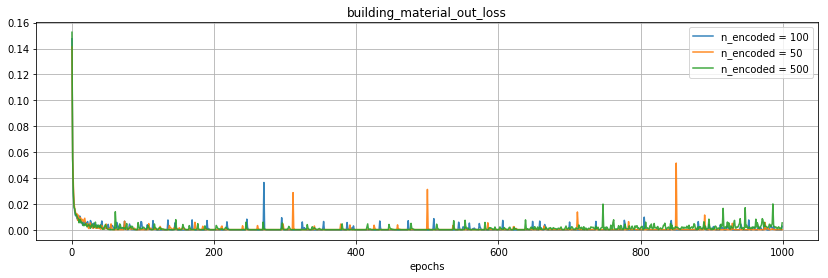

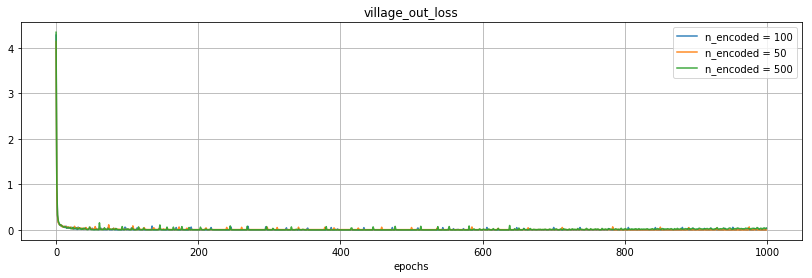

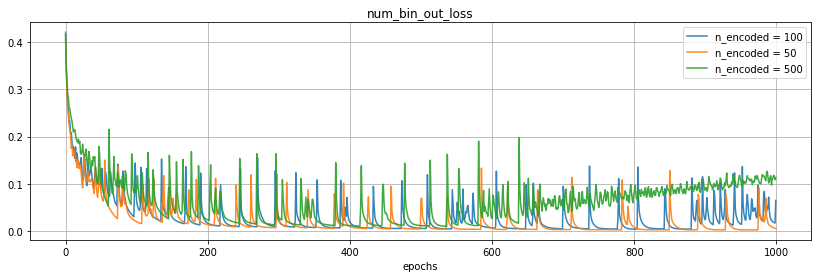

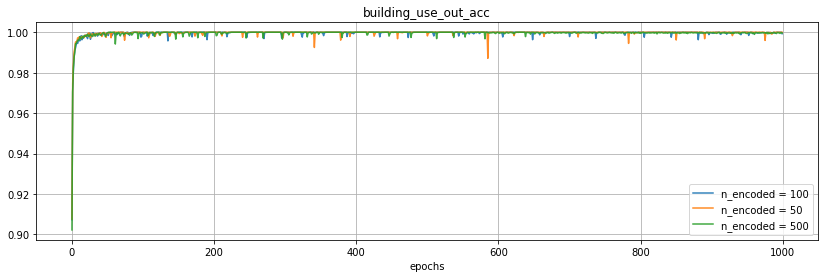

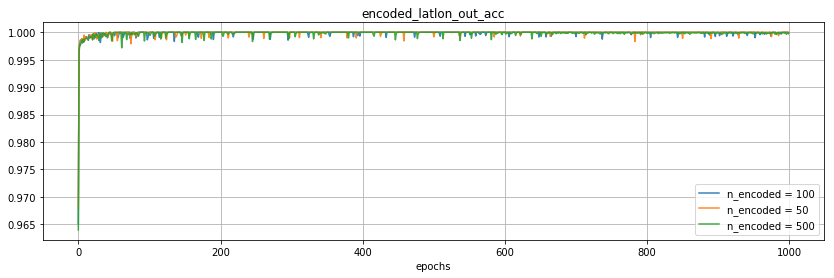

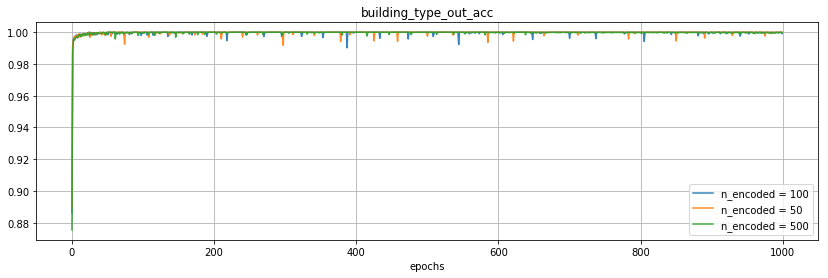

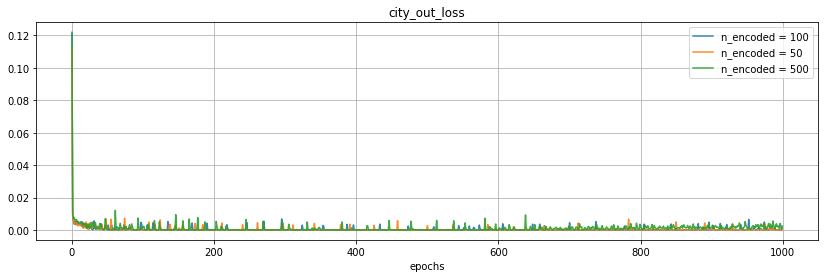

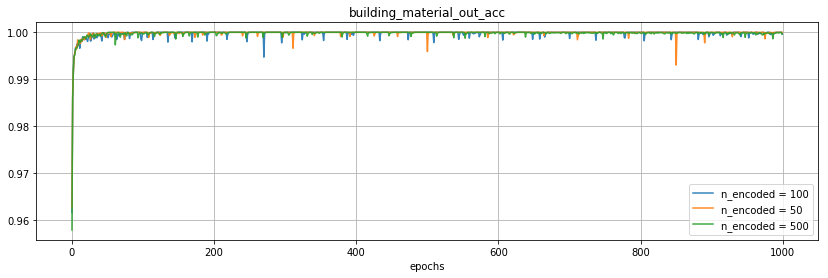

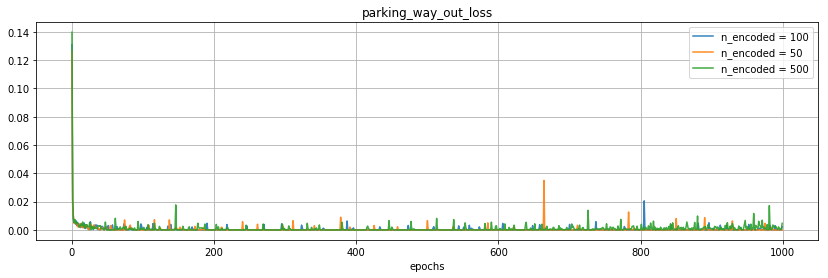

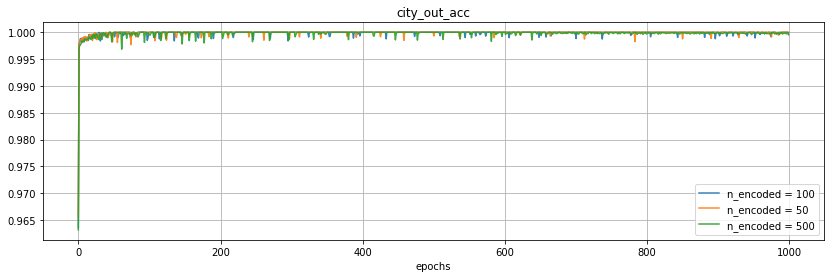

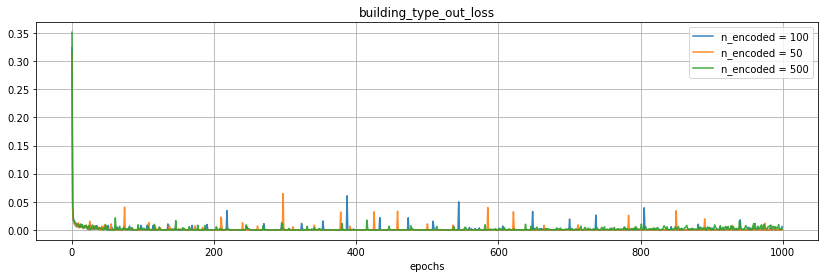

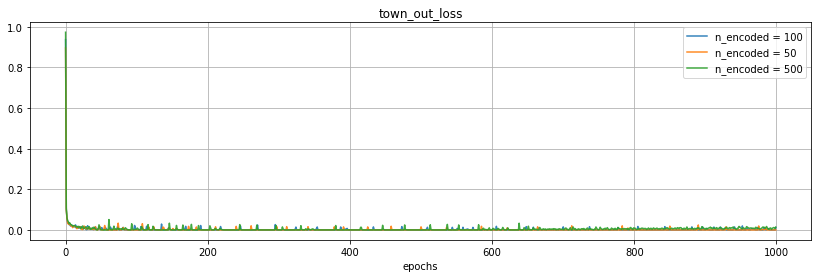

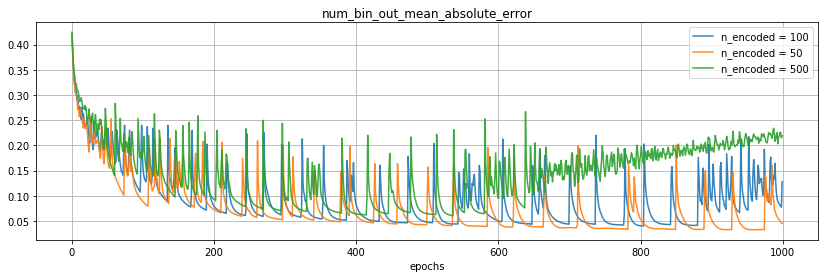

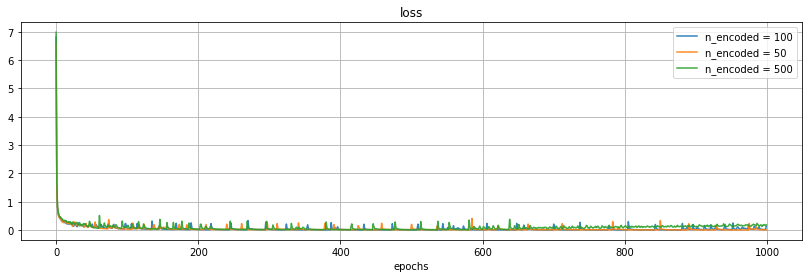

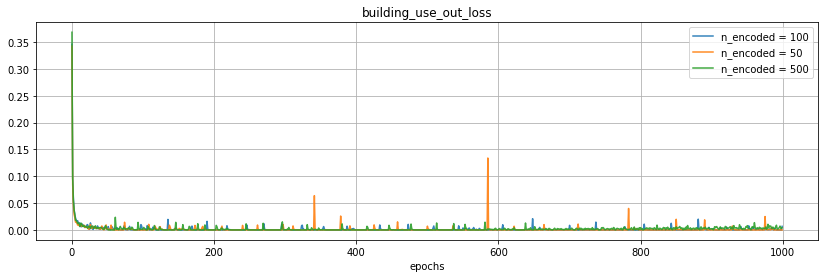

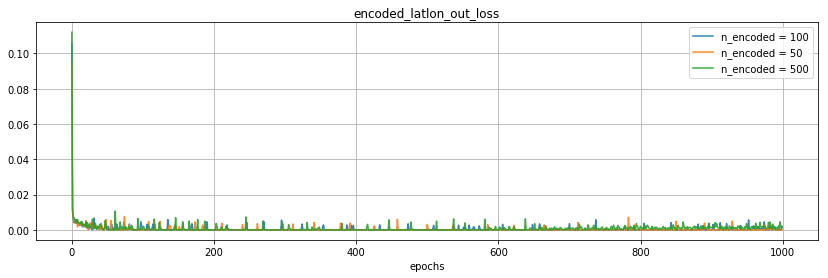

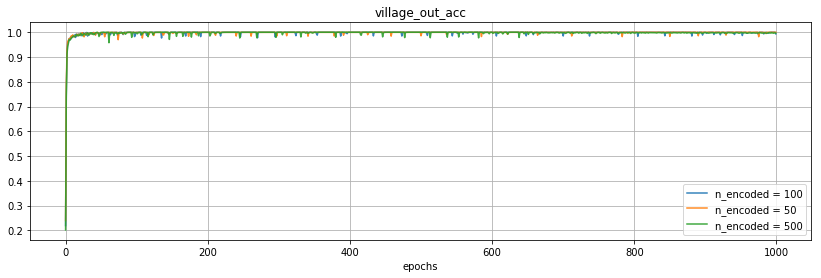

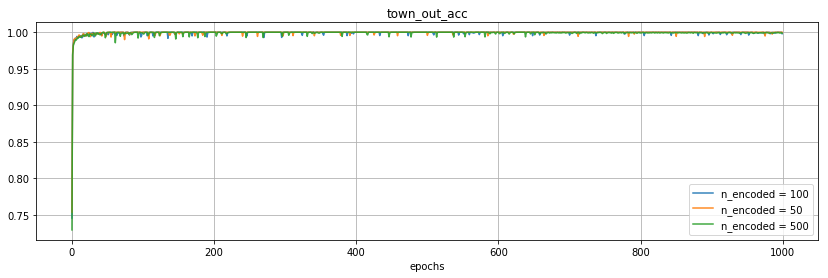

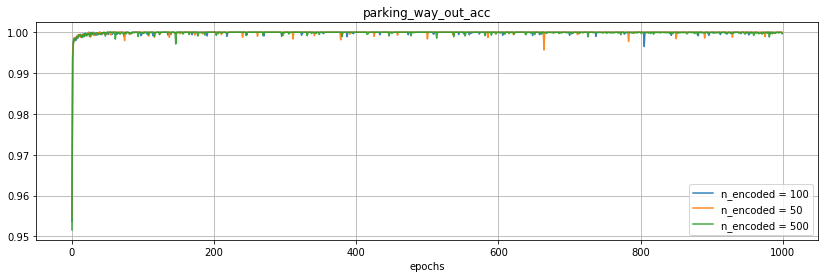

In [24]:
hists_labels = [[v['hist'].history, 
                 ', '.join([p+' = '+str(dict(k)[p]) for p in params_gsearch])] for k, v in gsearch.items()]
plot_keras_hists([x[0] for x in hists_labels], labels=[x[1] for x in hists_labels])

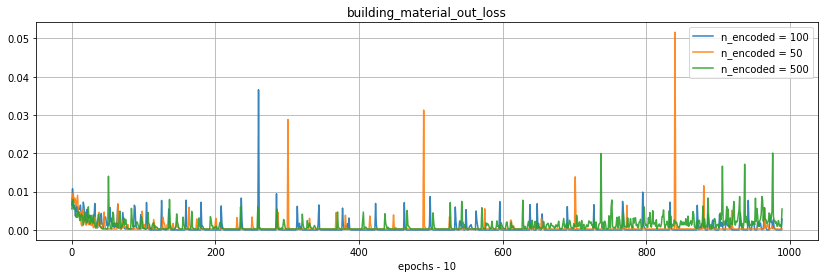

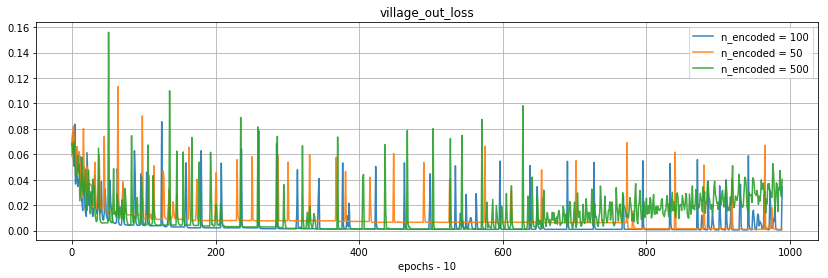

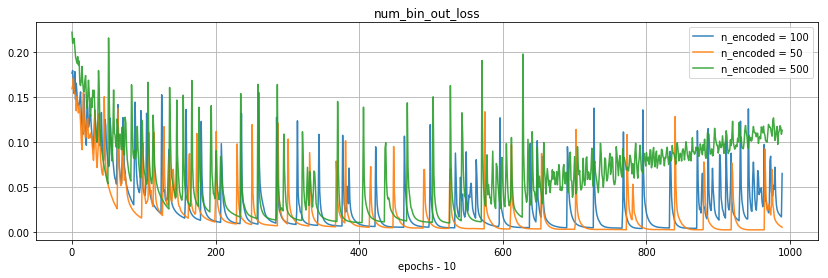

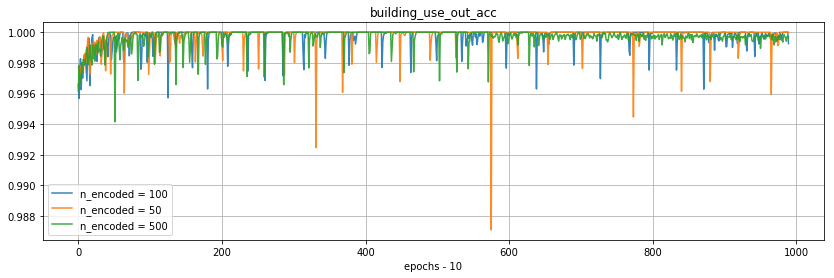

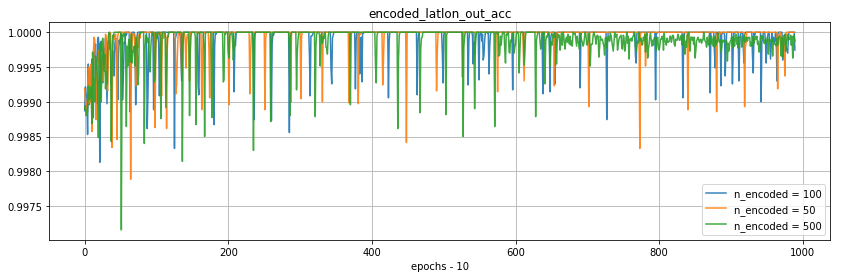

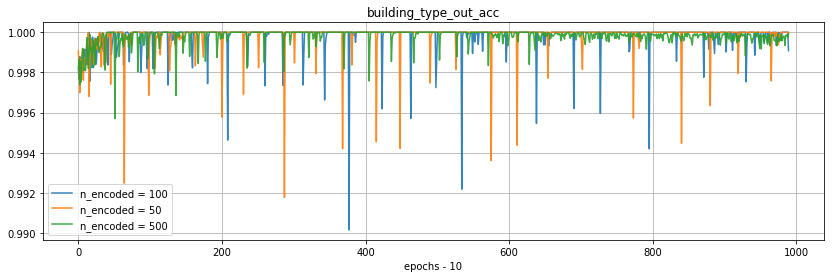

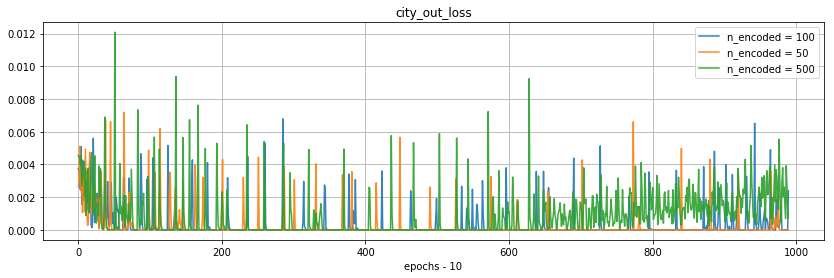

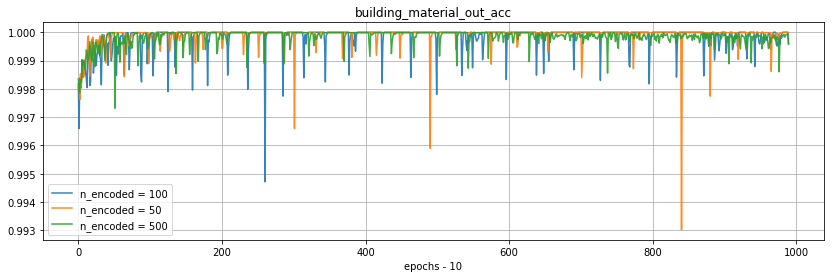

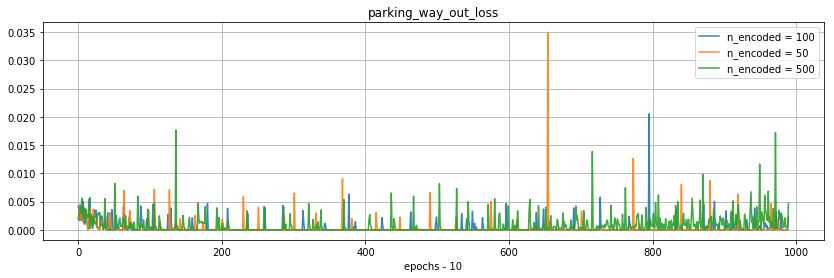

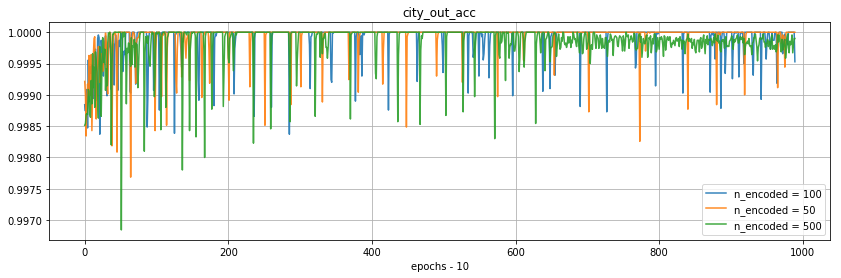

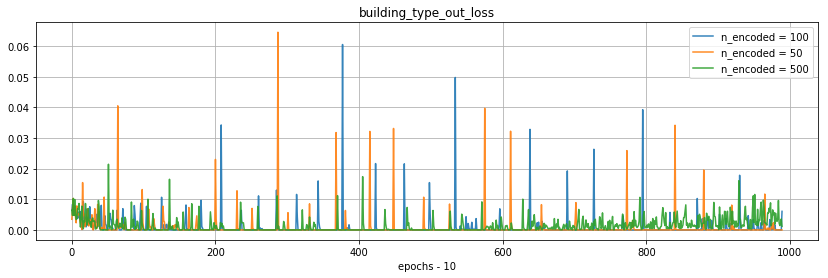

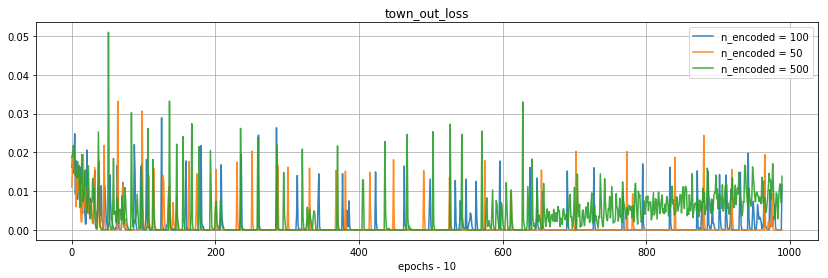

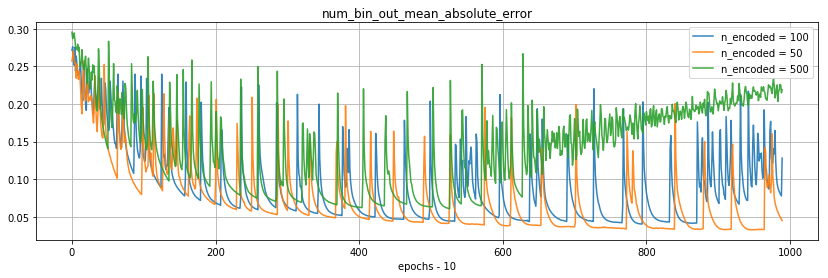

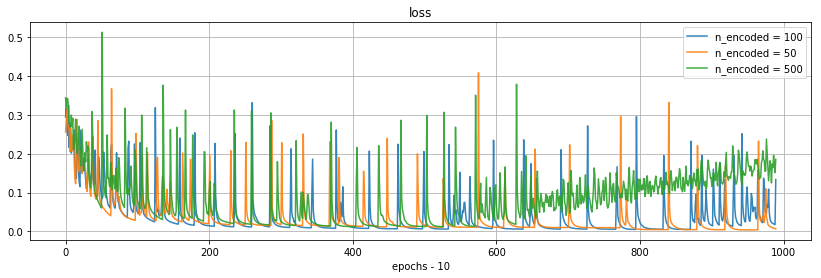

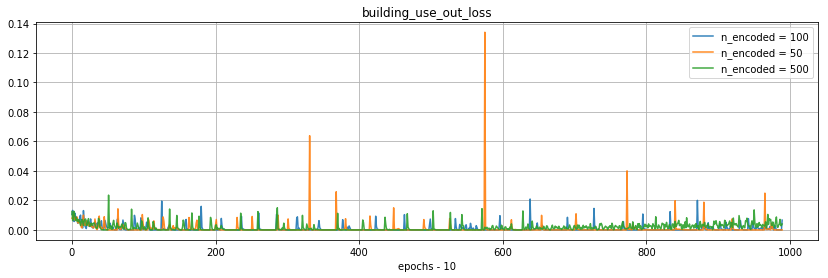

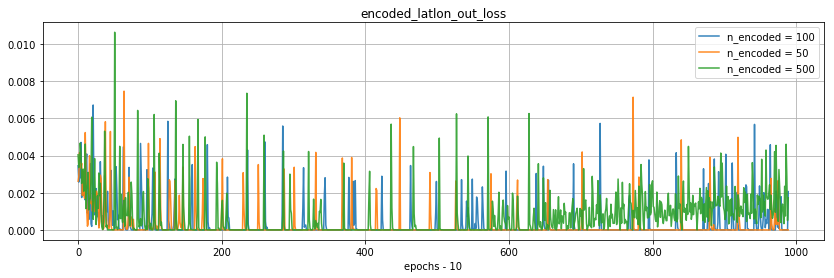

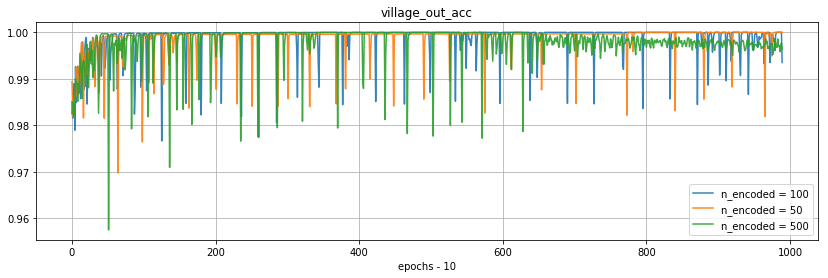

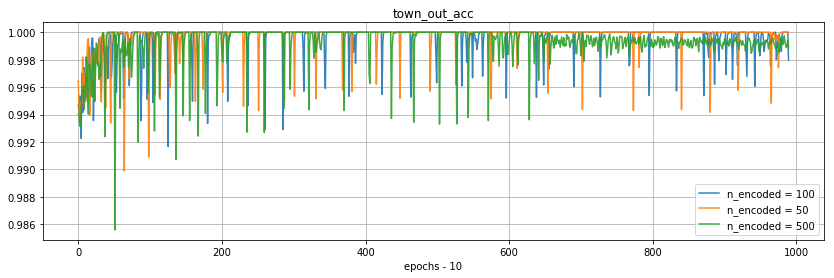

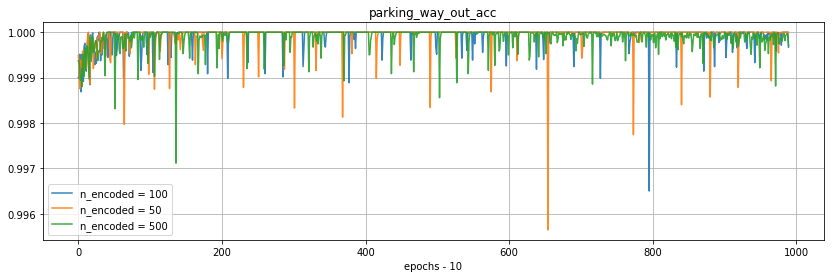

In [28]:
# later epoch plot
plot_keras_hists([x[0] for x in hists_labels], labels=[x[1] for x in hists_labels], skip=10)

In [25]:
def plot_encoded_dist(gsearch, params_gsearch):
    for k, v in gsearch.items():
        label = ', '.join([p+' = '+str(dict(k)[p]) for p in params_gsearch])
        print(label)
        df_temp = v['encoded'].drop('building_id', axis=1)
        n_feats = df_temp.shape[1]
        n_rows = n_feats // 10 + 1
        df_temp.hist(bins=30, layout=(n_rows, 10), figsize=(16, n_rows*1.8), sharey=True)
        plt.tight_layout(0.1)
        plt.show()

n_encoded = 100


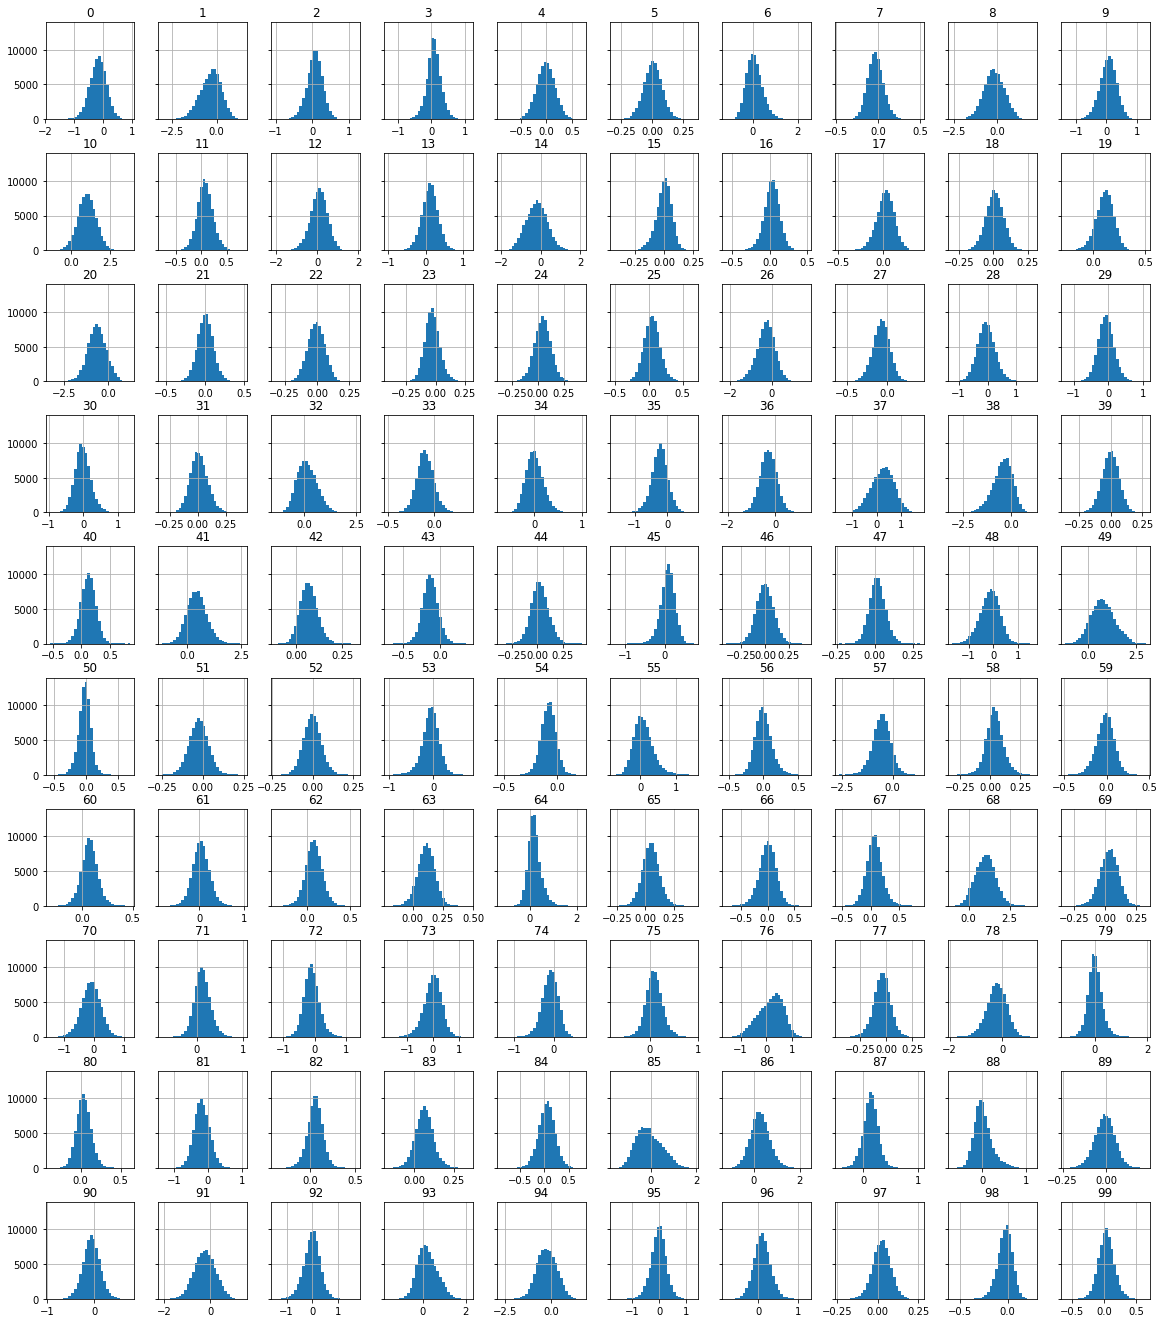

n_encoded = 50


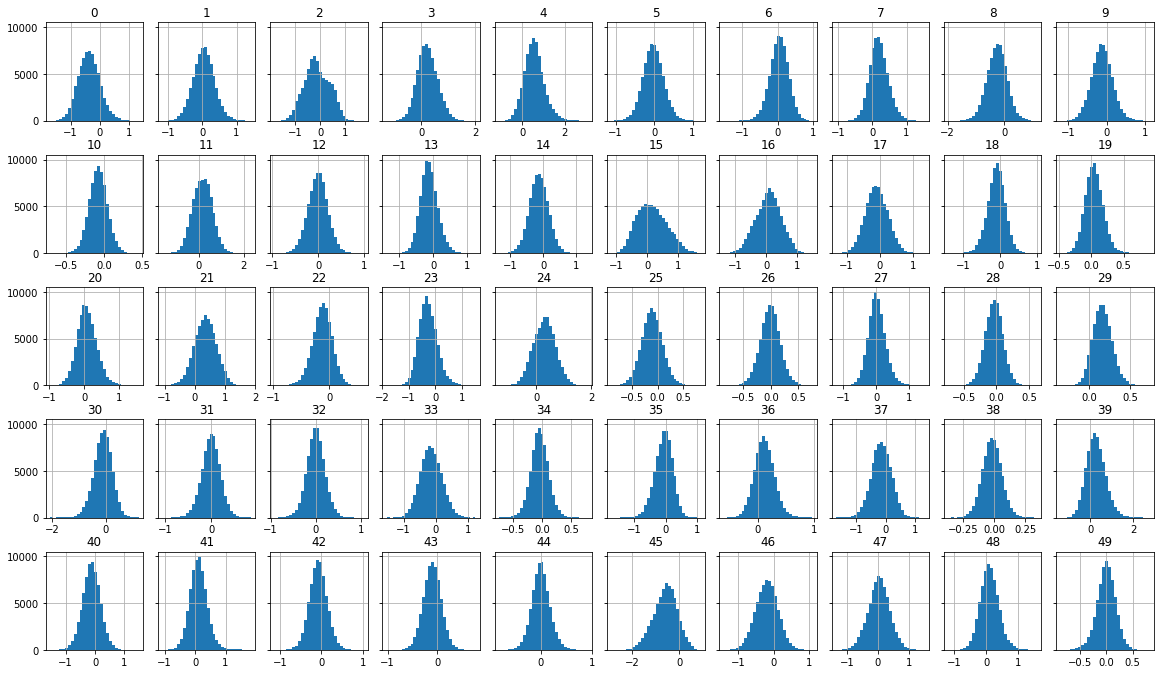

n_encoded = 500


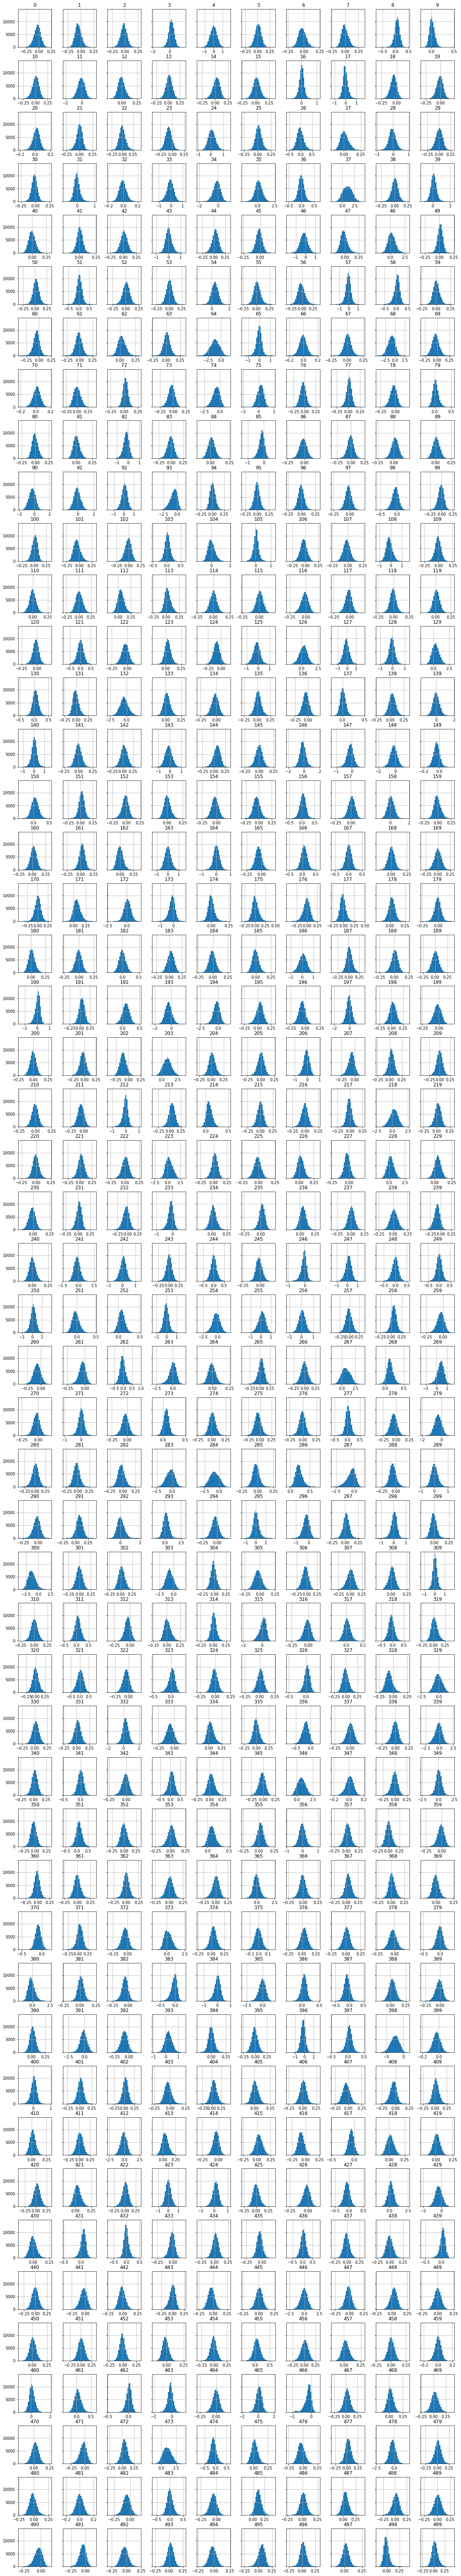

In [26]:
plot_encoded_dist(gsearch, params_gsearch)

### Check output encoded dataframe

In [47]:
df_temp = pd.read_csv('model-12-build-keras-autoencoder-20.csv')

In [49]:
df_temp.shape

(70000, 21)

In [48]:
df_temp.check()

0          1          2          3           4          5  \
0      -91.28267 -58.985570  21.491627  -7.023354   14.532145 -22.272380   
1     -136.27255 -72.093605  30.186045   9.985119  105.983470 -24.316729   
2     -189.10426 -79.197560  59.973797 -16.887170  112.671540 -27.504139   
3     -184.93457 -82.393585  30.712076 -26.680788   79.246270 -40.418730   
4     -110.62823 -74.171710  17.295580   0.333627   15.736117 -23.984018   
69995  -67.14241 -57.073944   1.429799  22.895147   32.621906  -7.291683   
69996 -135.74739 -76.124690  65.462520 -16.656988   84.032104  13.984927   
69997  -86.17446 -65.450230  18.004126   1.661809    4.142670 -16.179796   
69998 -187.48785 -88.027970  77.652140 -30.962955   86.490070  -7.117725   
69999  -86.80727 -54.910010  21.535769   3.615482   33.860610 -30.206314   

               6          7          8          9  ...         11         12  \
0      10.421553  11.847960   5.011264   8.929750  ... -14.324823   3.730393   
1     -45.592640  46.173527 -46.730347  51.803220  ... -59.361786 -32.219696   
2     -45.166996  55.555300 -31.136993  48.600850  ... -73.128784 -56.343520   
3     -19.058428  50.726402 -23.886345  24.630228  ... -38.535934  -9.719758   
4      15.351455  13.474203  -0.984897  27.522951  ... -27.109203   0.163576   
69995 -10.845053  19.530489 -10.795761  37.083530  ... -39.617348  -1.382304   
69996 -26.091532  46.647743  -5.102361  63.168926  ... -76.736950 -50.313404   
69997  20.110159   3.753848   8.722428  16.919520  ... -16.572224  10.237965   
69998 -26.974806  54.250250   2.064127  52.680195  ... -82.177450 -63.216637   
69999   4.678169   3.275945 -19.920849  12.312559  ...  -5.973533   4.938035   

              13         14         15          16         17          18  \
0     -30.641459   2.064049 -21.870895   27.679338 -24.599392   52.484220   
1     -35.118114 -44.888443  47.275856   91.642204 -16.752602   77.072020   
2     -28.623688 -43.988930  45.542740   88.911650 -18.598612   82.321075   
3     -88.277870 -16.251966   6.927206   63.244247 -19.483131   93.374740   
4     -50.512573   6.484629 -31.102665   50.857210 -12.070421   69.960710   
69995 -26.978220 -14.528130  -0.261108   68.511604  -9.303040   63.030160   
69996   0.758900 -69.857500  26.979662  107.404360  12.505518  100.750690   
69997 -33.501263   5.065338 -31.999980   32.983593 -18.826693   59.632397   
69998  -7.445891 -52.182540  20.371840   99.318540  -7.147913  100.055130   
69999 -31.991514  -0.075306  -3.082380   18.057034 -27.743185   38.407940   

              19       building_id  
0      -5.501586  e3mMIMR3JJqCaXz1  
1      20.783152  LgwzgklNvy4QCtq5  
2      24.217716  ucIR2NLLsC3T650L  
3       0.485719  jre1pJhcQj91Kdky  
4       4.677175  rQpYpY9nRG7X5mmr  
69995  26.008299  UEeCDaAJzPwdKKKA  
69996  53.952515  i0fgbPaQsDWs7Q87  
69997  -1.194267  YunNwAhcqkf6YclI  
69998  44.019430  A2NotxtRY9MYoWMl  
69999 -23.093092  kKvgBXiA50gRmQhP  

[10 rows x 21 columns]

shape = (70000, 21)


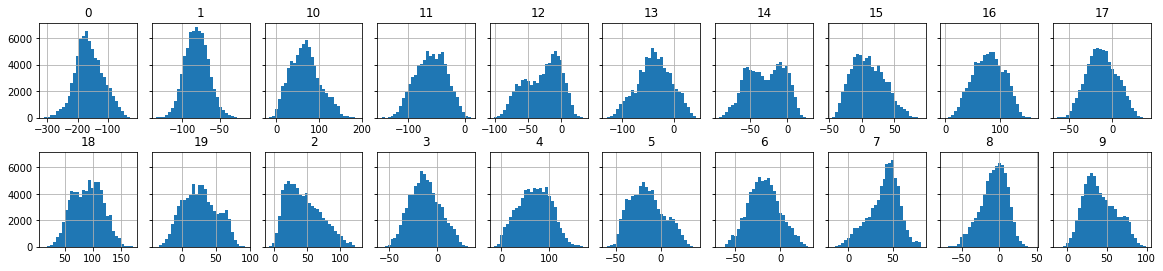

In [62]:
df_temp.drop('building_id', axis=1).hist(bins=30, layout=(2, 10), figsize=(16, 3.6), sharey=True)
plt.tight_layout(0.1)
plt.show()

### Old 

In [ ]:
metrics = ['score', 'mse', 'mae', 'mape']

df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['history'] = [h.history for h in row[5]]
    result['best_iterations'] = [np.argmin(h.history['val_mean_absolute_error'])+1 for h in row[5]]
    result['mean_best_iterations'] = np.mean(result['best_iterations'])
    if 'optimizer' in result:
        result['optimizer'] = str(result['optimizer'])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[
    metrics+[c for c in df_gsearch_results if c not in metrics and c != 'history']+['history']]
display(df_gsearch_results)

In [26]:
df_gsearch_results.to_hdf(result_filename+'.h5', key='main', mode='w')

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['best_iterations', 'loss', 'n_neurons', 'history']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [47]:
gsearch_results_show = [[x for i, x in enumerate(row) if i != 5] for row in gsearch_results]
print('gsearch_results_show = [')
for row in gsearch_results_show:
    print('  ', row, ',')
print(']')

gsearch_results_show = [
   [(('embedding_ratio', 3), ('epochs', 500), ('loss', 'mse'), ('batch_norm', True), ('batch_size', 256), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545))), 5271.515984222293, 0.049459383, 0.14344569, 0.010776781, [5244.847032085061, 5260.852013334632, 5308.848907247187], [0.048808444, 0.050605, 0.04896471], [0.14440957, 0.14356168, 0.14236581], [0.010863275, 0.0107681295, 0.010698938]] ,
   [(('embedding_ratio', 5), ('epochs', 500), ('loss', 'mse'), ('batch_norm', True), ('batch_size', 256), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545))), 5252.182796493173, 0.049336523, 0.1437289, 0.010792692, [5232.850204363465, 5232.851224184036, 5290.846960932016], [0.047955707, 0.05064658, 0.04940729], [0.14393605, 0.14442703, 0.14282358], [0.01081393, 0.010831801, 0.010732345]] ,
   [(('embedding_ratio', 2), ('epochs', 500), ('loss', 'mse'), ('batch_norm', True), ('batch_size', 256), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545))), 5244.183824126919, 0.049161047, 

In [28]:
if False:
    gsearch_results_show = [
    ]

In [6]:
df_gsearch_results = pd.read_hdf(result_filename+'.h5', key='main')

In [7]:
df_gsearch_results['mean_best_iterations'] = np.round(df_gsearch_results['mean_best_iterations']).astype('int32')
df_gsearch_results['mean_mse_nn'] = [
    np.mean([hist['val_loss'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['mean_mae_nn'] = [
    np.mean([hist['val_mean_absolute_error'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['std_mse_nn'] = [
    np.std([hist['val_loss'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['std_mae_nn'] = [
    np.std([hist['val_mean_absolute_error'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]

In [8]:
display(df_gsearch_results)

score       mse       mae      mape  batch_norm  batch_size  \
0  5271.515984  0.049459  0.143446  0.010777        True         256   
1  5252.182796  0.049337  0.143729  0.010793        True         256   
2  5244.183824  0.049161  0.143132  0.010748        True         256   
3  5241.847351  0.049773  0.144064  0.010825        True         256   

   best_iterations  embedding_ratio  epochs loss  mean_best_iterations  \
0  [288, 392, 409]                3     500  mse                   363   
1  [285, 263, 368]                5     500  mse                   305   
2  [329, 408, 267]                2     500  mse                   335   
3  [303, 358, 292]                4     500  mse                   318   

                            n_neurons  \
0  (2180, 2180, 1090, 1090, 545, 545)   
1  (2180, 2180, 1090, 1090, 545, 545)   
2  (2180, 2180, 1090, 1090, 545, 545)   
3  (2180, 2180, 1090, 1090, 545, 545)   

                                             history  mean_mse_nn  \
0  [{'loss': [0.5542073615550995, 0.1204620158433...     0.053447   
1  [{'loss': [0.5819491271018982, 0.1180755200386...     0.053428   
2  [{'loss': [0.5283503200650215, 0.1162520815968...     0.053672   
3  [{'loss': [0.5648952144145966, 0.1233129028081...     0.054528   

   mean_mae_nn  std_mse_nn  std_mae_nn  
0     0.150641    0.000986    0.000418  
1     0.149926    0.001153    0.000416  
2     0.150288    0.001036    0.001092  
3     0.151485    0.001269    0.000637

In [32]:
display(df_gsearch_results[list(params_gsearch.keys())+metrics])

embedding_ratio        score       mse       mae      mape
0                3  5271.515984  0.049459  0.143446  0.010777
1                5  5252.182796  0.049337  0.143729  0.010793
2                2  5244.183824  0.049161  0.143132  0.010748
3                4  5241.847351  0.049773  0.144064  0.010825

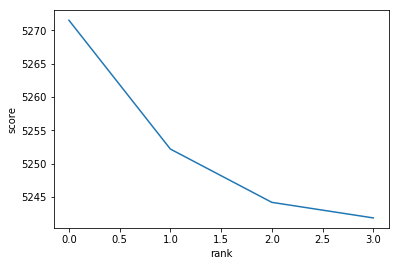

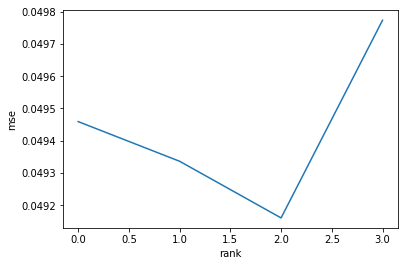

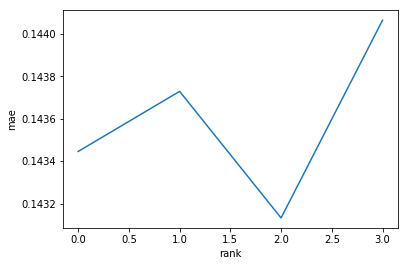

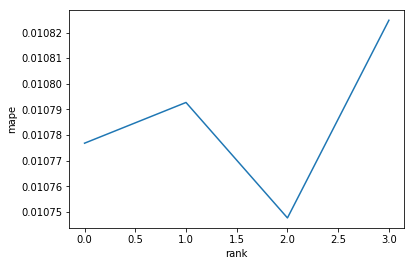

In [33]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

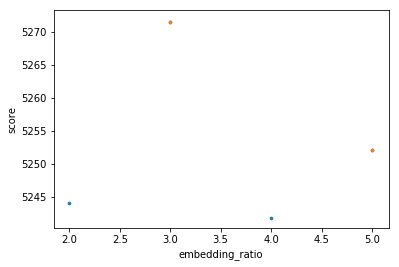

In [34]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=7)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

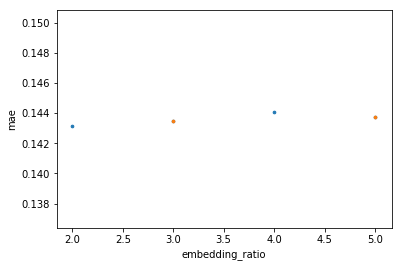

In [46]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['mae'][:2], s=7)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

#### Hist

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


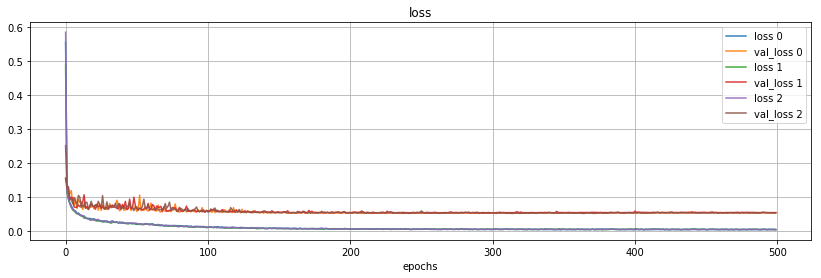

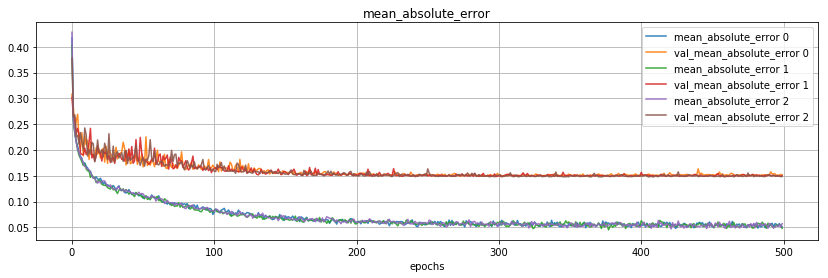

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


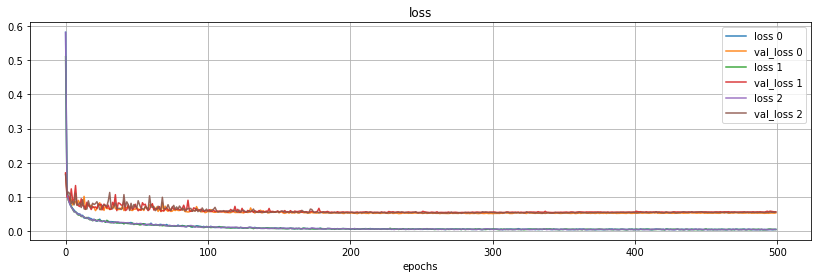

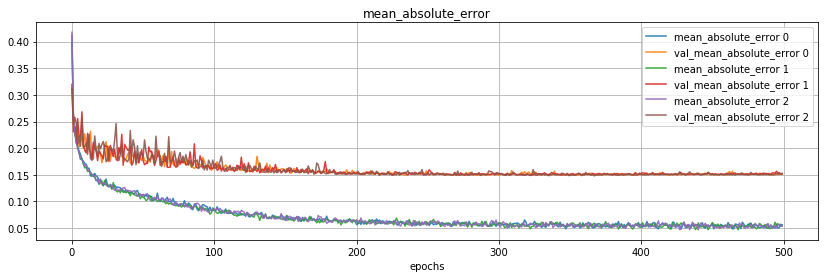

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


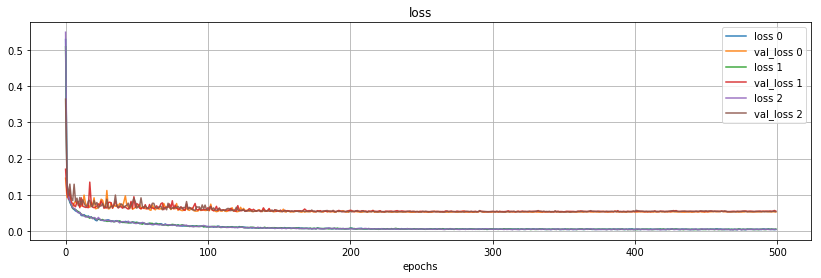

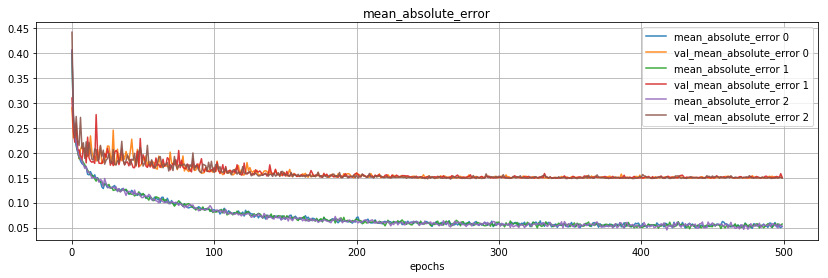

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


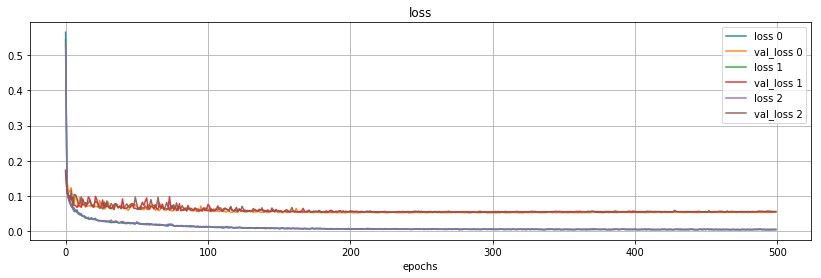

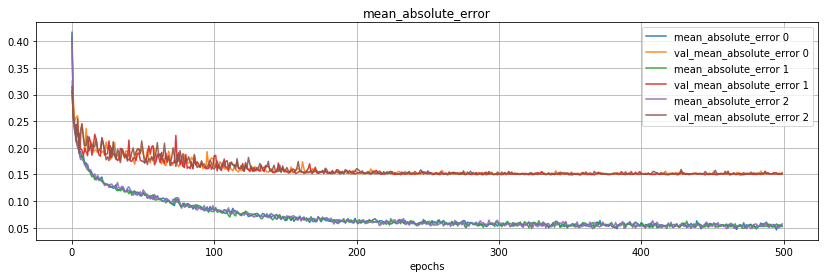

In [48]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists)

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


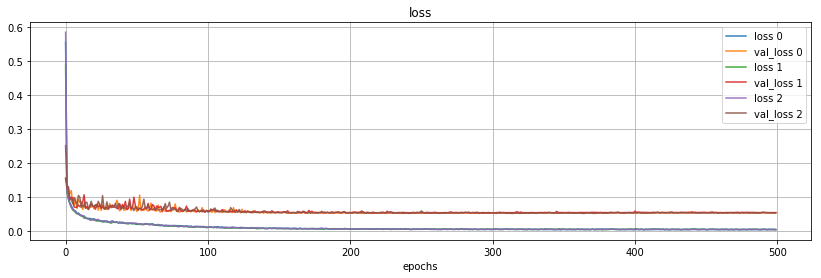

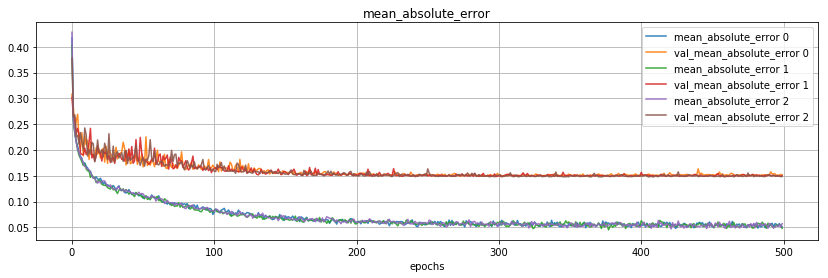

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


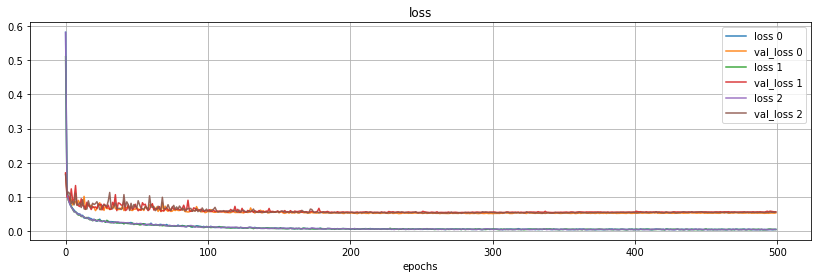

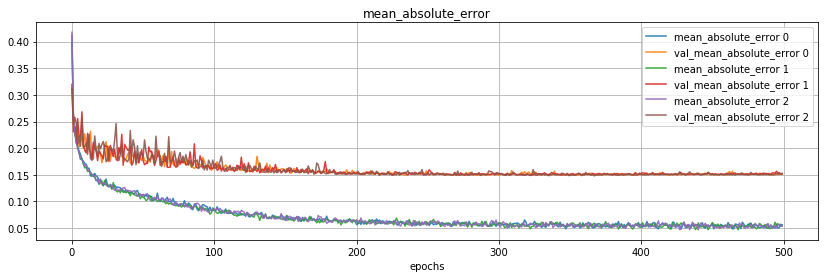

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


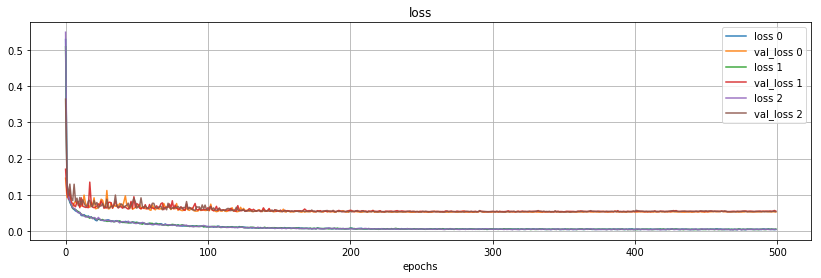

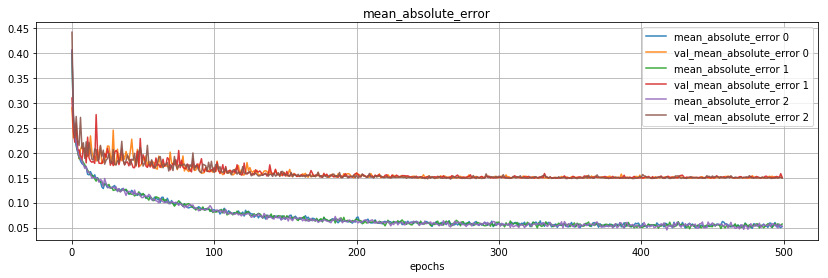

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


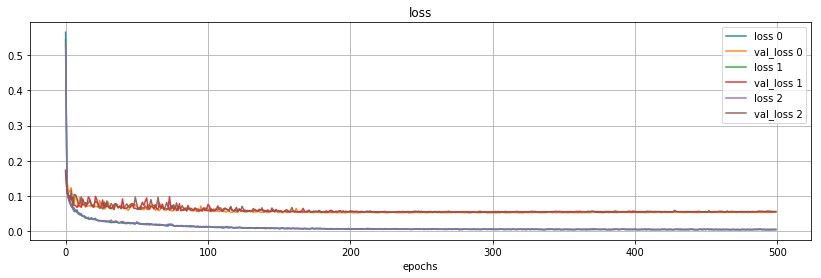

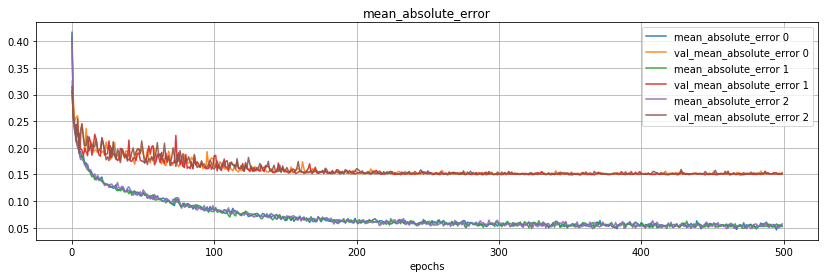

In [49]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists)

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


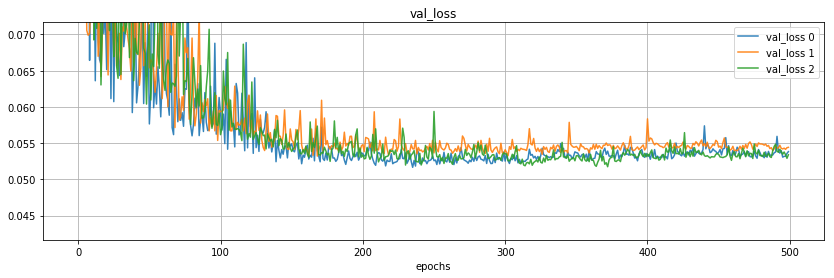

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


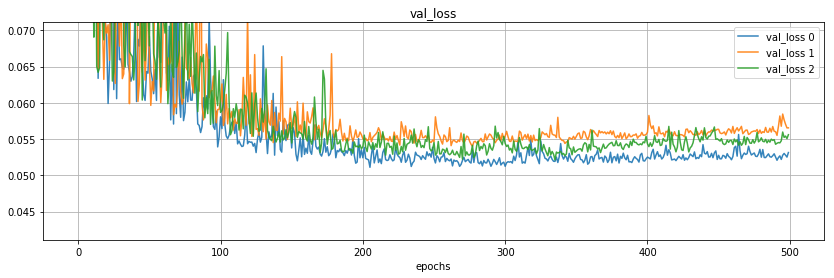

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


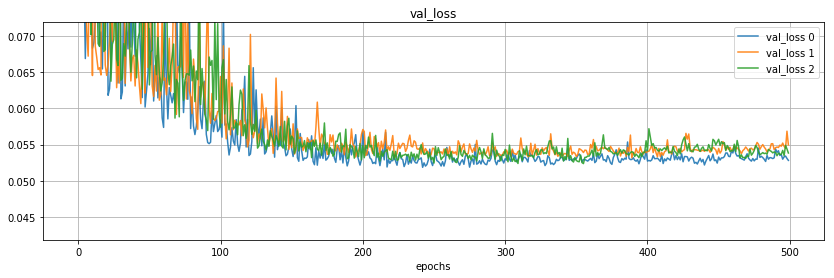

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


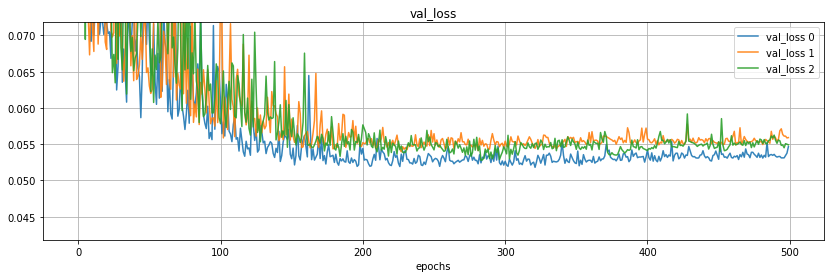

In [50]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists, ylim=(min(hists[0]['val_loss'])-0.01, 
                                min(hists[0]['val_loss'])+0.02), metrics_plot=['val_loss'])

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


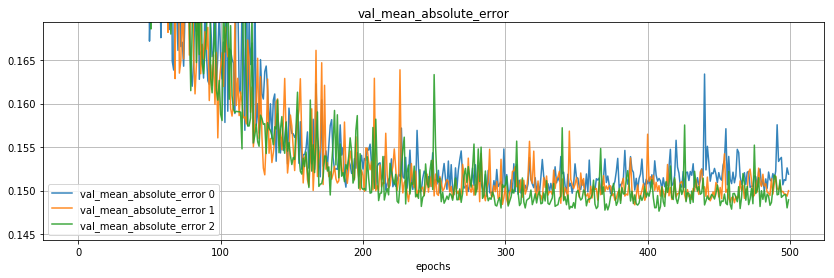

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


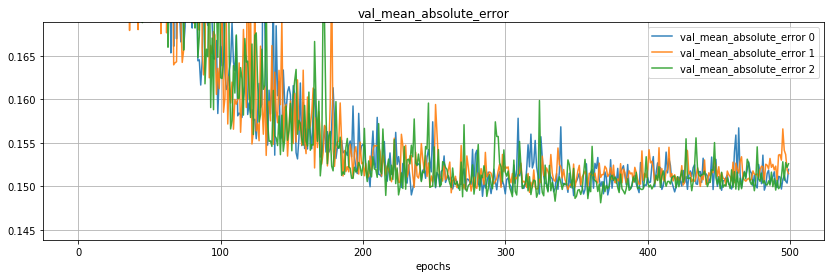

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


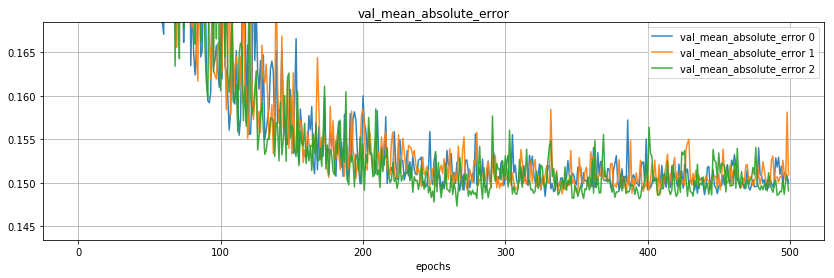

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


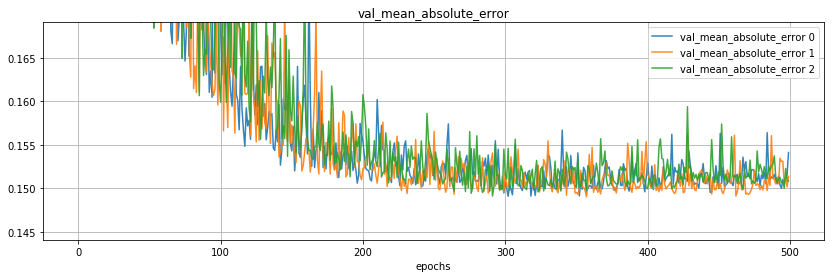

In [51]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists, ylim=(min(hists[0]['val_mean_absolute_error'])-0.005, 
                                min(hists[0]['val_mean_absolute_error'])+0.02), metrics_plot=['val_mean_absolute_error'])

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


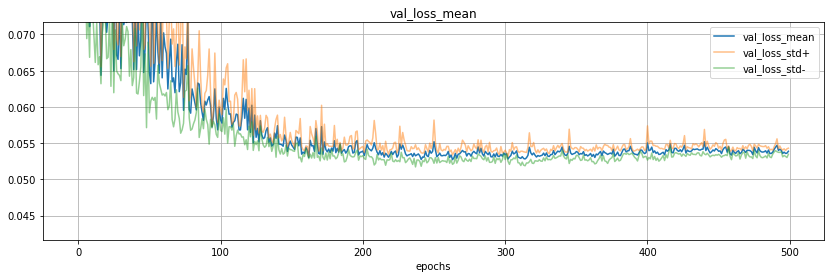

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


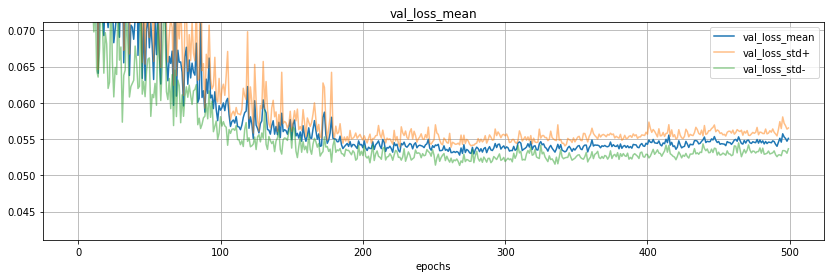

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


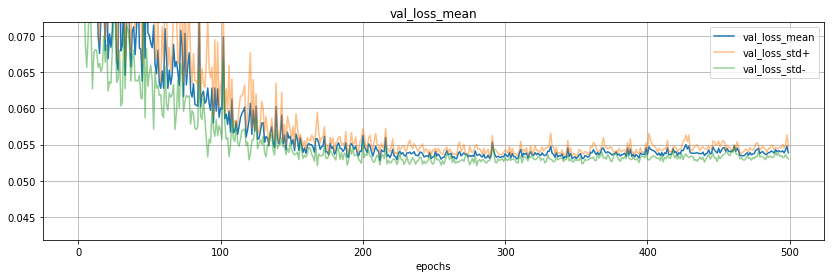

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


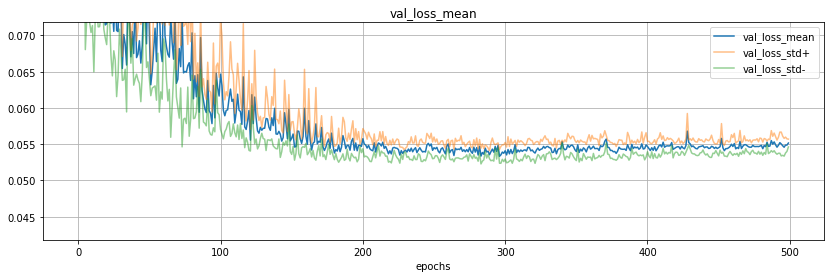

In [52]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist_mean(hists, ylim=(min(hists[0]['val_loss'])-0.01, 
                                     min(hists[0]['val_loss'])+0.02), metrics_plot=['val_loss'])

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


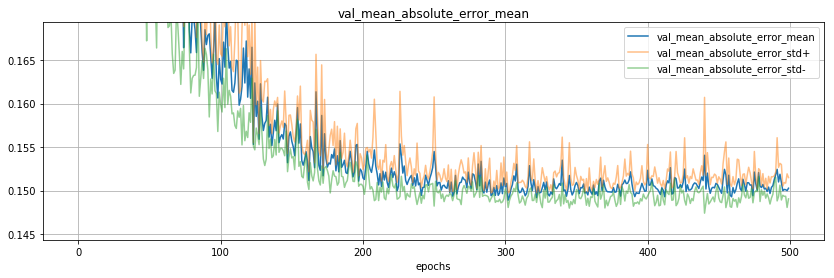

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


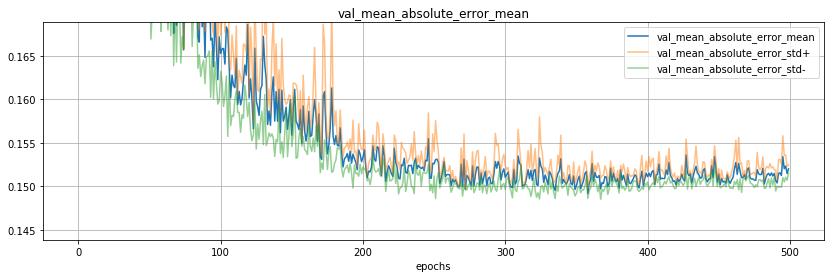

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


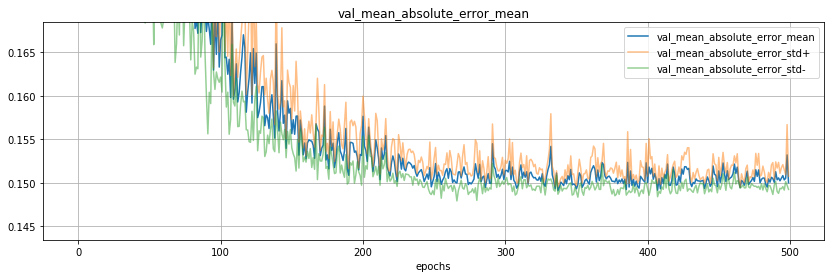

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


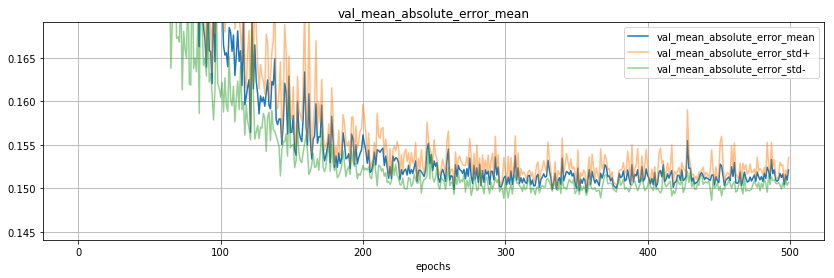

In [53]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist_mean(hists, ylim=(min(hists[0]['val_mean_absolute_error'])-0.005, 
                                     min(hists[0]['val_mean_absolute_error'])+0.02), metrics_plot=['val_mean_absolute_error'])

#### Mean scores

In [42]:
df_gsearch_results.check()

score       mse       mae      mape  batch_norm  batch_size  \
0  5271.515984  0.049459  0.143446  0.010777        True         256   
1  5252.182796  0.049337  0.143729  0.010793        True         256   
2  5244.183824  0.049161  0.143132  0.010748        True         256   
3  5241.847351  0.049773  0.144064  0.010825        True         256   

   best_iterations  embedding_ratio  epochs loss  mean_best_iterations  \
0  [288, 392, 409]                3     500  mse                   363   
1  [285, 263, 368]                5     500  mse                   305   
2  [329, 408, 267]                2     500  mse                   335   
3  [303, 358, 292]                4     500  mse                   318   

                            n_neurons  \
0  (2180, 2180, 1090, 1090, 545, 545)   
1  (2180, 2180, 1090, 1090, 545, 545)   
2  (2180, 2180, 1090, 1090, 545, 545)   
3  (2180, 2180, 1090, 1090, 545, 545)   

                                             history  mean_mse_nn  \
0  [{'loss': [0.5542073615550995, 0.1204620158433...     0.053447   
1  [{'loss': [0.5819491271018982, 0.1180755200386...     0.053428   
2  [{'loss': [0.5283503200650215, 0.1162520815968...     0.053672   
3  [{'loss': [0.5648952144145966, 0.1233129028081...     0.054528   

   mean_mae_nn  std_mse_nn  std_mae_nn  
0     0.150641    0.000986    0.000418  
1     0.149926    0.001153    0.000416  
2     0.150288    0.001036    0.001092  
3     0.151485    0.001269    0.000637

shape = (4, 17)


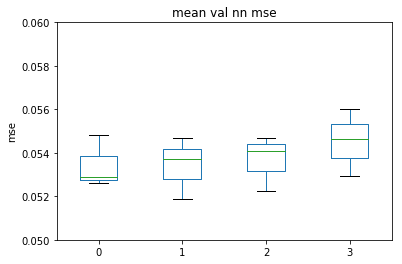

In [43]:
pd.DataFrame([
    [hist['val_loss'][epoch-1] for hist in hists]
    for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]).T.plot.box(ylim=(0.05, 0.06), title='mean val nn mse'); plt.ylabel('mse'); plt.show()

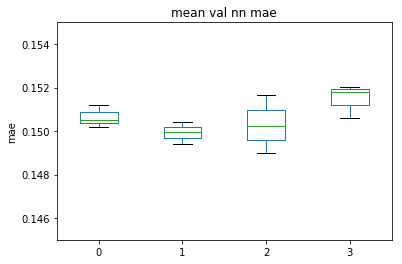

In [55]:
pd.DataFrame([
    [hist['val_mean_absolute_error'][epoch-1] for hist in hists]
    for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]).T.plot.box(ylim=(0.145, 0.155), title='mean val nn mae'); plt.ylabel('mae'); plt.show()

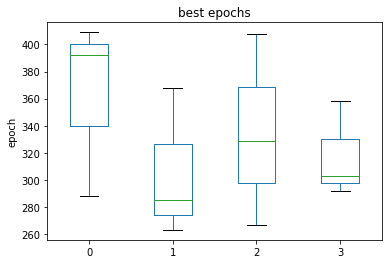

In [45]:
pd.DataFrame([
    row for row in df_gsearch_results['best_iterations']
]).T.plot.box(title='best epochs'); plt.ylabel('epoch'); plt.show()

### Result